# **Machine Learning Group Project**
This project analyzes department level organizational data to identify patterns associated with compliance risk and support evidence-based monitoring. To go beyond a single risk score, we combine EDA, to check data quality and understand key signals, unsupervised clustering, to segment departments into interpretable risk typologies, and a supervised screening model, to flag departments that resemble previously observed high risk profiles. Prediction is used as decision support, not automation, preprocessing is handled carefully to avoid leakage, and outputs are intended to guide human review and targeted follow-up.

In [ ]:

import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

RNG_SEED = 42

plt.style.use("default")
sns.set()

# Data loading
In the next cell we connect to the SQLite database, **org_compliance_data.db**, and then we inspect the available tables and load the **departments** table, which is the department-level dataset used for the rest of the analysis.

We use **departments** as the base table because it contains the full department level feature set used for EDA, clustering, and prediction, the other tables are aggregated summaries or derived subsets and are not needed for modeling.

In [ ]:
db_path = "org_compliance_data.db"
conn = sqlite3.connect(db_path)

In [ ]:
tables = pd.read_sql_query(
    "SELECT name FROM sqlite_master WHERE type='table';",
    conn
)
tables

name
0               departments
1  risk_summary_by_division
2     high_risk_departments
3           data_dictionary

In [ ]:
df_dept = pd.read_sql_query("SELECT * FROM departments;", conn)

df_dept.shape

(709, 37)

In [ ]:
df_dept.head()

dept_id                   dept_name           dept_category  \
0  DEPT-1620             Core Compliance     Financial_Reporting   
1  DEPT-1133          Digital Governance     Financial_Reporting   
2  DEPT-4917                 Central Hub  Operational_Compliance   
3  DEPT-6959  Compliance - Legacy Region     Financial_Reporting   
4  DEPT-4312      West Internal Controls     Financial_Reporting   

       division   dept_type  dept_age_years location_type team_size  \
0  Corporate_HQ  Operations             8.0        Remote     Large   
1  Corporate_HQ  Compliance             8.0         Urban     Large   
2          None        None             NaN          None      None   
3  Corporate_HQ     Support             8.0         Urban     Large   
4  Corporate_HQ  Operations             6.0         Urban     Small   

  reporting_structure  manager_experience_level  ...  \
0         Centralized                       2.0  ...   
1         Centralized                       2.0  ...   
2                None                       NaN  ...   
3         Centralized                       4.0  ...   
4         Centralized                       1.0  ...   

   resource_availability_score external_interactions_frequency  \
0                          2.0                             3.0   
1                          4.0                             NaN   
2                          NaN                             NaN   
3                          3.0                             4.0   
4                          4.0                             2.0   

  risk_exposure_operational risk_exposure_financial operational_health_index  \
0                       1.0                     NaN                      5.0   
1                       2.0                     2.0                      1.0   
2                       NaN                     NaN                      NaN   
3                       1.0                     1.0                      5.0   
4                       1.0                     1.0                      5.0   

   reporting_gaps_annual  audit_score_q1  audit_score_q2  \
0                    NaN            55.0            55.0   
1                   26.0             NaN            40.0   
2                    NaN             NaN             NaN   
3                    2.0            70.0            75.0   
4                    2.0            45.0            45.0   

   compliance_score_final  overall_risk_score  
0                    65.0                12.0  
1                     NaN                43.0  
2                     NaN                 NaN  
3                    85.0                11.0  
4                    45.0                11.0  

[5 rows x 37 columns]

In [ ]:
df_dept.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 709 entries, 0 to 708
Data columns (total 37 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   dept_id                          709 non-null    object 
 1   dept_name                        709 non-null    object 
 2   dept_category                    709 non-null    object 
 3   division                         455 non-null    object 
 4   dept_type                        413 non-null    object 
 5   dept_age_years                   411 non-null    float64
 6   location_type                    410 non-null    object 
 7   team_size                        409 non-null    object 
 8   reporting_structure              413 non-null    object 
 9   manager_experience_level         413 non-null    float64
 10  supervisor_experience_level      409 non-null    float64
 11  primary_function                 416 non-null    object 
 12  secondary_function    

In [ ]:
df_dept.describe()

dept_age_years  manager_experience_level  supervisor_experience_level  \
count      411.000000                413.000000                   409.000000   
mean         6.802920                  2.624697                     2.398533   
std          1.915939                  1.164637                     1.137635   
min          2.000000                  0.000000                     0.000000   
25%          6.000000                  2.000000                     2.000000   
50%          7.000000                  3.000000                     2.000000   
75%          8.000000                  4.000000                     3.000000   
max         15.000000                  4.000000                     4.000000   

       reporting_lag_days  training_hours_quarterly  violations_past_3years  \
count          412.000000                409.000000              406.000000   
mean             1.682039                 43.180929                0.435961   
std              1.019693                 19.728215                1.108703   
min              1.000000                 12.000000                0.000000   
25%              1.000000                 20.000000                0.000000   
50%              1.000000                 40.000000                0.000000   
75%              2.000000                 60.000000                0.000000   
max              5.000000                100.000000                5.000000   

       remediation_plan_active  executive_support  external_consulting  \
count               411.000000         413.000000           414.000000   
mean                  0.175182           0.607748             0.123188   
std                   0.380586           0.488845             0.329051   
min                   0.000000           0.000000             0.000000   
25%                   0.000000           0.000000             0.000000   
50%                   0.000000           1.000000             0.000000   
75%                   0.000000           1.000000             0.000000   
max                   1.000000           1.000000             1.000000   

       engagement_programs  ...  resource_availability_score  \
count           410.000000  ...                   410.000000   
mean              0.519512  ...                     3.190244   
std               0.500230  ...                     1.061854   
min               0.000000  ...                     1.000000   
25%               0.000000  ...                     3.000000   
50%               1.000000  ...                     3.000000   
75%               1.000000  ...                     4.000000   
max               1.000000  ...                     5.000000   

       external_interactions_frequency  risk_exposure_operational  \
count                       406.000000                 416.000000   
mean                          3.086207                   1.673077   
std                           1.190479                   1.112404   
min                           1.000000                   1.000000   
25%                           2.000000                   1.000000   
50%                           3.000000                   1.000000   
75%                           4.000000                   2.000000   
max                           5.000000                   5.000000   

       risk_exposure_financial  operational_health_index  \
count               410.000000                411.000000   
mean                  2.360976                  3.491484   
std                   1.361877                  1.447218   
min                   1.000000                  1.000000   
25%                   1.000000                  2.000000   
50%                   2.000000                  4.000000   
75%                   3.000000                  5.000000   
max                   5.000000                  5.000000   

       reporting_gaps_annual  audit_score_q1  audit_score_q2  \
count             412.000000      430.000000      435.000000   
mean                5.114078       61.7

# Findings so far:

General Structure:

-The dataset contains **709 rows and 37 columns**

-There are **25 numerical cloumns** (float64)

-There are **12 categorical cloumns**(object)

#**Separating Numerical and Categorical Variables**

In order to make the analysis easier to manage, we first seperate the dataset into numerical and categorical cloumns. This helps us see how many variables of each type are available and ensures we apply the appropriate preprocessing steps later.

For example:
- **scaling** for numerical features
- **encoding** for categorical ones


In [ ]:

numeric_cols = df_dept.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_cols = df_dept.select_dtypes(include=["object"]).columns.tolist()

print("numeric_cols:")
print(numeric_cols)
print("categorical_cols:")
print(categorical_cols)

numeric_cols:
['dept_age_years', 'manager_experience_level', 'supervisor_experience_level', 'reporting_lag_days', 'training_hours_quarterly', 'violations_past_3years', 'remediation_plan_active', 'executive_support', 'external_consulting', 'engagement_programs', 'onboarding_program', 'improvement_commitment', 'digital_systems', 'external_partnerships', 'interdept_collaboration_score', 'resource_availability_score', 'external_interactions_frequency', 'risk_exposure_operational', 'risk_exposure_financial', 'operational_health_index', 'reporting_gaps_annual', 'audit_score_q1', 'audit_score_q2', 'compliance_score_final', 'overall_risk_score']
categorical_cols:
['dept_id', 'dept_name', 'dept_category', 'division', 'dept_type', 'location_type', 'team_size', 'reporting_structure', 'primary_function', 'secondary_function', 'creation_reason', 'oversight_body']


# **Identifying ID or Descriptive Columns**

Some columns in the dataset may functions simply as identifiers or descriptive labels, rather than meaningful analytical features. These columns are often:
- stored as strings (object type)
- and have values that are **unique or almost unique across rows**

To detect these cases, we compute **nunique**, number of distinct values for each column. Columns with very high uniqueness often indicate an ID-style variable, which helps with labeling but typically contributes little value as a modeling feature.


In [ ]:
nunique = df_dept.nunique().sort_values(ascending=False)
nunique

dept_id                            682
dept_name                          454
overall_risk_score                  86
audit_score_q2                      67
compliance_score_final              65
audit_score_q1                      63
training_hours_quarterly            46
reporting_gaps_annual               28
dept_age_years                      14
secondary_function                   7
primary_function                     7
dept_type                            6
violations_past_3years               6
risk_exposure_operational            5
operational_health_index             5
resource_availability_score          5
interdept_collaboration_score        5
creation_reason                      5
reporting_lag_days                   5
manager_experience_level             5
supervisor_experience_level          5
risk_exposure_financial              5
external_interactions_frequency      5
oversight_body                       4
location_type                        4
reporting_structure                  3
dept_category                        3
team_size                            3
division                             2
external_consulting                  2
executive_support                    2
remediation_plan_active              2
external_partnerships                2
engagement_programs                  2
onboarding_program                   2
improvement_commitment               2
digital_systems                      2
dtype: int64

# Interpretation

1) **ID and descriptive columns**:

- Based on **info()** and the number of unique values,**nunique()**:

    - **dept_id** has 682 unique values out of 709 meaning it behaves like an identifier (almost one unique value per row)

    - **dept_name** has 454 unique values and mainly serves as a descriptive label rather than a meaningful analytical feature

- For these reasons, neither of these will be used as clustering features. They are kept for identification and interpretetion, not for computing the clusters.

2) **Categorical columns as potential features**

- From **nunique()** various categorical variables have a small number of categories (roughly 2 to 7), this is ideal for one-hot encoding. -> These variables are therefore good candidates to include as categorical features (after encoding) in clustering and later supervised modeling.

3) **Numerical columns as feature candidates**:

- The numerical features generally show a reasonable number of unique values (they are not nearly constant). Overall, they provide useful information about departnental operations and risk exposure.



# **EDA Missing Value Analysis**

Before beggining the missing value analysis, we define three lists of coloumns in order to keep the workflow organized and consistent:
- **id_clos** are descriptive identifies (dept_id, dept_name)
  - these columns are never used as model features because they act as identifiers rather than providing useful informative attributes that help with pattern detection

- **num_features** is the set of numerical variables used throughout the analysis

- **cat_features** is the set of categorical variables

This setup keeps the EDA and preprocessing consistent and reproducible, while clearly separating modelling variables from purely descriptive ones.


In [ ]:
id_cols = ["dept_id", "dept_name"]

num_features = [
    'dept_age_years',
    'manager_experience_level',
    'supervisor_experience_level',
    'reporting_lag_days',
    'training_hours_quarterly',
    'violations_past_3years',
    'remediation_plan_active',
    'executive_support',
    'external_consulting',
    'engagement_programs',
    'onboarding_program',
    'improvement_commitment',
    'digital_systems',
    'external_partnerships',
    'interdept_collaboration_score',
    'resource_availability_score',
    'external_interactions_frequency',
    'risk_exposure_operational',
    'risk_exposure_financial',
    'operational_health_index',
    'reporting_gaps_annual',
    'audit_score_q1',
    'audit_score_q2',
    'compliance_score_final',
    'overall_risk_score'
]

cat_features = [
    'dept_category',
    'division',
    'dept_type',
    'location_type',
    'team_size',
    'reporting_structure',
    'primary_function',
    'secondary_function',
    'creation_reason',
    'oversight_body'
]

# **Missing Values Across Columns**
We begin by measuring missingness for every variable in the **departments table**, for each column we compute:

- the **absolute number** of missing values, missing_count
- the **percentage of missing values**, missing_percent

This provides a clear overview of the data and helps decide which variables require preprocessing, then we filter the table in order to keep columns with at least one missing value.

In [ ]:
missing_counts = df_dept.isnull().sum().sort_values(ascending=False)
missing_perc = (df_dept.isnull().mean().sort_values(ascending=False) * 100)

missing_df = pd.DataFrame({
    "missing_count": missing_counts,
    "missing_percent": missing_perc.round(2)
})
missing_df[missing_df["missing_count"] > 0]

missing_count  missing_percent
digital_systems                            304            42.88
oversight_body                             303            42.74
interdept_collaboration_score              303            42.74
violations_past_3years                     303            42.74
external_interactions_frequency            303            42.74
onboarding_program                         302            42.60
training_hours_quarterly                   300            42.31
overall_risk_score                         300            42.31
supervisor_experience_level                300            42.31
team_size                                  300            42.31
external_partnerships                      300            42.31
engagement_programs                        299            42.17
resource_availability_score                299            42.17
risk_exposure_financial                    299            42.17
location_type                              299            42.17
dept_age_years                             298            42.03
remediation_plan_active                    298            42.03
operational_health_index                   298            42.03
creation_reason                            297            41.89
reporting_gaps_annual                      297            41.89
reporting_lag_days                         297            41.89
dept_type                                  296            41.75
manager_experience_level                   296            41.75
reporting_structure                        296            41.75
executive_support                          296            41.75
external_consulting                        295            41.61
secondary_function                         294            41.47
primary_function                           293            41.33
risk_exposure_operational                  293            41.33
improvement_commitment                     292            41.18
audit_score_q1                             279            39.35
compliance_score_final                     276            38.93
audit_score_q2                             274            38.65
division                                   254            35.83

# Visualizing Missingness and Implications for Preprocessing
To make the comparison between features and identify variables with a high percentage of missing values easier, we visualize the percentage of missing values per column using a bar plot.

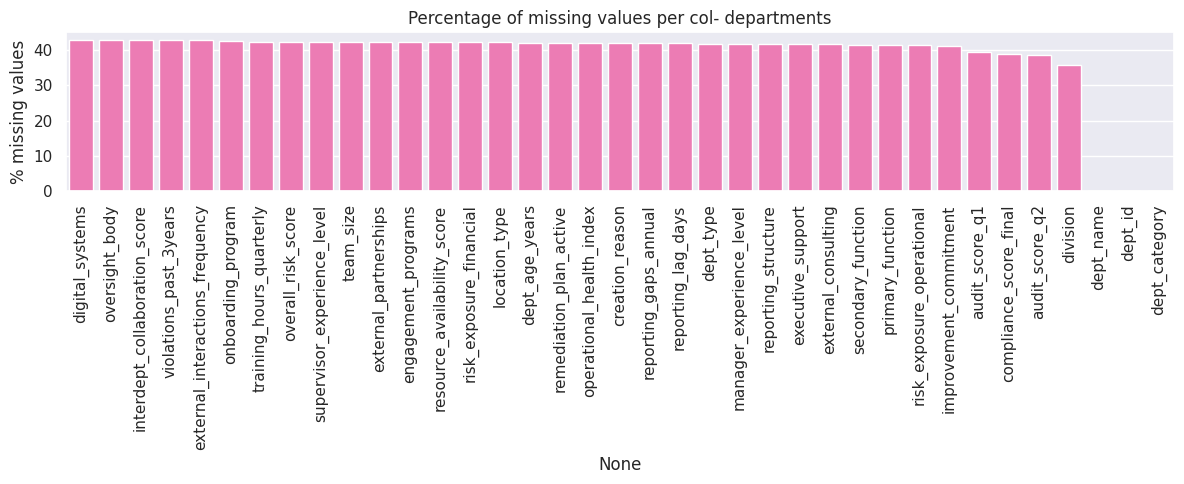

In [ ]:
missing_counts = df_dept.isnull().sum()
missing_perc = (df_dept.isnull().mean() * 100)

missing_df = pd.DataFrame({
    "missing_count": missing_counts,
    "missing_percent": missing_perc
}).sort_values("missing_percent", ascending=False)

plt.figure(figsize=(12, 5))
sns.barplot(x=missing_df.index, y=missing_df["missing_percent"], color="hotpink")
plt.xticks(rotation=90)
plt.ylabel("% missing values")
plt.title("Percentage of missing values per col- departments")
plt.tight_layout()
plt.show()

**What we found**
The missing values are not concentrated in just one or two variables, they are present across various features. The highest missingess appears in digital_systems at 42.88%, and several others with similar levels between 42% to 38%. division has a lower missing rate at 35.83%, although still noticable, this pattern supports an imputation strategy.

**Practical strategy**
Keep most relevant columns, even is there is a significant amount of missing data, it is better to keep it rather than shrinking the data set
Apply a clear imputation strategy, for example:
for numerical variables median/mean
for categorical varuables mode

# **Preprocessing**
In order to prepare the data so that it's ready for clustering, we create **df_model**, which is the 'cleaned data'. To ensure that we do not modify the original dataframe **df_dept** we use .copy().

Since the dataset contains only 709 departments, dropping rows would remove a meaningful share of the organization and could bias the segmentation, we therefore use imputation so risk patterns remain comparable across all departments.

# 1. Imputing numerical features
From scikit-learn we use **SimpleImputer** in order to fill missing values in **num_features**, the numerical columns. We use **SimpleImputer**, intead of KNNImputer, to keep preprocessing transparent and avoid creating values based on 'similar' department. We then replaced each missing valye with the median of that column using **strategy="median"**.

The reason we chose the median is because not only is it less affected by outliers, meaning the imputated value will not be distorted due to the extreme values, but also because it preserves the central value of the distribution helping keep the overall pattern on the data realistic.  


# 2. Cleaning categorical features before imputation
To ensure consistent missing value representation we add a 'cleaning' step before imputing categorical values:
- to avoid problems with **pd.NA**, enforce **object** dtype
- convert empty strings **" "** and **None** into **np.nan**
- made sure to remove extra white space using **.strip()**, when the value is a string

This prevents missplacements where values appear to be missing, but are actually just stored inconsistenly in for example an empty string.



# 3. Imputing categorical features
For **cat_features**, categorical columns, we use a second **SimpleImputer** with **strategy="most_frequent"**, this way, missing values are replaced with the most frequent category in that column, the mode.

# Verification
Finally, we compare **df_dept** and **df_model**, the number of missing values before and after preprocessing. Doing this, will confirm that the dataset is ready for the next steps, and that the selected features in **df_model** don't contain missing values anymore.

In [ ]:
from sklearn.impute import SimpleImputer
df_model = df_dept[id_cols + num_features + cat_features].copy()

num_imputer = SimpleImputer(strategy="median")
df_model[num_features] = num_imputer.fit_transform(df_model[num_features])

for c in cat_features:
    df_model[c] = df_model[c].astype("object")
    df_model[c] = df_model[c].replace({None: np.nan})
    # we only strip if it is a string
    df_model[c] = df_model[c].apply(lambda x: x.strip() if isinstance(x, str) else x)
    df_model[c] = df_model[c].replace({"": np.nan})


cat_imputer = SimpleImputer(strategy="most_frequent")
df_model[cat_features] = cat_imputer.fit_transform(df_model[cat_features])

In [ ]:
before = df_dept.isna().sum()
after  = df_model.isna().sum()

pd.DataFrame({"before": before, "after": after}).query("before>0 or after>0").sort_values("before", ascending=False)

before  after
digital_systems                     304      0
external_interactions_frequency     303      0
violations_past_3years              303      0
oversight_body                      303      0
interdept_collaboration_score       303      0
onboarding_program                  302      0
overall_risk_score                  300      0
team_size                           300      0
external_partnerships               300      0
training_hours_quarterly            300      0
supervisor_experience_level         300      0
engagement_programs                 299      0
risk_exposure_financial             299      0
resource_availability_score         299      0
location_type                       299      0
operational_health_index            298      0
remediation_plan_active             298      0
dept_age_years                      298      0
creation_reason                     297      0
reporting_lag_days                  297      0
reporting_gaps_annual               297      0
executive_support                   296      0
reporting_structure                 296      0
dept_type                           296      0
manager_experience_level            296      0
external_consulting                 295      0
secondary_function                  294      0
primary_function                    293      0
risk_exposure_operational           293      0
improvement_commitment              292      0
audit_score_q1                      279      0
compliance_score_final              276      0
audit_score_q2                      274      0
division                            254      0

# **In summary**
- At first, we measured the percentage of missing values per columns, and abserved that many features contained a large amount of missing data
- We used imputation to preserve the dataset's size
- **Numerical features** were imputed using the median
- **Categorical features** were first cleaned before being imputed, using the mode
- We made sure that **df_model** don't contain any remaining missing values in the selected feature set

# **EDA, Duplicates and Basic Data Sanity Checks**

Becuase during the nunique procedure we could asses that dept_id has 682 unique values out of 709 we decide to verify whether the **departments** table contain:
1. fully duplicated rows, identical across all column
2. **dept_id**, repeated department identifies

why are we doing it? **(interpretation)**

If two rows are identical in every column then they are most likely exact duplicates meaning they can be safely removes.

Instead,dept_id values with different attribute valyes that are repeated are not exact duplicates, this indicates that the same identifier appears in more than one row.

In [ ]:
dup_rows = df_dept.duplicated().sum()
print(" Fully duplicated rows:", dup_rows)

if dup_rows > 0:
    df_dept[df_dept.duplicated()].head()

 Fully duplicated rows: 0


In [ ]:
dup_ids = df_dept["dept_id"].duplicated().sum()
print("Departments with duplicate dept_id:", dup_ids)

if dup_ids > 0:
    df_dept[df_dept["dept_id"].duplicated(keep=False)].sort_values("dept_id").head()

Departments with duplicate dept_id: 27


In [ ]:
dup_depts = df_dept[df_dept["dept_id"].duplicated(keep=False)].sort_values("dept_id")
dup_depts

dept_id                               dept_name  \
34   DEPT-1237                         Alpha Solutions   
350  DEPT-1237           Central Ethics and Compliance   
201  DEPT-2377                          Prime Services   
156  DEPT-2377                South Financial Controls   
624  DEPT-2612                        South Department   
566  DEPT-2612                        Prime Department   
78   DEPT-2743              Compliance - Legacy Region   
269  DEPT-2743                          Regional Group   
322  DEPT-2762                             East Office   
341  DEPT-2762             Emerging Regulatory Affairs   
116  DEPT-2792                        Elite Department   
297  DEPT-2792                          Central Sector   
219  DEPT-2856                    South Audit Services   
618  DEPT-2856                 Premier Risk Management   
400  DEPT-3845             Governance - Premier Region   
510  DEPT-3845                       Global Compliance   
165  DEPT-5023                        Central Division   
154  DEPT-5023                           Legacy Branch   
499  DEPT-5828                        Metro Compliance   
695  DEPT-5828             Compliance - Digital Region   
347  DEPT-5849                         North Solutions   
601  DEPT-5849                          Alpha Services   
651  DEPT-6380                       Legacy Governance   
570  DEPT-6380       Risk Management - Regional Region   
122  DEPT-6883   Regulatory Affairs - Strategic Region   
264  DEPT-6883                               Elite Hub   
595  DEPT-6945                 Premier Risk Management   
630  DEPT-6945               Central Quality Assurance   
68   DEPT-7071                Tactical Risk Management   
636  DEPT-7071       Process Excellence - Metro Region   
182  DEPT-7646        Regulatory Affairs - East Region   
293  DEPT-7646                Prime Regulatory Affairs   
283  DEPT-8159   Business Integrity - Strategic Region   
443  DEPT-8159         Quality Assurance - West Region   
707  DEPT-8168                      Digital Compliance   
450  DEPT-8168               Global Process Excellence   
263  DEPT-8383   Financial Controls - Strategic Region   
292  DEPT-8383         Internal Controls - East Region   
505  DEPT-8429                              East Group   
81   DEPT-8429                       Legacy Department   
83   DEPT-9035                               Metro Hub   
419  DEPT-9035           Digital Ethics and Compliance   
660  DEPT-9204                        Prime Governance   
206  DEPT-9204           Innovation Financial Controls   
553  DEPT-9396                           East Division   
518  DEPT-9396                Compliance - Beta Region   
531  DEPT-9694               Governance - North Region   
59   DEPT-9694  Business Integrity - Innovation Region   
86   DEPT-9694                            Premier Unit   
298  DEPT-9847                       Tactical Services   
374  DEPT-9847                             Global Unit   
702  DEPT-9975                            South Sector   
320  DEPT-9975                     Tactical Department   

              dept_category             division   dept_type  dept_age_years  \
34      Financial_Reporting         Corporate_HQ     Support             8.0   
350     Financial_Reporting         Corporate_HQ  Operations             7.0   
201     Financial_Reporting         Corporate_HQ        None             NaN   
156  Operational_Compliance                 None        None             NaN   
624     Financial_Reporting         Corporate_HQ  Operations             7.0   
566         Risk_Management         Corporate_HQ        None             5.0   
78      Financial_Reporting         Corporate_HQ  Operations             7.0   
269     Financial_Reporting         Corporate_HQ  Operations             8.0   
322         Risk_Management  Regional_Operations        None            14.0   
341     Financial_Reporting         Corporate_HQ  Technology             7

In [ ]:
df_dept.groupby("dept_id")["dept_name"].nunique().sort_values(ascending=False).head(20)

dept_id
DEPT-9694    3
DEPT-5023    2
DEPT-5828    2
DEPT-5849    2
DEPT-9396    2
DEPT-9204    2
DEPT-9035    2
DEPT-6380    2
DEPT-2377    2
DEPT-8429    2
DEPT-8383    2
DEPT-2612    2
DEPT-6945    2
DEPT-7071    2
DEPT-2743    2
DEPT-3845    2
DEPT-2762    2
DEPT-2792    2
DEPT-2856    2
DEPT-8168    2
Name: dept_name, dtype: int64

# Implications for modelling
In the dataset there are no fully duplicated rows, however, some **dept_id** values are not unique, meaning the same identifier appears in various rows with different attributes.

Since some **dept_id** values are not unique, we treat **dept_id**, and **dept_name** only as identifiers and exclude them from modeling features.

So **dept_id** and **dept_name** are both treated only as identifiers because, they are useful for interpreting results, but are not used as clustering or prediction features. Therefore, although some values are not unique, this is mainly small data structure inconsistency rather than something that directly impacts the models.

# **Univariate EDA, Numercial and Categorical Features**

# What we do in practice
For **num_features**, numerical variables:
- use **describe()** in order to summarize key statistics:
  - minimum and maximum
  - mean
  - standard deviation
  - quartiles
- plot **histograms** to help understand the shape of each distribution, for example:
  - symmetric or skewed
  - long tails
- plot **boxplots** so that potential outliers can be identified more clearly

For **cat_features**, categorical features:
- use **value_counts()** with percentages to see how balanced each category is
- create **bar charts**, countplots, to visualize the most frequent categories

In [ ]:
num_summary = df_model[num_features].describe().T  # T = transpose (for easier reading)
num_summary
df_model[num_features].nunique().sort_values()

remediation_plan_active             2
executive_support                   2
external_partnerships               2
digital_systems                     2
improvement_commitment              2
onboarding_program                  2
engagement_programs                 2
external_consulting                 2
supervisor_experience_level         5
manager_experience_level            5
interdept_collaboration_score       5
reporting_lag_days                  5
resource_availability_score         5
risk_exposure_financial             5
risk_exposure_operational           5
external_interactions_frequency     5
operational_health_index            5
violations_past_3years              6
dept_age_years                     14
reporting_gaps_annual              28
training_hours_quarterly           46
audit_score_q1                     63
compliance_score_final             65
audit_score_q2                     67
overall_risk_score                 86
dtype: int64

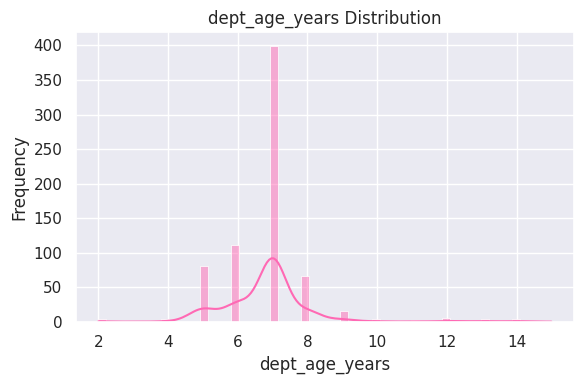

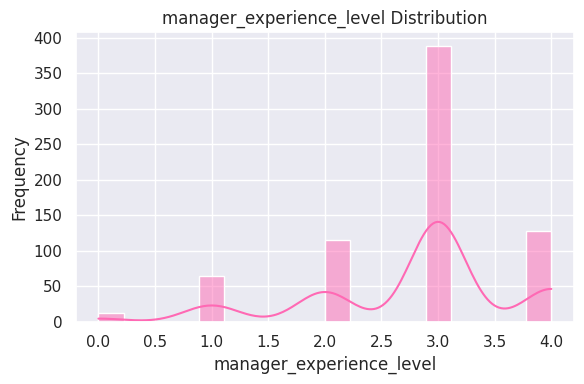

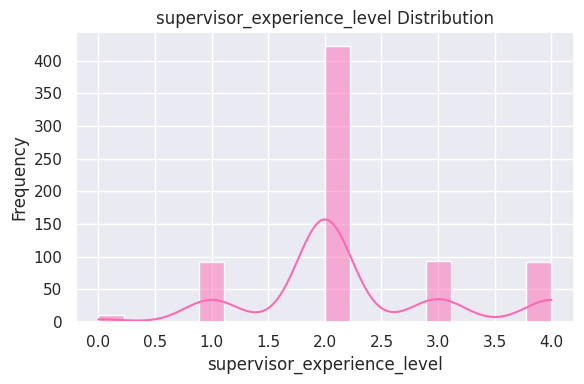

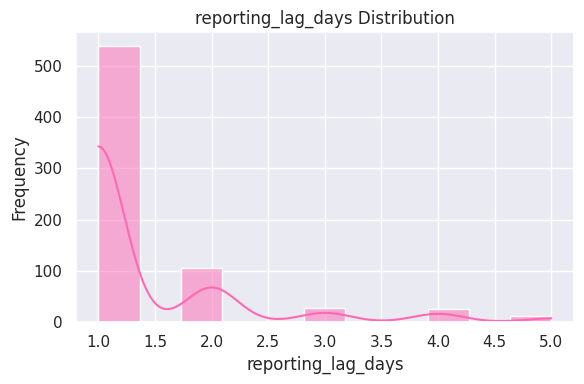

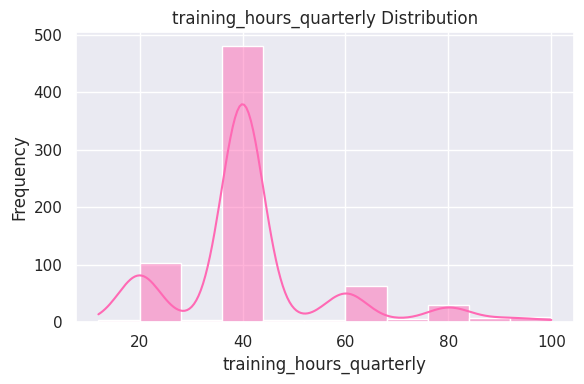

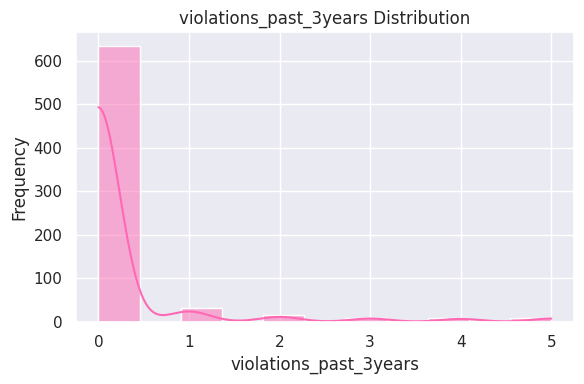

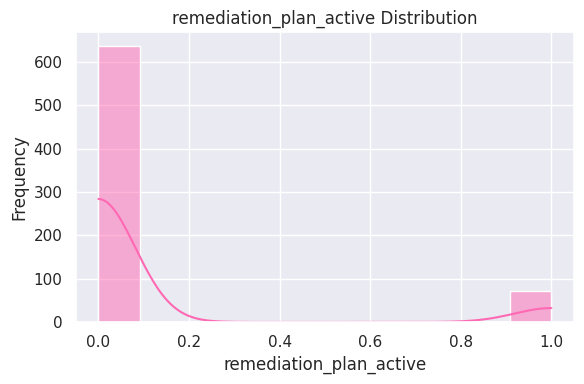

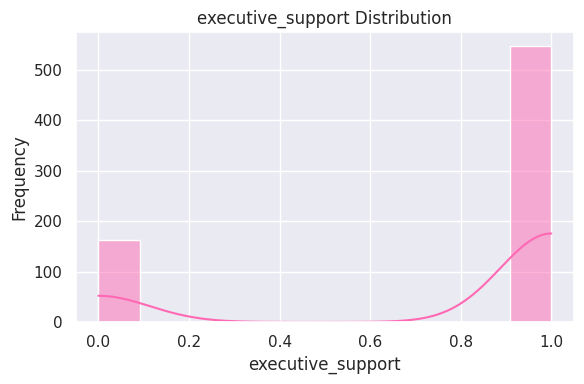

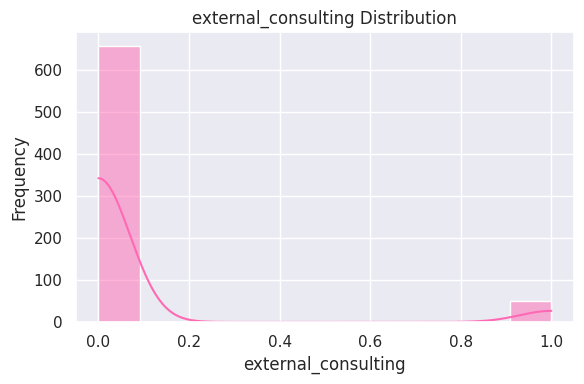

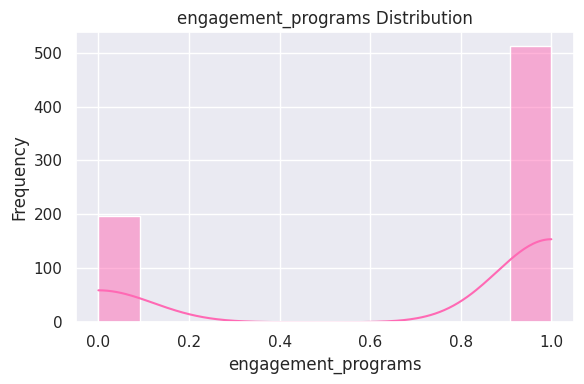

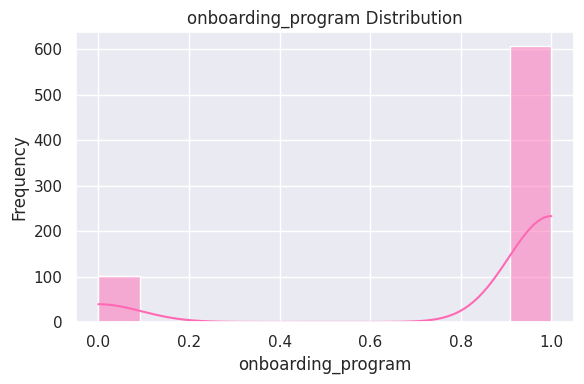

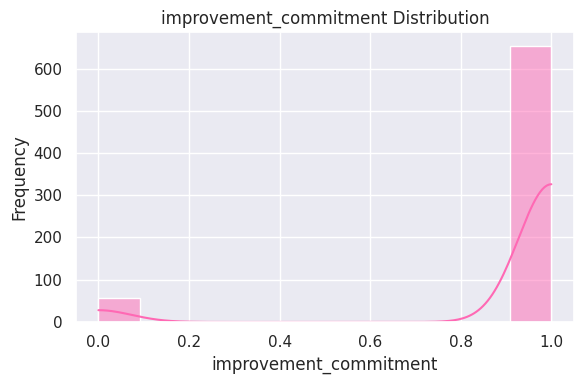

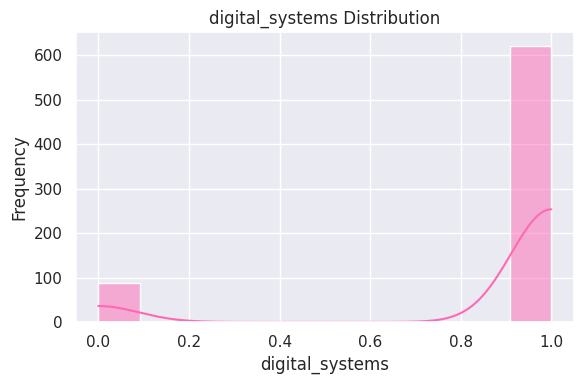

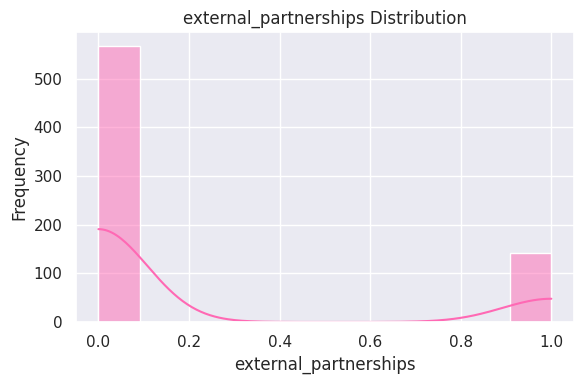

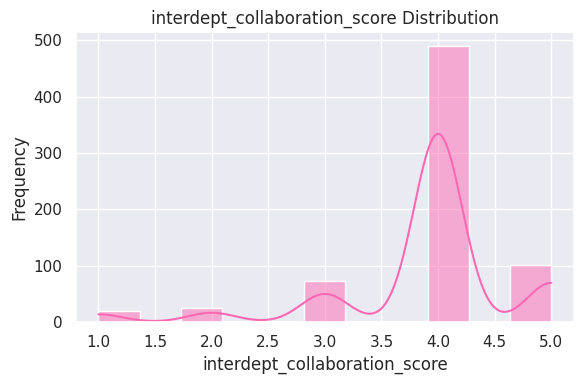

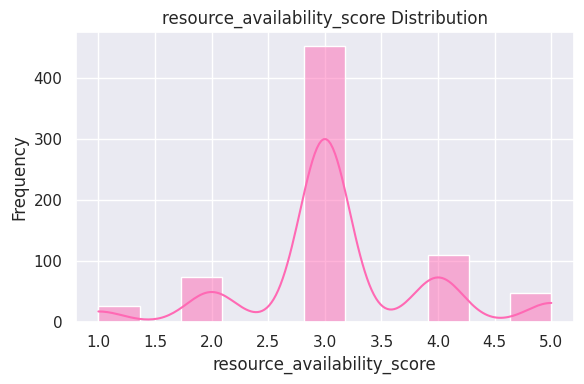

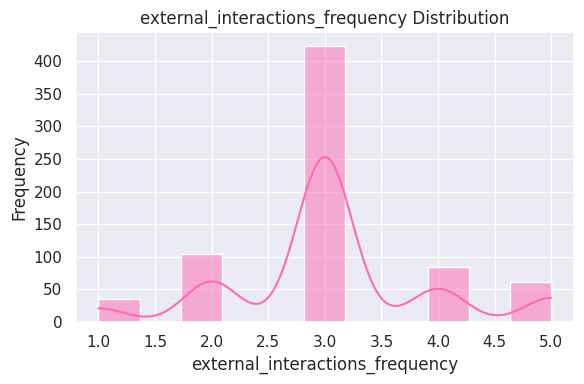

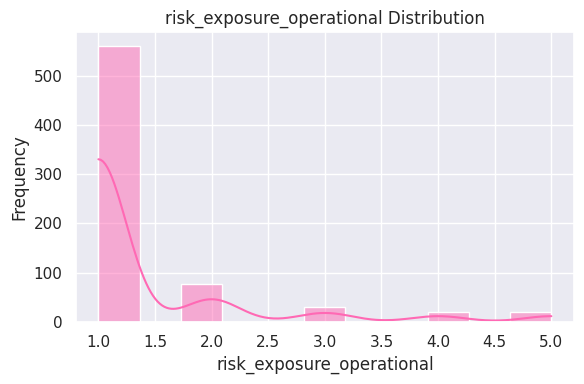

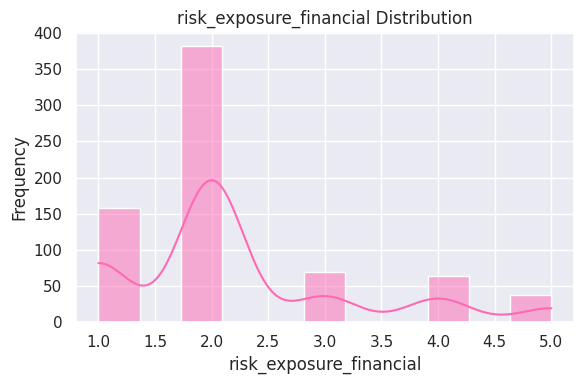

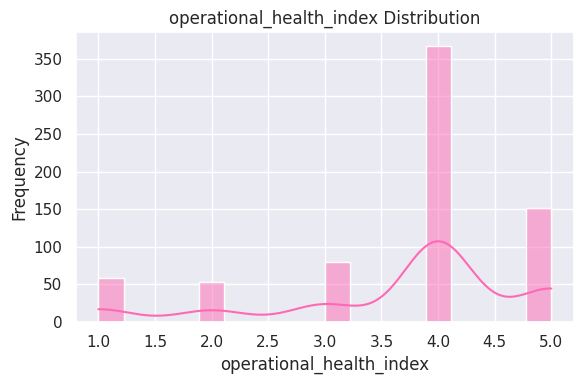

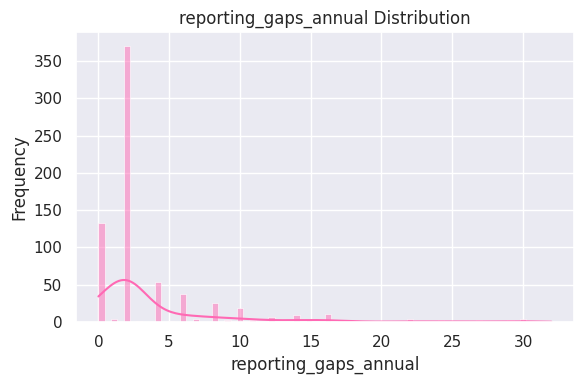

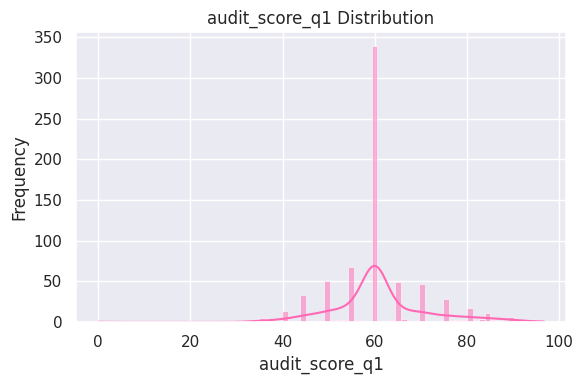

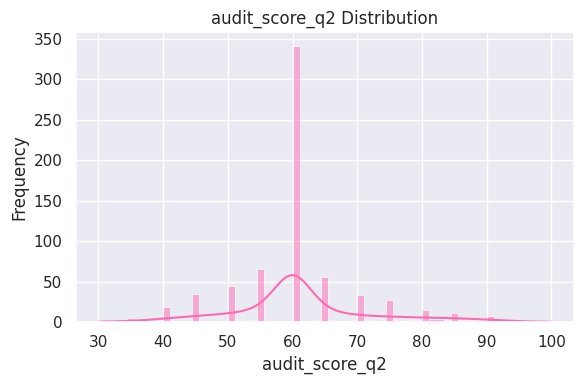

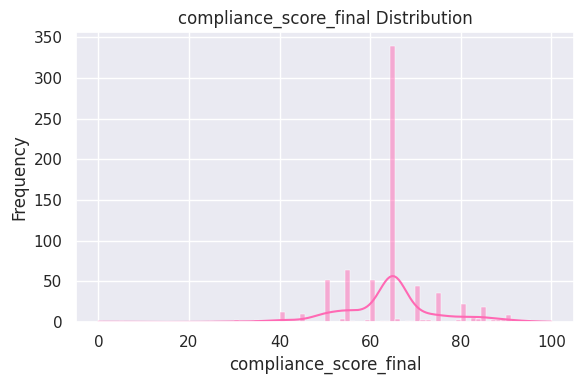

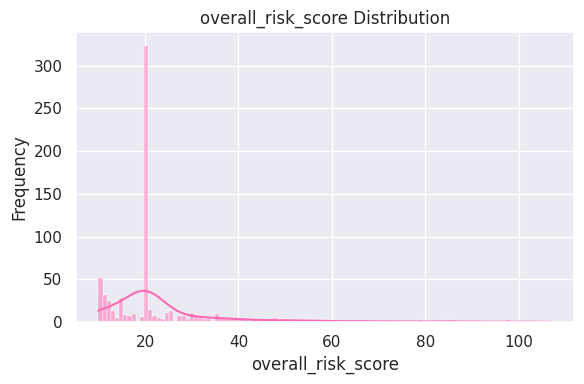

In [ ]:
for col in num_features:
    plt.figure(figsize=(6, 4))
    sns.histplot(df_model[col], kde=True, color="hotpink")
    plt.title(f"{col} Distribution")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

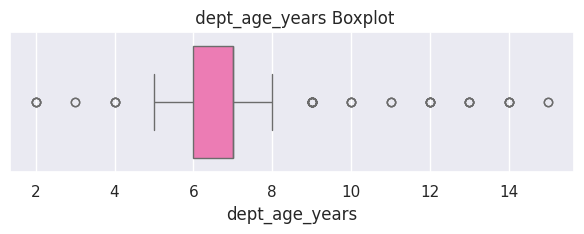

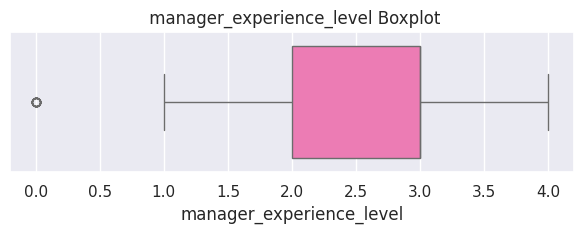

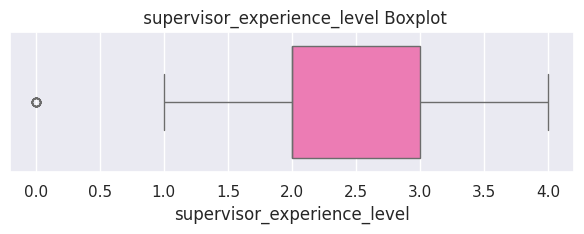

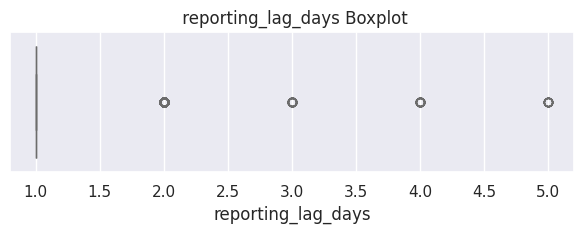

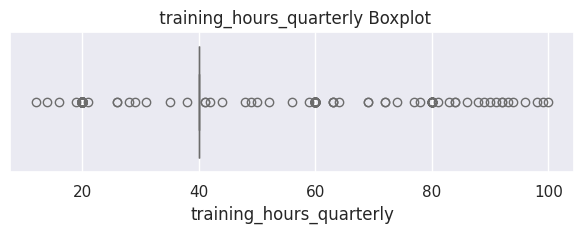

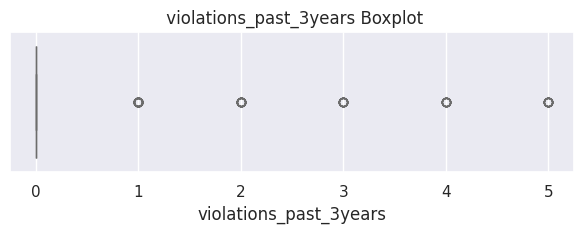

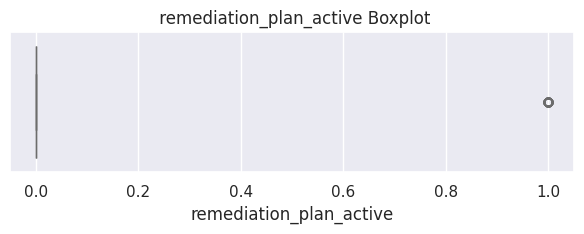

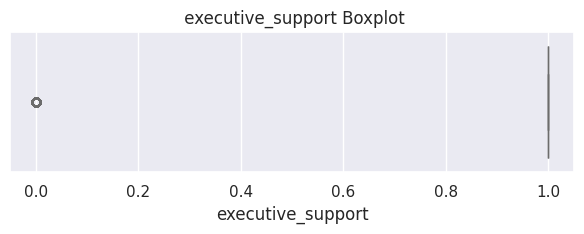

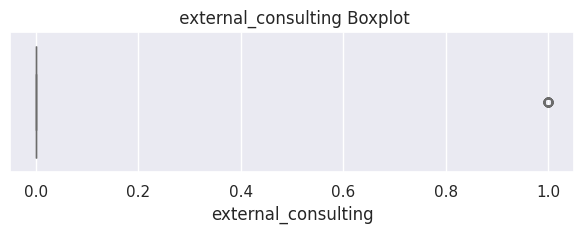

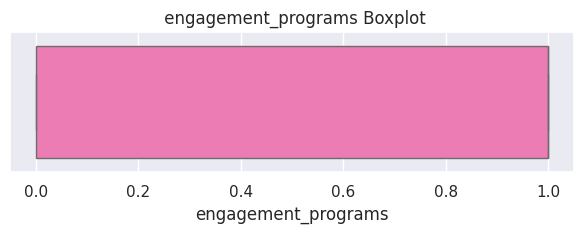

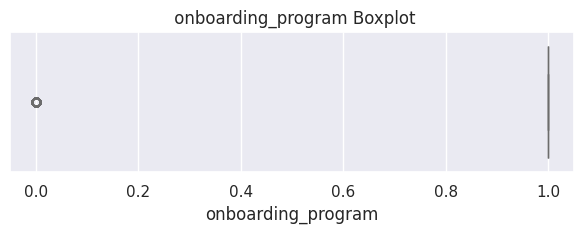

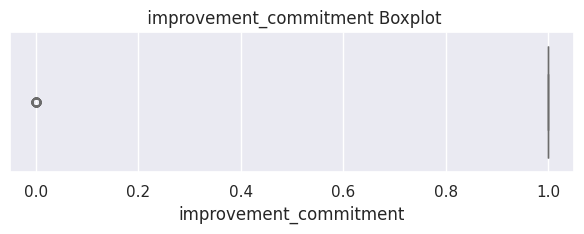

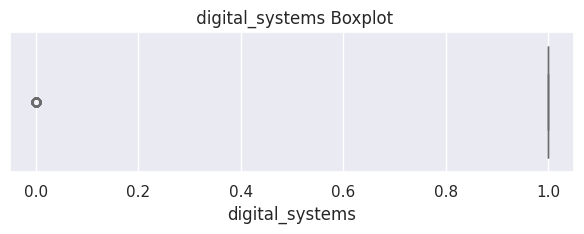

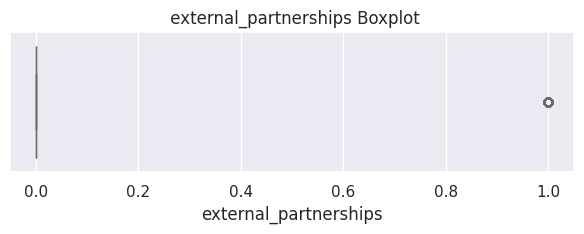

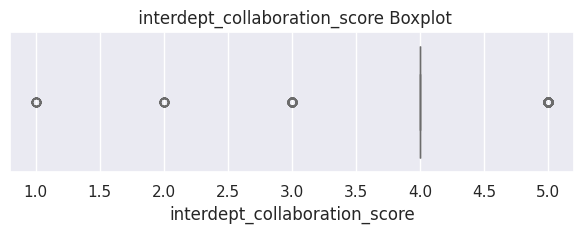

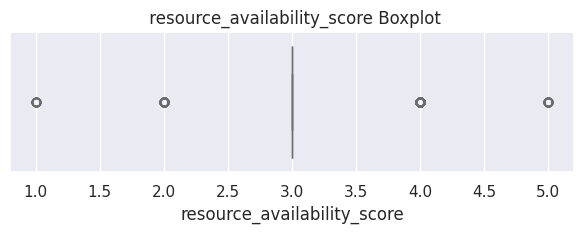

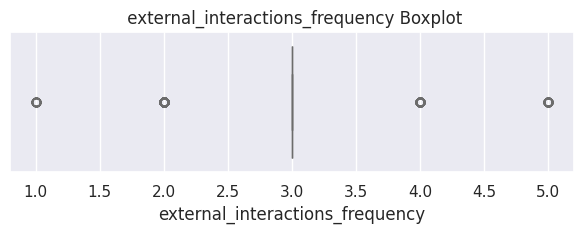

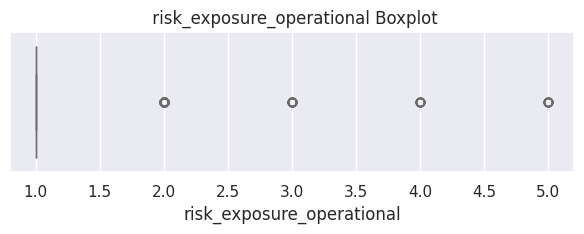

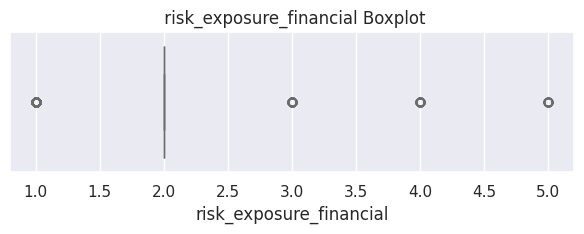

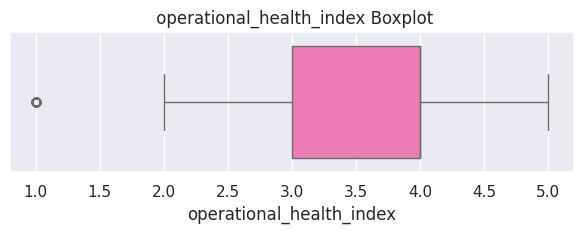

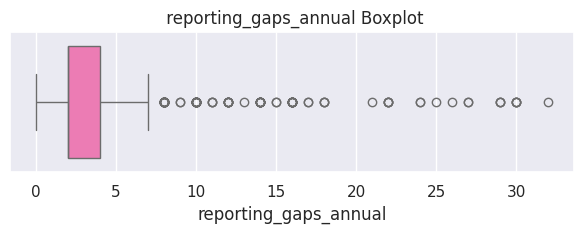

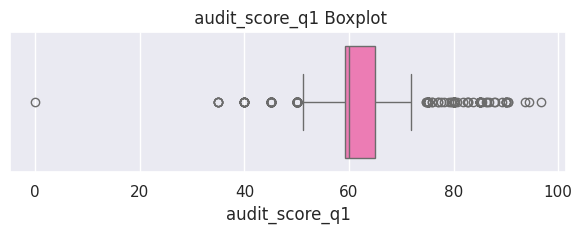

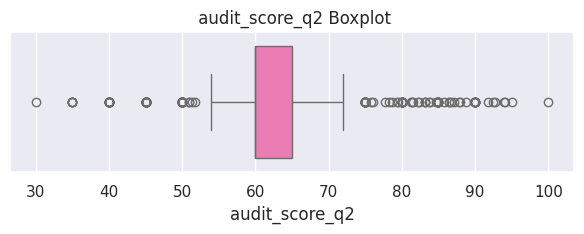

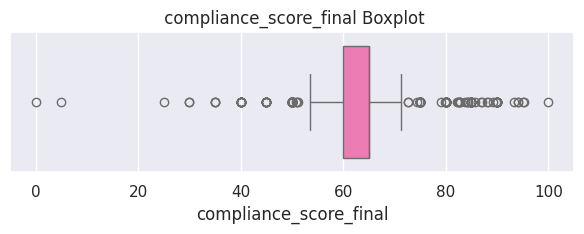

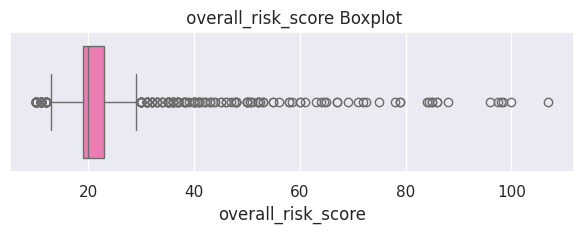

In [ ]:
for col in num_features:
    plt.figure(figsize=(6, 2.5))
    sns.boxplot(x=df_model[col], color="hotpink")
    plt.title(f" {col} Boxplot")
    plt.xlabel(col)
    plt.tight_layout()
    plt.show()

In [ ]:
for col in cat_features:
    print(f"\n=== {col} ===")
    vc = df_model[col].value_counts(dropna=False)
    perc = (vc / len(df_model) * 100).round(1)
    cat_df = pd.DataFrame({"count": vc, "percent": perc})
    display(cat_df)


=== dept_category ===


count  percent
dept_category                         
Financial_Reporting       419     59.1
Operational_Compliance    266     37.5
Risk_Management            24      3.4


=== division ===


count  percent
division                           
Corporate_HQ           682     96.2
Regional_Operations     27      3.8


=== dept_type ===


count  percent
dept_type                 
Support       502     70.8
Operations    150     21.2
Technology     18      2.5
Finance        14      2.0
Legal          14      2.0
Compliance     11      1.6


=== location_type ===


count  percent
location_type                
Urban            603     85.0
Remote            81     11.4
International     13      1.8
Suburban          12      1.7


=== team_size ===


count  percent
team_size                
Large        572     80.7
Small        118     16.6
Medium        19      2.7


=== reporting_structure ===


count  percent
reporting_structure                
Centralized            628     88.6
Autonomous              66      9.3
Hybrid                  15      2.1


=== primary_function ===


count  percent
primary_function                
Other               439     61.9
Operations          100     14.1
Administrative       64      9.0
Compliance           47      6.6
Finance              39      5.5
Technology           10      1.4
Legal                10      1.4


=== secondary_function ===


count  percent
secondary_function                
Other                 506     71.4
Operations            105     14.8
Compliance             42      5.9
Finance                25      3.5
Administrative         18      2.5
Legal                   9      1.3
Technology              4      0.6


=== creation_reason ===


count  percent
creation_reason                
Regulation         453     63.9
Expansion          104     14.7
Restructuring      103     14.5
Merger              36      5.1
Innovation          13      1.8


=== oversight_body ===


count  percent
oversight_body                    
Internal_Audit        579     81.7
External_Auditor       87     12.3
Compliance_Officer     35      4.9
Board_Committee         8      1.1

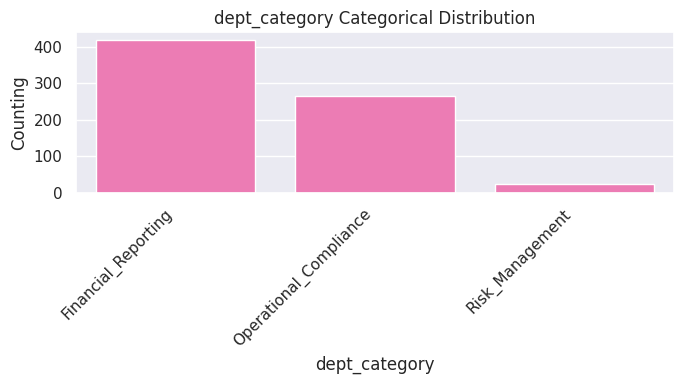

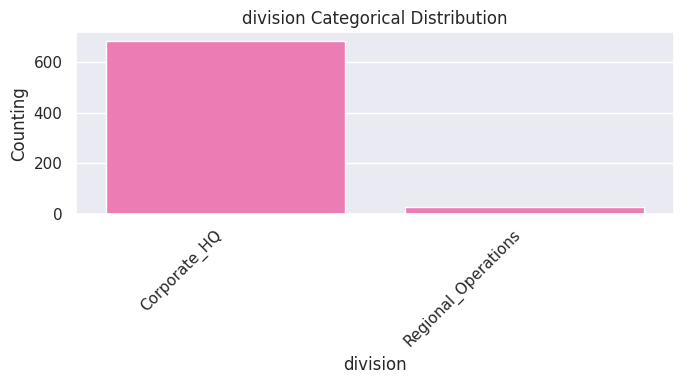

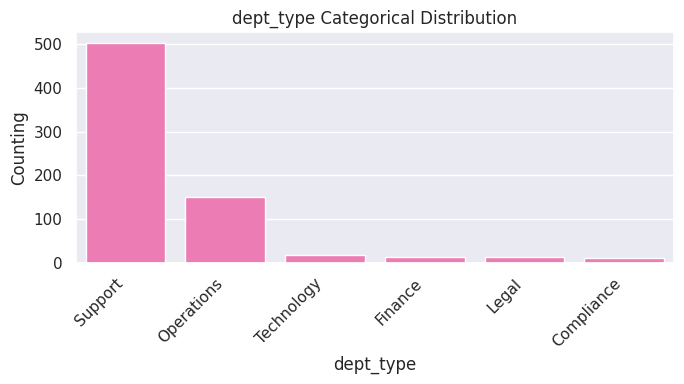

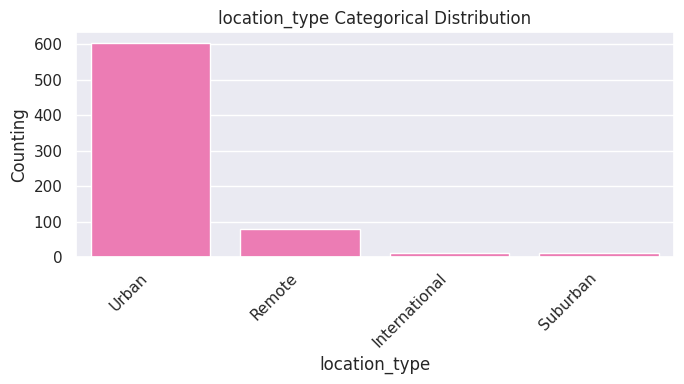

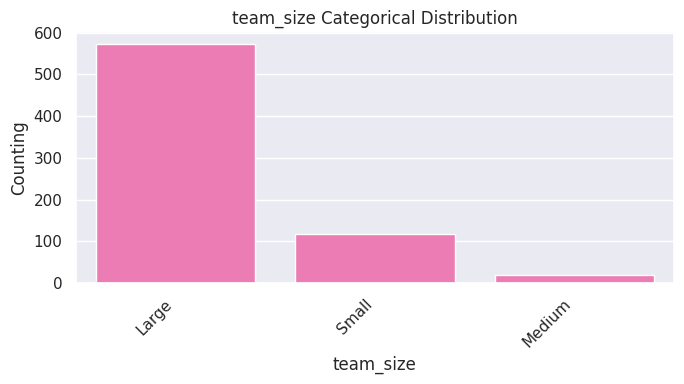

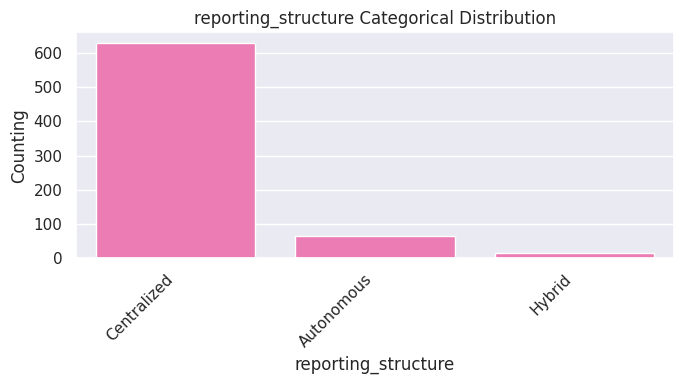

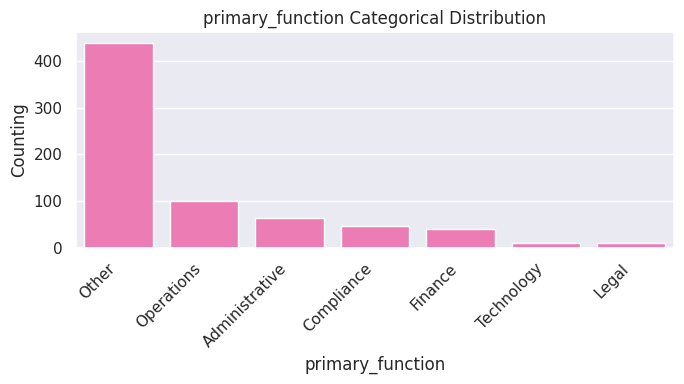

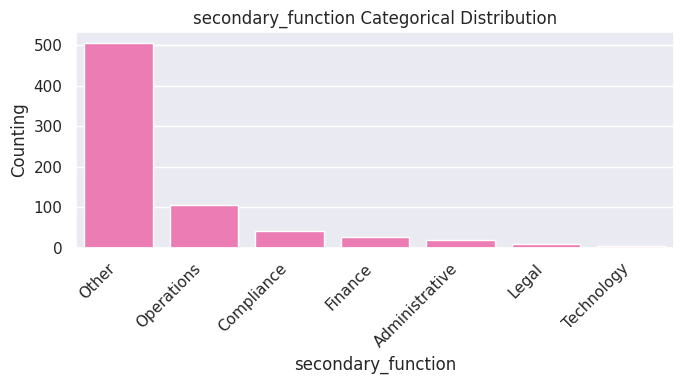

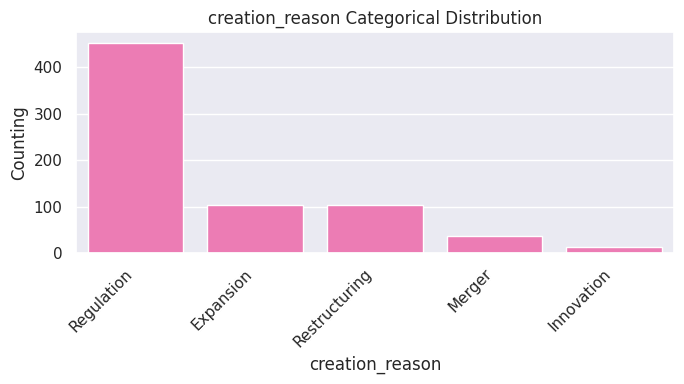

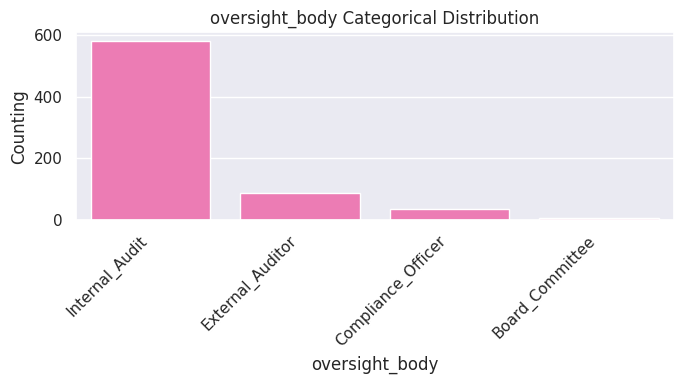

In [ ]:
for col in cat_features:
    plt.figure(figsize=(7, 4))
    order = df_model[col].value_counts().index
    sns.countplot(data=df_model, x=col, order=order, color="hotpink")
    plt.title(f"{col} Categorical Distribution")
    plt.xlabel(col)
    plt.ylabel("Counting")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

# Why this matters for clustering
Before clustering, univariate analysis is crucial because it helps understand each feature and how it may affect distance-based methods:
- variables that have **long tails** or that are **highly skewed** could benefit from transformations for instance log or square root, or may have a heavier weight when computing distances
- variables with **very different ranges** prove the need for scaling, if not, features with large ranges would dominate the clustering
- extreme **outliers** may shift the cluster centers towards unusually large or small values and cause less accurate or meaningful clustering results, especially for centroid-based methods, like k-means
- categorical variables, where some categories either appear almost all or the time, or are extremely rare add little useful insight so they may be merged into broader groups or simply left out
- categorical variables that have a well balanced and small set of common categories are more easily represented and good candidates for one-hot encoding

This step helps us understand the distribution and category structure rather than creating clusters 'blindly' so this way we end up using features that are easy to interpret, properly cleaned, and ready for clustering

# **EDA Outliers Analysis**
At this stage our goals are:
- **quantify** for each numerical variable how many outliers there are, not only visually seeing them
- due to some variables being expected to produce extreme values more frequently, we have to understand where outliers are concentrated, this happens more frequently for count variables like **violations_past_3years**

# Where we expect outliers
Based on the boxplots and histograms, outliers are most likely to appear in the following variables:
- **violations_past_3years**: many departments have low values, some even close to 0, with only a small number showing higher counts
- **reporting_gaps_annual**: most departments have some gaps, but a small amount of them have atypically high numbers
- **training_hours_quarterly**: some departments show much higher or lower training activity, although most values cluster around typical training levels
- **overall_risk_score, audit_score_q1 and q2, compliance_score_final**: may also show extreme cases and show tails

These outliers can represent depatments with unsually high risk or poor compliance performance, they are not errors. These cases are the ones we want to be able to identify in order to them understand them.

# Decision: keep outliers
We decided **not to remove outliers** as their removal can hide the most critical departments and reduce the usefulness of clustering for compliance monitoring, because in compliance and risk contexts, extreme values may represent genuinely problematic departments rather than measurement errors, removing them would reduce the model’s ability to flag atypical risk profiles, so instead we:
- **document** the presence of highly skewed distributions and extreme departments
- rely on **scaling**
- since we keep outliers, **StandardScaler** could put more emphasis on extreme values so, we accept this trade off for feature comparability
- consider transformation for strongly skewed count variables during modelling, only if needed

# **Correlations Between Numerical Variables**

The next step is to analyze the correlations among **num_features**, the numerical features.
- compute the **correlation matrix** for all numerical variables
- use a **heatmap** to visualize it
- use the heatmap to identify **pairs or groups** of variables that are **highly correlated**, >= 0.8

# Why this matters for clustering
Clustering methods, like k-meanes, based on distances may be affected by redundant features. Therefore if two variables carry almost the same information, for instance like **audit_score_q1** and **audit_score_q2**, inclding both does not add significant new information, but rather can give extra unecessary importance to that information, making it count twice in the distance calculation.

By checking correlation we are able to:
- identify **redundant** or overlapping features
- understand which variables move together
- later decide, wether to keep just one variable from a highly correlated group, or interpret clustering results keeping this redundancy in mind

# Why this matters for classification
Highly correlated variables can also affect a classification model, but how much depends on the algorithm and on what you care about:

- **Redundancy**

-**Feature importance can be misleading**:
models may arbitrarily “credit” one correlated feature over another, so importance rankings aren’t reliable.

-**Possible overfitting**


# Visualization choice
We set **annot=False** because it becomes difficult to read the heatmap when there are many features as every call value would be displayed.

In [ ]:
# Correlation matrix among the numerical features
corr_matrix = df_model[num_features].corr()

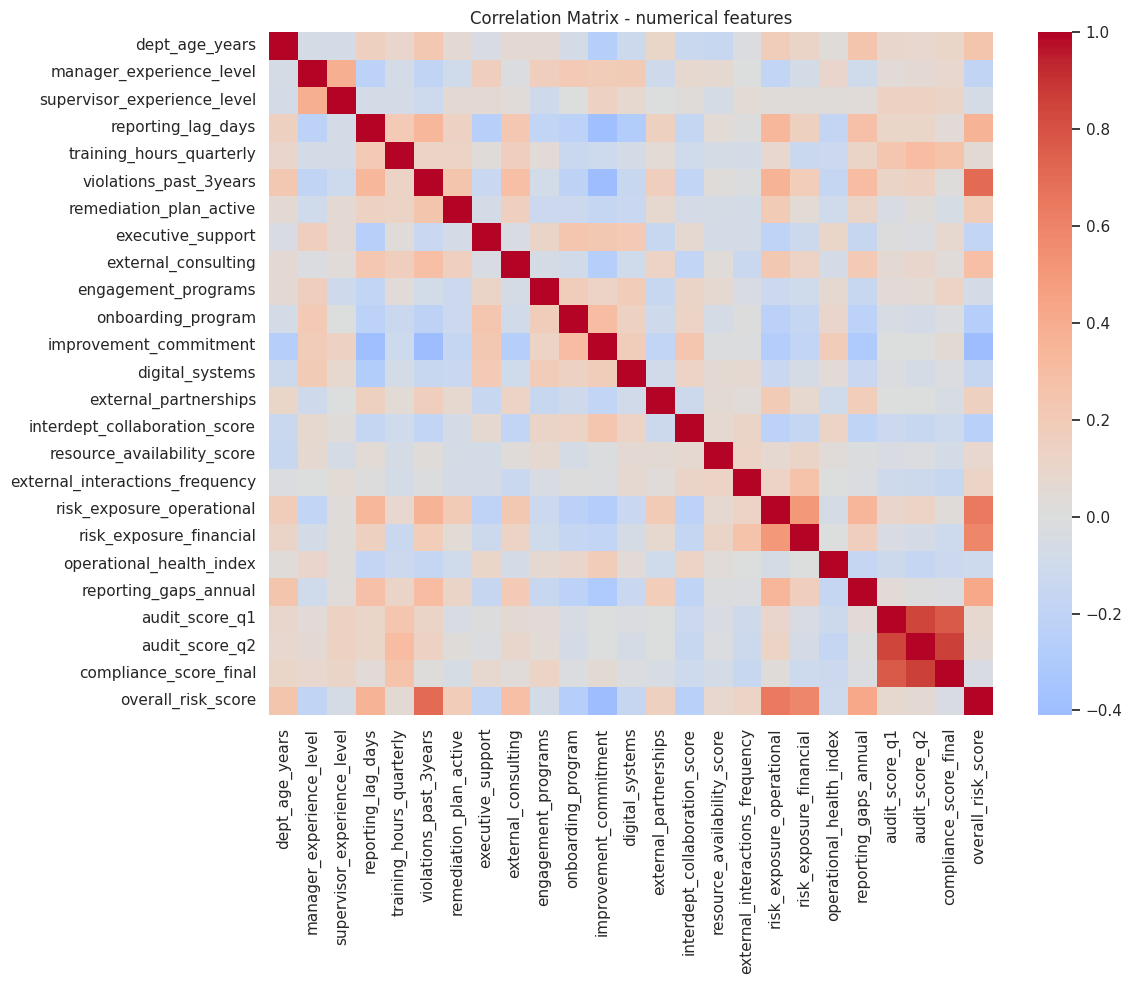

In [ ]:
plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_matrix,
    annot=False,
    cmap="coolwarm",
    center=0
)
plt.title("Correlation Matrix - numerical features")
plt.tight_layout()
plt.show()

# **Correlation Results**

# What the heapmap shows
In the correlation heatmap, most cells are very light, indicating that many numerical variables have weak corrlations with eachother. This suggests that a large part of the feature set provides relatively independent information.

In th bottom right, there is a noticeably darker block which corresponds to **audit_score_q1, audit_score_q2, compliance_score_final,** and **overall_risk_score** which tend to'move together' and group more in comparison to the other features.

The main correlation structure is concentrated amongst the score variables, whilst most other numerical features are not strongly correlated.

In [ ]:
# "High" correlation threshold
threshold = 0.8

high_corr_pairs = []

for col1 in num_features:
    for col2 in num_features:
        if col1 < col2:
            corr_val = corr_matrix.loc[col1, col2]
            if abs(corr_val) >= threshold:
                high_corr_pairs.append({
                    "feature_1": col1,
                    "feature_2": col2,
                    "corr": corr_val
                })

high_corr_df = pd.DataFrame(high_corr_pairs).sort_values(
    "corr",
    ascending=False
)

high_corr_df

feature_1               feature_2      corr
1  audit_score_q2  compliance_score_final  0.861647
0  audit_score_q1          audit_score_q2  0.841087

# Pairs with very high correlation: **high_corr_df**

To indentify redundant features we extract variable pairs with **absolute correlation >= 0.8**, using this threshold, only two pairs go beyond:
- **audit_score_q2** paired with **compliance_score_final** which have a correlation of apploximately 0.86
- **audit_score_q1** paired with **audit_score_q2** which have a correlation of approximately 0.84

therefore, only these pairs shows a very strong linear relationship, while the other variables including the scors, do not go beyond the 0.8 threshold.

# Interpretation
- **audit_score_q1** and **audit_score_q2** provide similar information, two quarterly audit results that are strongly aligned
- **audit_score_q2** is also strongly correlated with **compliance_score_final**, all of this is consistent with thw idea that better audit performance tends to align with stronger final compliance outcomes

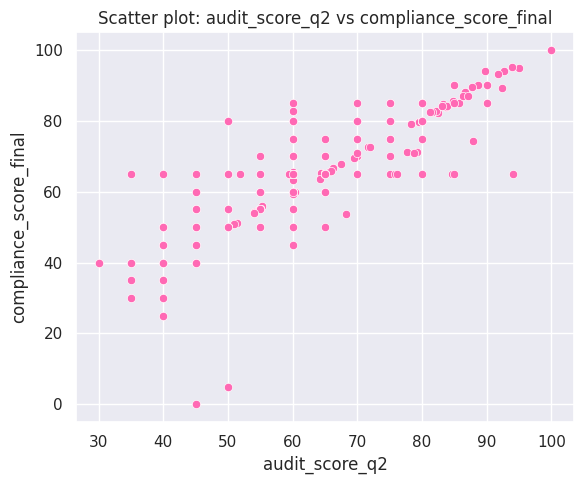

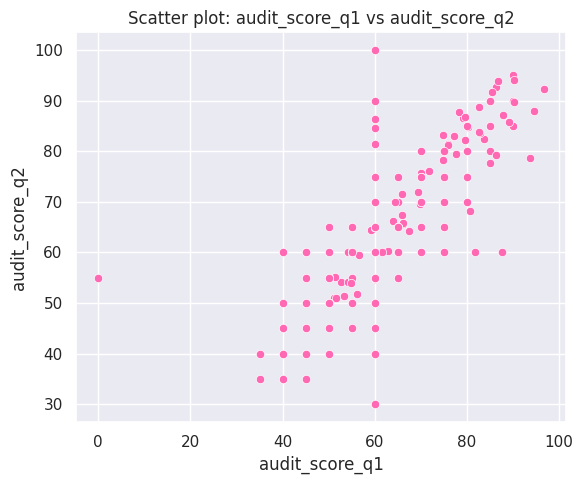

In [ ]:
pair_example = ("audit_score_q2", "compliance_score_final")

x_col, y_col = pair_example

plt.figure(figsize=(6, 5))
sns.scatterplot(data=df_model, x=x_col, y=y_col, color="hotpink")
plt.title(f"Scatter plot: {x_col} vs {y_col}")
plt.tight_layout()
plt.show()


pair_example = ("audit_score_q1", "audit_score_q2")

x_col, y_col = pair_example

plt.figure(figsize=(6, 5))
sns.scatterplot(data=df_model, x=x_col, y=y_col, color="hotpink")
plt.title(f"Scatter plot: {x_col} vs {y_col}")
plt.tight_layout()
plt.show()

# Scatter plot
To complement the correlation table we decided to create scatter plots for the two most correlated pairs. These plots provide a visual representation of the relationship between the pairs, in order to confirm that it is indeed real and not simply a signle correlation number.
- **audit_score_q2** and **compliance_score_final**: the points follow a clear upward trend, this means the departments with higher Q2 audit scores tend t o also have higher final comopliance scores
- **audit_score_q1** and **audit_score_q2**: here we have again an upward trend, meaning departments that score highly in Q1 usually also score highly in Q2

The scatter plots are able to confirm the strong positive correlations seen in **high_corr_df**.


# **Feature Selection**

# Purpose
Based on the distributions, outliers, and correlation analysis, we decided to run clustering on a reduced and interpretable feature set instead of including every availavle variable. The aim is to keep the clustering focused on dimensions that directly describe a department's risk or compliance profile, while simultaneously avoiding redundancy and features that would make interpretatio challenging.

# Selected features
**Numerical features** capturing risk and operational conditions:
- **risk_exposure_operational, risk_exposure_financial**
- **operational_health_index**
- **violations_past_3years, reporting_gaps_annual, reporting_lags_days**
- **training_hours_quarterly**

**Categorical freatures** describing department structure:
- **dept_category, division, team_size, dept_type**

This produces **X_clusters**, a compact input matrix, that improves intrepretability, while also remaining detailed enough for profiling.



# Why some variables are excluded
Sme variables are purpusefully excluded from clustering, these are the three main reasons:
1. **Redundancy and potential leakage**: audit scores, **audit_score_q1** and **audit_score_q2** are highly. correlated with **compliance_score_final** and may act as an indicator of the final compliance outcome. Clustering can be driven by outcome like variables, in order to avoid thiswe exclude both audit score and **compliance_score_final** from the clustering input.
2. **Low informational value**: some binary indicators like **remediation_plan_active, executive_support,** and **external_consulting**, are very imbalanced and close to constant. They add little structure to clustering, they are mainly kept for after creating the clusters, so that we can analyze their characteristics in order to understand them.
3. **High cardinality or overly descriptive categorical variables**: variables like **primary_function, secondary_function, creation_reason, oversight_body, location_type,** and **reporting_structure** would generate various sparase dummy variables and reduce interpretability. Therefore, we use then to describe clusters **after clustering**, not to construct them.

In [ ]:
df_fe = df_model.copy()

num_for_clustering = [
    "risk_exposure_operational",
    "risk_exposure_financial",
    "operational_health_index",
    "violations_past_3years",
    "reporting_gaps_annual",
    "reporting_lag_days",
    "training_hours_quarterly",
]

cat_for_clustering = [
    "dept_category",
    "division",
    "team_size",
    "dept_type"
]


features_for_clustering = num_for_clustering + cat_for_clustering

print("Numerical features for clustering:", num_for_clustering)
print("Categorical features for clustering:", cat_for_clustering)


#Subset of the dataframe with only the selected columns
X_cluster = df_fe[features_for_clustering].copy()

print("\nShape di X_cluster:", X_cluster.shape)
X_cluster.head()


Numerical features for clustering: ['risk_exposure_operational', 'risk_exposure_financial', 'operational_health_index', 'violations_past_3years', 'reporting_gaps_annual', 'reporting_lag_days', 'training_hours_quarterly']
Categorical features for clustering: ['dept_category', 'division', 'team_size', 'dept_type']

Shape di X_cluster: (709, 11)


risk_exposure_operational  risk_exposure_financial  \
0                        1.0                      2.0   
1                        2.0                      2.0   
2                        1.0                      2.0   
3                        1.0                      1.0   
4                        1.0                      1.0   

   operational_health_index  violations_past_3years  reporting_gaps_annual  \
0                       5.0                     0.0                    2.0   
1                       1.0                     1.0                   26.0   
2                       4.0                     0.0                    2.0   
3                       5.0                     0.0                    2.0   
4                       5.0                     0.0                    2.0   

   reporting_lag_days  training_hours_quarterly           dept_category  \
0                 1.0                      40.0     Financial_Reporting   
1                 1.0                      20.0     Financial_Reporting   
2                 1.0                      40.0  Operational_Compliance   
3                 1.0                      60.0     Financial_Reporting   
4                 2.0                      40.0     Financial_Reporting   

       division team_size   dept_type  
0  Corporate_HQ     Large  Operations  
1  Corporate_HQ     Large  Compliance  
2  Corporate_HQ     Large     Support  
3  Corporate_HQ     Large     Support  
4  Corporate_HQ     Small  Operations

# **Encoding Categorical Variables: One-Hot Encoding**
Clustering algorithms like k-means, require numerical inputs, meaning categorical features must be converted into a numeric representation. For the clustering step, we encode these selected categorical variables:
- **dept_category**
- **division**
- **team_size**
- **dept_type**

#Why one-hot encoding?
- the number of categories is small
- it prevents 'numeric meaning', if we coded categories as 1, 2, 3 etc, the algorithms would interpret the 3 as bigger than 1, that gap is meaningful  
- it works well with distance operations, departments either match and are in the same group, or they don't, this is a clean way to include categorical information in similarity or distance based clustering
- it doesn't create assumptions about the information, like if categories are ordered or equally spaced
- it stays interpretable, the resulting columns, like **team_size_small**, make it easy to explain what drives cluster differenes

With one-hot encoding each category level becomes its own binary (0 or 1) column, like **team_size_Small, team_size_Medium, team_size_Large**, these new dummy variables are then combined with the selected numerical features to build the final clustering input matrix.

In [ ]:
from sklearn.preprocessing import OneHotEncoder

X_cluster = df_fe[features_for_clustering].copy()
categorical_cols = cat_for_clustering

encoder = OneHotEncoder(
    handle_unknown="ignore",
    sparse_output=False,
    drop=None
)

encoded_cat = encoder.fit_transform(X_cluster[categorical_cols])

encoded_cat_df = pd.DataFrame(
    encoded_cat,
    columns=encoder.get_feature_names_out(categorical_cols),
    index=X_cluster.index
)

X_num = X_cluster[num_for_clustering]

# we are merging numerical and encoded categorical features
X_encoded = pd.concat([X_num, encoded_cat_df], axis=1)

print("Shape after One-Hot Encoding:", X_encoded.shape)
X_encoded.head()

Shape after One-Hot Encoding: (709, 21)


risk_exposure_operational  risk_exposure_financial  \
0                        1.0                      2.0   
1                        2.0                      2.0   
2                        1.0                      2.0   
3                        1.0                      1.0   
4                        1.0                      1.0   

   operational_health_index  violations_past_3years  reporting_gaps_annual  \
0                       5.0                     0.0                    2.0   
1                       1.0                     1.0                   26.0   
2                       4.0                     0.0                    2.0   
3                       5.0                     0.0                    2.0   
4                       5.0                     0.0                    2.0   

   reporting_lag_days  training_hours_quarterly  \
0                 1.0                      40.0   
1                 1.0                      20.0   
2                 1.0                      40.0   
3                 1.0                      60.0   
4                 2.0                      40.0   

   dept_category_Financial_Reporting  dept_category_Operational_Compliance  \
0                                1.0                                   0.0   
1                                1.0                                   0.0   
2                                0.0                                   1.0   
3                                1.0                                   0.0   
4                                1.0                                   0.0   

   dept_category_Risk_Management  ...  division_Regional_Operations  \
0                            0.0  ...                           0.0   
1                            0.0  ...                           0.0   
2                            0.0  ...                           0.0   
3                            0.0  ...                           0.0   
4                            0.0  ...                           0.0   

   team_size_Large  team_size_Medium  team_size_Small  dept_type_Compliance  \
0              1.0               0.0              0.0                   0.0   
1              1.0               0.0              0.0                   1.0   
2              1.0               0.0              0.0                   0.0   
3              1.0               0.0              0.0                   0.0   
4              0.0               0.0              1.0                   0.0   

   dept_type_Finance  dept_type_Legal  dept_type_Operations  \
0                0.0              0.0                   1.0   
1                0.0              0.0                   0.0   
2                0.0              0.0                   0.0   
3                0.0              0.0                   0.0   
4                0.0              0.0                   1.0   

   dept_type_Support  dept_type_Technology  
0                0.0                   0.0  
1                0.0                   0.0  
2                1.0                   0.0  
3                1.0                   0.0  
4                0.0                   0.0  

[5 rows x 21 columns]

After encoding, the dataset expands from the original feature set to 21 columns, producing an input matrix, **X_encoded**, of shape (709, 21)

# **Feature Scaling**
Distance based clustering methods are very sensitive to the features' scale, if variables are on very different ranges, those with larger values can have a much stronger unfluence on the distance calculation, this can lead to bias in the clustering results.

For this reason we apply **StandardSclaer** only to the numerical features. This:
- centers each numerical feature around 0, subtracting the mean
- scales it to have unit variance, dividing by the standard deviation, so that numerical variables becomes comparable in magnitude

We do not scale the one-hot encoded dummy variables because they are already on the same scale and scaling them would make rare categories have a disproportionate influence.



In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_num_scaled = pd.DataFrame(
    scaler.fit_transform(X_num),
    columns=X_num.columns,
    index=X_num.index
)

X_ready = pd.concat([X_num_scaled, encoded_cat_df], axis=1)
print("Final shape (X_ready):", X_ready.shape)
X_ready.head()

Final shape (X_ready): (709, 21)


risk_exposure_operational  risk_exposure_financial  \
0                  -0.432401                -0.198877   
1                   0.662499                -0.198877   
2                  -0.432401                -0.198877   
3                  -0.432401                -1.151603   
4                  -0.432401                -1.151603   

   operational_health_index  violations_past_3years  reporting_gaps_annual  \
0                  1.147048               -0.288522              -0.348490   
1                 -2.396557                0.867197               4.273416   
2                  0.261147               -0.288522              -0.348490   
3                  1.147048               -0.288522              -0.348490   
4                  1.147048               -0.288522              -0.348490   

   reporting_lag_days  training_hours_quarterly  \
0           -0.468392                 -0.121942   
1           -0.468392                 -1.451031   
2           -0.468392                 -0.121942   
3           -0.468392                  1.207146   
4            0.713423                 -0.121942   

   dept_category_Financial_Reporting  dept_category_Operational_Compliance  \
0                                1.0                                   0.0   
1                                1.0                                   0.0   
2                                0.0                                   1.0   
3                                1.0                                   0.0   
4                                1.0                                   0.0   

   dept_category_Risk_Management  ...  division_Regional_Operations  \
0                            0.0  ...                           0.0   
1                            0.0  ...                           0.0   
2                            0.0  ...                           0.0   
3                            0.0  ...                           0.0   
4                            0.0  ...                           0.0   

   team_size_Large  team_size_Medium  team_size_Small  dept_type_Compliance  \
0              1.0               0.0              0.0                   0.0   
1              1.0               0.0              0.0                   1.0   
2              1.0               0.0              0.0                   0.0   
3              1.0               0.0              0.0                   0.0   
4              0.0               0.0              1.0                   0.0   

   dept_type_Finance  dept_type_Legal  dept_type_Operations  \
0                0.0              0.0                   1.0   
1                0.0              0.0                   0.0   
2                0.0              0.0                   0.0   
3                0.0              0.0                   0.0   
4                0.0              0.0                   1.0   

   dept_type_Support  dept_type_Technology  
0                0.0                   0.0  
1                0.0                   0.0  
2                1.0                   0.0  
3                1.0                   0.0  
4                0.0                   0.0  

[5 rows x 21 columns]

After scaling, numerical features comntain positive or negative values where 0 represents the mean and values indicate how far a department is above or below range. The final matrix used for PCA and clustering is **X_ready** with shape (709, 21)

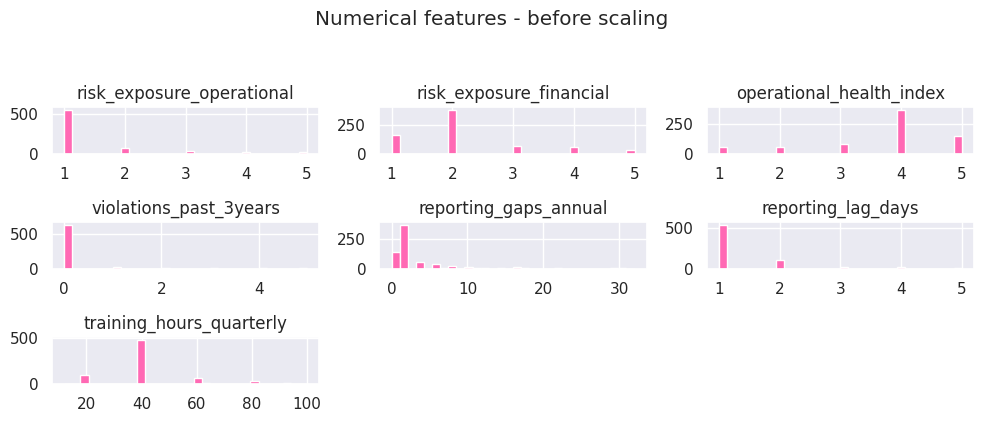

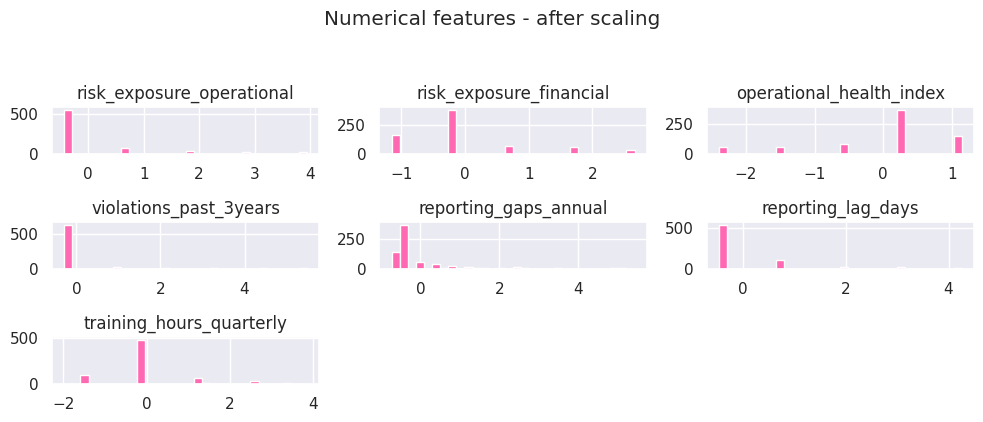

In [ ]:
numeric_cols = num_for_clustering

# BEFORE scaling (numerical only)
ax = df_fe[numeric_cols].hist(bins=30, figsize=(10, 4), color="hotpink")
plt.suptitle("Numerical features - before scaling", y=1.05)
plt.tight_layout()
plt.show()

# AFTER scaling (numerical only)
ax = X_num_scaled[numeric_cols].hist(bins=30, figsize=(10, 4), color="hotpink")
plt.suptitle("Numerical features - after scaling", y=1.05)
plt.tight_layout()
plt.show()

The histograms before and after scaling visually confirms that the numerical features are now expressed on a comparable standardized scale.

# **PCA for Cluster Tendency**

Before fitting clustering models, we assess whether the data shows an intrinsic tendency to form clusters.
This step is exploratory and supports informed decisions on whether clustering is meaningful and which algorithms may be appropriate.


We apply **Principal Component Analysis**, PCA to the scaled feature matrix, **X_ready** in order to:
- reduce dimensionality
- visualize the data structure in 2D, PC1 vs PC2
- inspect whether departments form visible groupings or a large homogeneous cloud

In this project PCA is used as a qualitative support for the 'cluster tendency' assesment, it does not create clusters by itself.

In [ ]:
from sklearn.decomposition import PCA

X = X_ready.copy()

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X)

X_pca_df = pd.DataFrame(
    X_pca,
    columns=["PC1", "PC2"],
    index=X.index
)

explained_var = pca.explained_variance_ratio_

print("Explained variance by PC1: {:.2%}".format(explained_var[0]))
print("Explained variance by PC2: {:.2%}".format(explained_var[1]))
print("Total explained variance (PC1 + PC2): {:.2%}".format(explained_var.sum()))

Explained variance by PC1: 29.17%
Explained variance by PC2: 15.52%
Total explained variance (PC1 + PC2): 44.69%


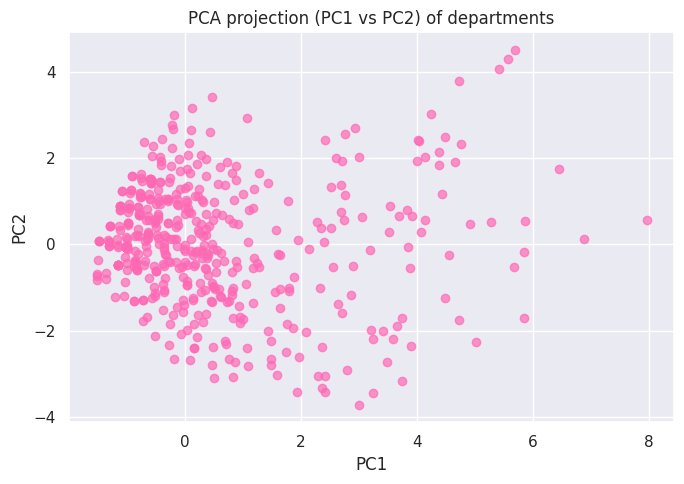

In [ ]:
plt.figure(figsize=(7, 5))
plt.scatter(
    X_pca_df["PC1"],
    X_pca_df["PC2"],
    alpha=0.7,
    color="hotpink"
)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA projection (PC1 vs PC2) of departments")
plt.tight_layout()
plt.show()

# Interpretation of the PCA projection
Using PCA on **X_ready** the first two components explain about 44.69% of the total variance, PC1 = 29.17% and PC2 = 15.52%. This means the 2D plot captures a large parte of the variability but not all of it.

The PC1 and PC2 scatter plot shows a dense central could with a few more distant points. The clusters are not perfectly separated if you just look at the plot, this suggests that there may be some overlapping beween groups, rather than a clear split into istinct 'islands' in the graph. However, the presence of denser regions indicated that there may still be underlying structures worth exploring.

# **Clustering Models**

In this section, we apply clustering algorithms to the preprocessed dataset, **X_ready**, in order to identify latent groups of departments with similar compliance and structural characteristics.
We focus on k-means as the main clustering method, given its interpretability and because it works well when features are on a comparable scale.



# Choice of Clustering Algorithm

We select K-Means because:

- it is simple and widely used

- it performs well on scaled numerical features

- cluster centroids are easily interpretable, they summarize the 'typical' profile of each cluster

- it allows systematic choice of the number of clusters, like testing multiple k values


# Selecting the number of clusters

Before fitting the final model, we choose an appropriate number of clusters using:


- the **Elbow Method**, inertia
- the **Silhouette Score**, cluster separation and cohesion

# Data alignment check
Before attatching cluster labels back to the original data frame, **df_fe**, we verify that **X_ready** and **df_fe** are alligned row by row, same number of rows and smae index order. This ensures that each cluster label is assigned to the correct department.


In [ ]:
assert X_ready.shape[0] == df_fe.shape[0], "Different number of rows between X_ready and df_fe"
assert (X_ready.index == df_fe.index).all(), "Indices are not aligned between X_ready and df_fe"
print("X_ready and df_fe are aligned.")

X_ready and df_fe are aligned.


# **K-Means**
We evaluate multiple values of **k**, from 2 to 15, and choose the final number of clusters using three complementary diagnostics.

1. **Elbow Method**: inertia always decreases as k increases, so we look for the point where the curve starts to flatten. This 'elbow' indicated that adding more clusters give only small inprovements, this is a good trade-off between simplicity and fit.

2. **Average Silhouette Score**: this measures how well spread and compact the clusters are on average, higher values usually indicate clearer and well defined clustering, but the silhouette score can sometimes favor small k, like k = 2, so it must be intepreted taking into consideration balance and the elbow curve.

3. **Yellowbrick visual checks**: we use Yellowbrick to confirm the elbow location and to visually inspect silhouette distributions across clusters.


The KElbowVisualizer provides an automated check of the elbow point, while the SilhouetteVisualizer panels allow a qualitative inspection of the silhouette distribution within each cluster, like presence of negative values, uneven cluster widths, or very small clusters. Combining these three views helps us choose a k that offers the best compromise between cluster quality and interpretability for the compliance radar segmentation.

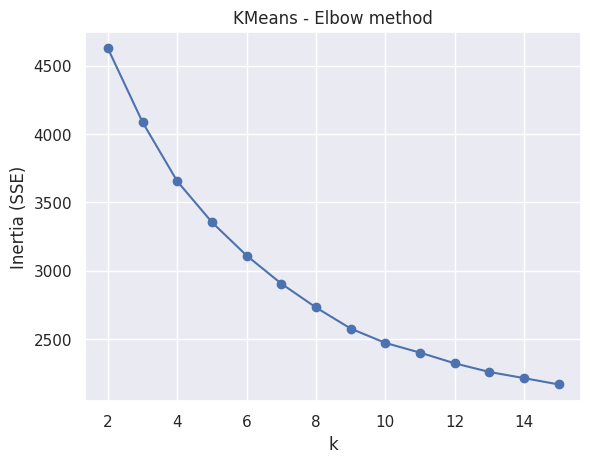

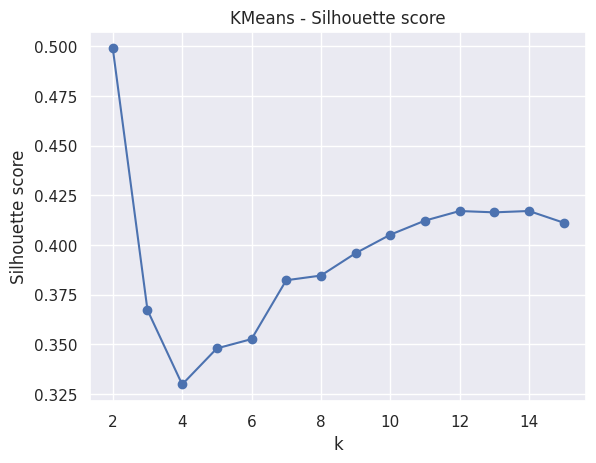

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

K_RANGE = range(2, 16)

inertias = []
sil_scores = []

X = X_ready.values

for k in K_RANGE:
    km = KMeans(n_clusters=k, random_state=42, n_init=20)
    labels = km.fit_predict(X)
    inertias.append(km.inertia_)
    sil_scores.append(silhouette_score(X, labels))

plt.figure()
plt.plot(list(K_RANGE), inertias, marker="o")
plt.xlabel("k")
plt.ylabel("Inertia (SSE)")
plt.title("KMeans - Elbow method")
plt.show()

plt.figure()
plt.plot(list(K_RANGE), sil_scores, marker="o")
plt.xlabel("k")
plt.ylabel("Silhouette score")
plt.title("KMeans - Silhouette score")
plt.show()


# Interpretation of the results

Although the silhouette score peaks at k = 2, we do not choose this solution because it typically leads to an overly simple split, typically one large group and one smaller 'extreme' group. k = 2 often captures a binary split rather than a meaningful multi-profile segmentation, which is not ideal for a compliance radar because we want more than two segments to describe different departmental profieles and support more targeted monitoring actions. So we treat k = 2 as a useful diagnostic tool as it confirms the presence of an extreme subgroup.
#

From the elbow plot, the inertia reduction starts to slow dowm at around k = 7, suggesting a good trade off between model simplicity and fit. The silhouette curve also shows improving valyes again around 7 and above, meaning cluster separation becomes more stable once we move past a very small k. At the same time, we avoid selecting very large k values even if inertia keeps decreasing, because higher k can lead to over-segmentation, reduced stability, and weaker interpretability.
#



# Final choice
Based on this, we select **k = 7** because:
- it captures heterogeneity across departments without over fragmentating the dataset
- balances model quality with interpretability
- it gives us several practical risk or compliance profiles, rather than just splitting departments into two broad groups

# Additional Diagnostic Tools for Selecting K
After assessing the elbow curve and the average silhouette scors, we use **Yellowbrick** as an additional confirmatory step. This helps us confirm the elbow point as well as also providing a detailed view of silhouette quality within each cluster, not just the overall average.

# Yellowbrick elbow
Yellowbrick's **KElbowVisualizer** computes the 'distortion', a variation of within cluster compactness, across different k values and highlights the elbow point. This provides an automated check that challenges, or in our case supports, the manual elbow interpretation.  

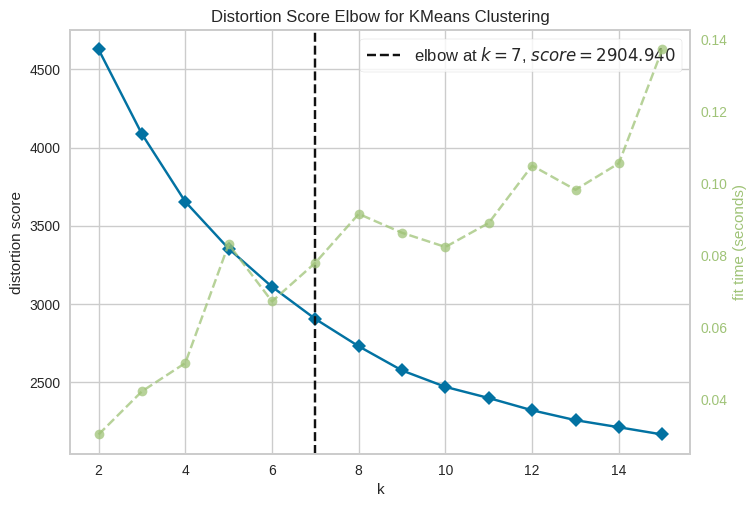

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [ ]:
from yellowbrick.cluster import KElbowVisualizer

model = KMeans(random_state=42, n_init=20)

visualizer = KElbowVisualizer(
    model,
    k=(2, 16),
    metric="distortion",
    timings=True
)

visualizer.fit(X_ready)
visualizer.show()


# Interpretaion
The Yellowbrick elbow plot identifies an elbow around k = 7, meaning that after this point improvements in inertia slow down and the complexity increases.

# Yellowbrick silhouette panels

The average silhouete score alone can hide problems, for instance, some clusters may contain many poorly assigned points, for this reason, we inspect silhouette panels for multiple k values. These plots help us check wether:
- many points have **negative silhouette values**, likely misassigned
- clusters are **very uneven**, one very large and one very small
- silhouette values are mostly **positive** and **consistent**  

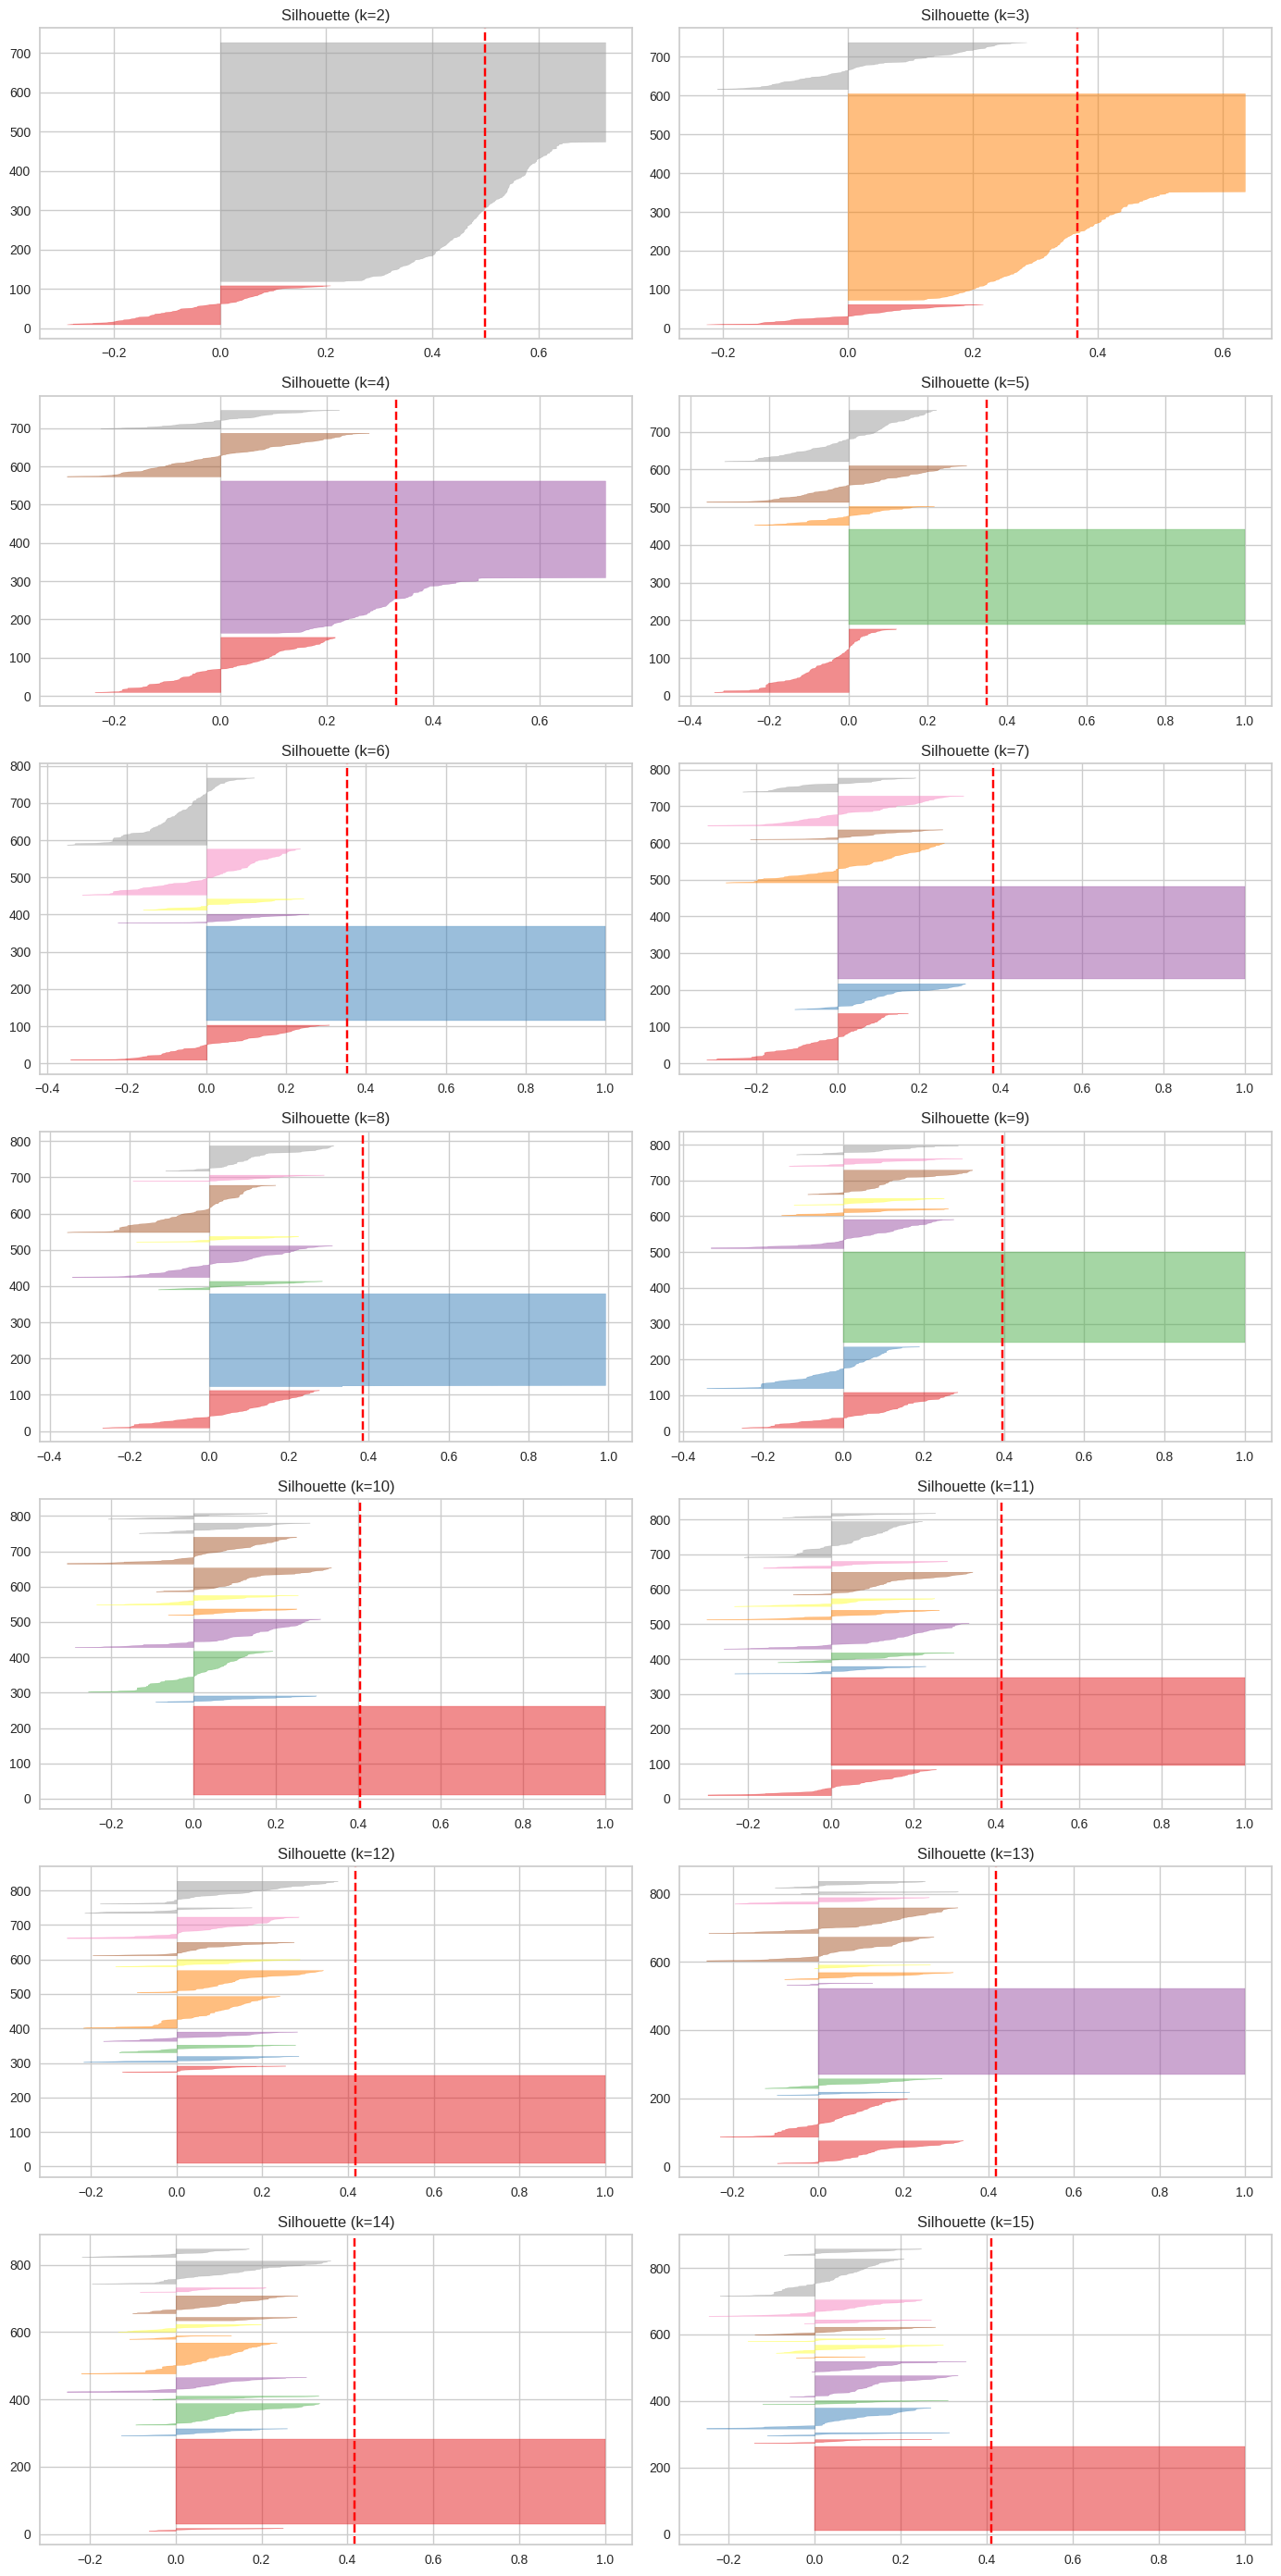

In [ ]:
from yellowbrick.cluster import SilhouetteVisualizer

ks = range(2, 16)
n_cols = 2
n_rows = (len(ks) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 4*n_rows))
axes = axes.flatten()

for i, k in enumerate(ks):
    km = KMeans(n_clusters=k, random_state=42, n_init=20)
    viz = SilhouetteVisualizer(km, ax=axes[i])
    viz.fit(X_ready)
    axes[i].set_title(f"Silhouette (k={k})")

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


# Interpretation
The silhouette panels show that **k = 2** gives a high average silhouette mainly because it creates a very 'harsh' split, a very large group and a very small one. As k increases, the segmentation becomes richer, but very large k values tend to create small clusters which are very hard to interpret and are less stable. Once again, the plots support k = 7.

# Quantitative summary across k
To support the visual assesment we also compute the following:
- **silhouette_avg**: a measure of the overall cluster quality, combining how compact and wlel sperate the clusters are, the higher the values the clearer the custering
- **neg_silhouette_%**: the percentage of observations with negative silhouette values, this suggests they may be assigned to the wrong cluster, lower values are better
- **min_cluster_size**: the size of the smallest cluster, if it is very small, the clustering result is usually less stable and harder to interpret

In [ ]:
from sklearn.metrics import silhouette_score, silhouette_samples

def evaluate_kmeans_k_range(X_df, k_range=range(2, 16), random_state=42, n_init=20):
    X = X_df.values
    rows = []

    for k in k_range:
        km = KMeans(n_clusters=k, random_state=random_state, n_init=n_init)
        labels = km.fit_predict(X)

        sil_avg = silhouette_score(X, labels)
        sil_each = silhouette_samples(X, labels)
        neg_pct = (sil_each < 0).mean() * 100

        counts = np.bincount(labels)
        min_cluster = counts.min()

        rows.append({
            "k": k,
            "inertia_SSE": km.inertia_,
            "silhouette_avg": sil_avg,
            "neg_silhouette_%": neg_pct,
            "min_cluster_size": int(min_cluster)
        })

    return pd.DataFrame(rows).sort_values("k")

# EXAMPLE USAGE:
k_results = evaluate_kmeans_k_range(X_ready, k_range=range(2, 16))
k_results

k  inertia_SSE  silhouette_avg  neg_silhouette_%  min_cluster_size
0    2  4626.821434        0.498900          7.616361               100
1    3  4086.271718        0.367213         10.155148                53
2    4  3654.118785        0.329797         19.887165                50
3    5  3354.322683        0.347942         35.119887                51
4    6  3110.465371        0.352626         34.555712                24
5    7  2904.940143        0.382239         24.118477                27
6    8  2730.529611        0.384597         22.002821                16
7    9  2575.939493        0.395860         19.746121                19
8   10  2471.186092        0.405154         17.066291                17
9   11  2399.933823        0.412248         16.502116                13
10  12  2321.603502        0.417081         15.373766                17
11  13  2258.499171        0.416410         15.514810                 7
12  14  2213.357135        0.417093         15.514810                 9
13  15  2167.156321        0.411194         14.386460                 4

# Interpretation
Although **k = 2** maximizes the average silhouette, it produces an overly simple split that is hard to act on for a compliance radar. Increasing k reduces inertia, and silhouette improves again after about **k = 6**, simultaneously a very large k produces very small clusters, low **min_cluster_size**, which makes the results less stable and harder to interpret. Overall, **k = 7** offers a balanced solution, good quality metrics while keeping cluster sizes large enough to interpret and use in practice.



# Stability check, random seeds
Because k-means uses random starting points, which can give skigly different clusters, we repeat the clustering with the same k = 7 but different random seeds and check whether the resulting clusters remain constant using **ARI**, adjusted rand index, which compares two clusterings of the same data.



In [ ]:
from sklearn.metrics import adjusted_rand_score

# Settings
K=7
SEEDS = [0, 1, 2, 3, 4, 10, 21, 42, 99, 123]
N_INIT = 20

X = X_ready.values

labels_by_seed = {}
for seed in SEEDS:
    km = KMeans(n_clusters=K, random_state=seed, n_init=N_INIT)
    labels_by_seed[seed] = km.fit_predict(X)

# Pairwise ARI matrix
ari_mat = pd.DataFrame(index=SEEDS, columns=SEEDS, dtype=float)
for s1 in SEEDS:
    for s2 in SEEDS:
        ari_mat.loc[s1, s2] = adjusted_rand_score(labels_by_seed[s1], labels_by_seed[s2])

print("Pairwise ARI (stability) across random seeds:")
display(ari_mat.round(3))

# Summaries
upper_vals = ari_mat.where(np.triu(np.ones(ari_mat.shape), k=1).astype(bool)).stack().values
print(f"Mean ARI: {upper_vals.mean():.3f}")
print(f"Min  ARI: {upper_vals.min():.3f}")
print(f"Max  ARI: {upper_vals.max():.3f}")

Pairwise ARI (stability) across random seeds:


0      1      2      3      4      10     21     42     99     123
0    1.000  0.979  0.877  0.965  0.985  0.953  0.920  0.938  0.927  0.940
1    0.979  1.000  0.861  0.946  0.984  0.937  0.916  0.940  0.911  0.921
2    0.877  0.861  1.000  0.894  0.868  0.902  0.928  0.892  0.930  0.919
3    0.965  0.946  0.894  1.000  0.951  0.983  0.945  0.962  0.952  0.966
4    0.985  0.984  0.868  0.951  1.000  0.941  0.910  0.927  0.913  0.927
10   0.953  0.937  0.902  0.983  0.941  1.000  0.956  0.978  0.964  0.977
21   0.920  0.916  0.928  0.945  0.910  0.956  1.000  0.954  0.992  0.975
42   0.938  0.940  0.892  0.962  0.927  0.978  0.954  1.000  0.954  0.959
99   0.927  0.911  0.930  0.952  0.913  0.964  0.992  0.954  1.000  0.983
123  0.940  0.921  0.919  0.966  0.927  0.977  0.975  0.959  0.983  1.000

Mean ARI: 0.940
Min  ARI: 0.861
Max  ARI: 0.992


 When **ARI = 1**, the clusterings are identical, so the closer to 1, the most similar they are. The ARI score are consistently high, **mean = 0.94, min = 0.861, max = 0.992**, indicating that the k = 7 segmentation is highly stable across different random starting points.



# Final K-Means Model

Based on the elbow and silhouette analyses, we select k = 7 as the final number of clusters. We then fit the final k-means model on the fully preproxed fature matrix, **X_ready**. We add the cluster labels to a copy of the original dataset, **df_kmeans**, so that we can profile clusters using the original variables.


# Cluster size distributioin
As a first check we inspect the cluster size distribution in both absolute counts and percentages. This helps us asses whether the segmentation is balanced, or whetehr k-means produced very uneven groups, this could reduce practical usefulness for a 'radar' style grouping.  


In [ ]:
K_FINAL = 7

kmeans_final = KMeans(n_clusters=K_FINAL, random_state=42, n_init=20)
kmeans_labels = kmeans_final.fit_predict(X_ready.values)

df_kmeans = df_fe.copy()
df_kmeans["cluster_kmeans"] = kmeans_labels

print("Cluster counts:")
print(df_kmeans["cluster_kmeans"].value_counts().sort_index())

print("\nCluster percentages:")
print((df_kmeans["cluster_kmeans"].value_counts(normalize=True)*100).sort_index().round(2))

Cluster counts:
cluster_kmeans
0    128
1     71
2    254
3    108
4     27
5     82
6     39
Name: count, dtype: int64

Cluster percentages:
cluster_kmeans
0    18.05
1    10.01
2    35.83
3    15.23
4     3.81
5    11.57
6     5.50
Name: proportion, dtype: float64


# Results
- **Cluster 2**: it is the largest cluster, it contains 254 departments, 35.83%
- **Cluster 4**: small cluster, contains 27 departments, 3.81%
- most other clusters are medium sized and they range between 10% to 18%

This overall indicates a reasonably diversified segmentation, the solution is not dominated by a signle majority group, unlike if k = 2, and it produces various clusters that can be meaningfully profiled for compliance monitoring.

# Quality VS interpretability
Although the clusters are not perfectly balanced, the distribution is interpretable, most clusters are large enough to be stable and explainable, while the smallest cluster likely represents a more specific or extreme profile. In the next step, we check that this small cluster is not just random noise, by comparing its feature values and category frequencies to the other clusters and verifying that it forms a consistent compliance risk profile.






# Numerical cluster profiling

In order to interpret the k-means groups,we summarize each cluster using the numerical features that were used to build the clustering. We compute the mean value of each numercial feature within each cluster and we also include the cluster size **n**. This creates a compact profile that helps us understand what differentiates the clusters, for instance higher risk exposure, more reporting gaps, or more violations, and whether each group is large enough to be meaningful.





In [ ]:
cluster_profile_num = (
    df_kmeans.groupby("cluster_kmeans")[num_for_clustering]
    .mean()
    .round(3)
)

cluster_sizes = df_kmeans["cluster_kmeans"].value_counts().sort_index()
cluster_profile_num.insert(0, "cluster_size", cluster_sizes.values)

cluster_profile_num

cluster_size  risk_exposure_operational  \
cluster_kmeans                                            
0                        128                      1.125   
1                         71                      1.113   
2                        254                      1.000   
3                        108                      1.120   
4                         27                      3.111   
5                         82                      2.378   
6                         39                      2.872   

                risk_exposure_financial  operational_health_index  \
cluster_kmeans                                                      
0                                 1.672                     4.625   
1                                 1.521                     3.803   
2                                 2.000                     4.000   
3                                 1.852                     2.046   
4                                 3.000                     2.741   
5                                 4.171                     4.220   
6                                 2.897                     2.769   

                violations_past_3years  reporting_gaps_annual  \
cluster_kmeans                                                  
0                                0.133                  3.547   
1                                0.014                  2.577   
2                                0.000                  2.000   
3                                0.120                  3.306   
4                                3.926                  9.148   
5                                0.256                  3.573   
6                                0.487                 16.897   

                reporting_lag_days  training_hours_quarterly  
cluster_kmeans                                                
0                            1.367                    33.797  
1                            1.338                    67.310  
2                            1.000                    40.000  
3                            1.426                    37.037  
4                            2.815                    54.741  
5                            1.573                    32.829  
6                            2.744                    57.077

# Numerical cluster profiling
The table provides a summary that is interpretable, of each cluster by reporting the average levels of the numerical features and the number of departments in the cluster. Overall, the **k = 7** clustering creates multiple usable groups, largest cluster ≈ 36% and smallest ≈ 4% to 6%, which supports the goal of producing several actionable department profiles rather than a single 'majority vs outliers' spilt.


# Cluster summaries (ordered by size)
- **Cluster 2, n = 254, ~36%:** low incident profile, nearly zero violations, moderate risk exposure, and moderate reporting gaps, this is a standard department pattern.
- **Cluster 0, n = 128, ~18%:** strong operational performance but with some process and reporting issues, very low violations, stable but needs reporting improvements.
- **Cluster 3, n = 108, ~15%:** noticably lower operational performance with moderate violations, it is operationally a weaker profile.
- **Cluster 5, n = 82, ~12%:** it is driven by high financial exposure with good operational performance and low violations.
- **Cluster 1, n = 71, ~10%:** high training hours with near xero violations, it is training intensive
- **Cluster 6, n = 39, ~6%:** extremely high reporting gaps and higher lag, it has process and reporting risk
- **Cluster 4, n = 27, ~4%:** high operational and financial explosure combines with high violations and reporting issues, high risk and incident heavy, more than the others


# Categorical profiling
Numerical clustering tells us **how clusters behave** in terms of risk and compliance (exposure, violations, reporting, training). To understand **who these groups are** from an organizational perspective, we examine how categorical attributes are distributed within each cluster.

For each categorical feature used in clustering, **dept_category, division, team_size, dept_type**, we compute a **within cluster percentage breakdown**. This highlights whether certain organizational categories are over represented in specific clusters and helps translate clusters into interpretable departmental 'profiles'.




In [ ]:
for col in cat_for_clustering:
    print(f"\n=== {col} (% per cluster) ===")
    tab = pd.crosstab(df_kmeans["cluster_kmeans"], df_kmeans[col], normalize="index") * 100
    display(tab.round(2))



=== dept_category (% per cluster) ===


dept_category   Financial_Reporting  Operational_Compliance  Risk_Management
cluster_kmeans                                                              
0                             99.22                    0.00             0.78
1                             98.59                    0.00             1.41
2                              0.00                  100.00             0.00
3                            100.00                    0.00             0.00
4                             29.63                   29.63            40.74
5                             96.34                    1.22             2.44
6                             69.23                    7.69            23.08


=== division (% per cluster) ===


division        Corporate_HQ  Regional_Operations
cluster_kmeans                                   
0                      99.22                 0.78
1                     100.00                 0.00
2                     100.00                 0.00
3                     100.00                 0.00
4                      59.26                40.74
5                     100.00                 0.00
6                      61.54                38.46


=== team_size (% per cluster) ===


team_size        Large  Medium  Small
cluster_kmeans                       
0                73.44    0.00  26.56
1                80.28    0.00  19.72
2               100.00    0.00   0.00
3                73.15    0.00  26.85
4                44.44   33.33  22.22
5                70.73    2.44  26.83
6                46.15   20.51  33.33


=== dept_type (% per cluster) ===


dept_type       Compliance  Finance  Legal  Operations  Support  Technology
cluster_kmeans                                                             
0                     2.34     1.56   2.34       35.94    57.03        0.78
1                     1.41     1.41   1.41       23.94    70.42        1.41
2                     0.00     0.00   0.00        0.00   100.00        0.00
3                     0.93     0.00   1.85       31.48    63.89        1.85
4                     3.70    14.81  11.11       22.22    37.04       11.11
5                     2.44     2.44   3.66       47.56    36.59        7.32
6                     7.69    12.82   5.13       20.51    41.03       12.82

# Key results

### **dept_category**
- **Clusters 0, 1, 3, 5** are almost entirely **Financial_Reporting** (~96% to 100%), this indicates the existance of multiple subprofiles within the same department category
- **Cluster 2** is **100% Operational_Compliance** making it highly homogeneous
- **Clusters 4** and **6** are more mixed, with a stronger presence of **Risk_Management**, Cluster 4 ≈ 40.7%, Cluster 6 ≈ 23.1%

This suggests **dept_category** strongly shapes the grouping, but clusters 4 and 6 capture mixed profiles.



### **division**
- Most clusters are dominated by **Corporate_HQ**, often close to 100%
- **Clusters 4** and **6** are the only ones with a meaningful share of **Regional_Operations**, ~40%

This indicates that some clusters may capture differences linked to operational context, departments operating in regional settings may face different process and compliance conditions than HQ units.

### **team_size**
- **Cluster 2** is **100% Large** teams
- **Clusters 4** and **6** include a substantial **Medium** share, ≈33% and ≈21%, whilse most others have almost none

Team size helps differentiate clusters: some are structurally uniform, others more balanced.*

### **dept_type**
- **Cluster 2** is **100% Support**, again showing a very 'pure' organizational identity
- Most other clusters are dominated by a mix of **Support** and **Operations**.
- **Cluster 4** stands out and is the most diverse, showing higher shares of Finance, Legal, and Technology compared to the other clusters, suggesting a mosre complex departmental composition


# Link with numerical profiling
**Numerical profiling** explains risk and compliance behaviour inside clusters (exposure, violations, reporting gaps and lags, training), while **categorical profiling** describes the organizational identity o each cluster (category, division, size, type). Taken together, we can connect what the risk pattern is with where it tends to occur inside the organization.



# Final interpretation
Combining the numerical and categorical results, the k = 7 k-means model does not produce random partitions, but rather clear and interpretable groups.


Most departments fall into stable and low-incident profiles, in particular, Cluster 2, ~36% is a good baseline segment as it is very consistent in structure, **Operational_Compliance**, Support, and Large teams, and shows almost no violations.

Larger clusters, 0, 1, 3, and 5, are mainly **Financial_Reporting**, but they are not identical because it is clear they differ in risk patterns such as exposure levels, operational performance, training intensity, and reporting performance.


The clustering also isolates small but important risk clusters, Cluster 6, ~5.5%, stands out for process and reporting issues as it has high reporting gaps and lag, while Cluster 4, ~3.8%, represents the strongest high-risk profile as it has, high exposure, more violations, and reporting issues. These higher-risk clusters also appear in more complex contexts like more mixed categories, more Regional_Operations, and more Medium-sized teams.



# Cluster Visualization in PCA Space

We map the final k-means cluster labels onto the first two principal components to provide an intuitive, low-dimensional visual check of how the clusters are distributed.

The purpose of this plot is to be purely illustrative, not a definitive validation, the first two principal components, PC1 and PC2 capture only part of the total variance, about 45%, so some overlap in 2D is expected even if the clusters are well-separated in the full feature space.

Explained variance PC1/PC2: [29.17 15.52] Total: 44.69


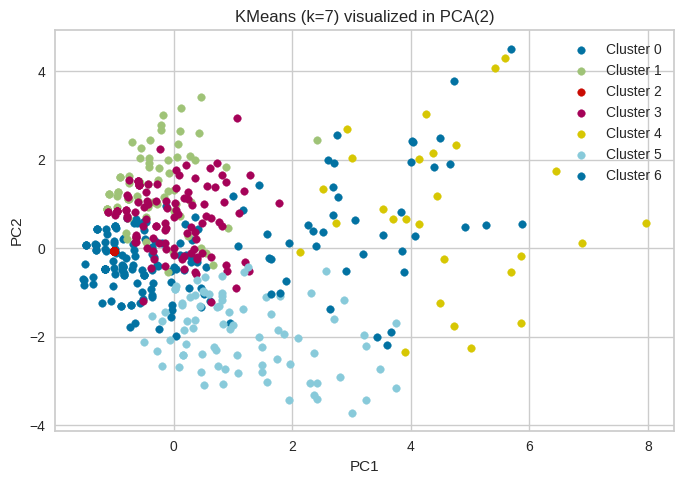

In [ ]:
pca2 = PCA(n_components=2, random_state=42)
X_pca2 = pca2.fit_transform(X_ready.values)

X_pca_df = pd.DataFrame(X_pca2, columns=["PC1", "PC2"], index=X_ready.index)

print(
    "Explained variance PC1/PC2:",
    (pca2.explained_variance_ratio_ * 100).round(2),
    "Total:",
    round(pca2.explained_variance_ratio_.sum() * 100, 2)
)

labels = df_kmeans.loc[X_ready.index, "cluster_kmeans"].to_numpy()
unique_labels = np.sort(np.unique(labels))

plt.figure(figsize=(7, 5))
for lab in unique_labels:
    mask = labels == lab
    plt.scatter(
        X_pca_df.loc[mask, "PC1"],
        X_pca_df.loc[mask, "PC2"],
        s=30,
        label=f"Cluster {lab}"
    )

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title(f"KMeans (k={K_FINAL}) visualized in PCA(2)")
plt.legend()
plt.tight_layout()
plt.show()

# Interpretation
Here, the clusters are not perfectly separated, even though the plot still highlights areas where groups tend to concentrate and a few more 'extreme' regions. This is consistent with our decision of choosing k = 7, as it captures different department profiles, including smaller clusters that appear more displaced from the dense core of observations. Overall, the PCA visualization supports k = 7 as a practical compromise, clusters are not arbitrary, yet the solution remains manageable to interpret and use for the Compliance Radar.





# External Validation, post-hoc
Internal clustering metrics like silhouette and inertia, tell us whether clusters are compact and separated in the feature space, but they do not tell us whether clusters are meaningful for compliance outcomes.

#
For this reason, we perform a post-hoc external validation by comparing cluster assignments against **compliance_score_final**, this variable is excluded from the clustering feature matrix, **X_ready**. This gives an additional check of whether the discovered groups align with overall compliance performance.

#
Although **compliance_score_final** is a constructed score, derived from the original variables, it still works well here as a becaus it is an independent reference measure not used to fit the clustering models.

#

We apply the asme validation logic to k-means, ward agglomerative, and DBSCAN, so the methods can be compared on whether they separate departments into clusters with meaningfully different compliance outcomes.

# External validation for k-means
We summarize **compliance_score_final** within each k-means cluster (count, mean, median, std) and sort clusters by median compliance score, a lower median = weaker compliance outcome.

In [ ]:
val = (
    df_kmeans.groupby('cluster_kmeans')['compliance_score_final']
    .agg(count="count", mean="mean", median="median", std="std")
    .sort_values("median")
)

display(val)

count       mean  median        std
cluster_kmeans                                     
5                  82  57.741463    55.0  14.847330
0                 128  62.519531    65.0  11.738013
2                 254  65.000000    65.0   0.000000
1                  71  67.394366    65.0  12.096610
3                 108  64.398148    65.0  11.473610
6                  39  69.020513    65.6  13.113897
4                  27  72.355556    72.6  17.115835

# Interpretation

Since higher **compliance_score_final** indicates better compliance and this variable was not used to build the clusters, comparing its distribution across clusters provides an external check of the clustering results.

The results show clear differences, **Cluster 5** has the lowest median compliance, 55, while most clusters concentrate around 65, **Cluster 4** has the highest median, around 72.6. This suggests that the k-means clustering captures meaningful differences in overall compliance outcomes, this can be used to support the risk interpretation of each cluster.

# Risk Buckets from Clusters
**Risk buckets and link to external validation**

Raw cluster IDs like 0–6 are not directly meaningful for compliance teams and decision makers, and to make the clustering output actionable, we map each cluster to a risk bucket, Low, Medium, and High, supported by two sources:
1. **External validation** using **compliance_score_final** so it provides an independent outcome-based check

2. **Internal cluster profiles**, like violations and reporting delays, to refine the interpretation when a cluster shows strong 'red flag' signals

We apply a simple two-step rule: we assign a baseline risk level using the cluster median of **compliance_score_final**, then adjust only when red-flag indicators are extreme.



In [ ]:
N_HIGH = 1
N_LOW  = 1

val["risk_bucket_base"] = "Medium"
val.iloc[:N_HIGH, val.columns.get_loc("risk_bucket_base")] = "High"
val.iloc[-N_LOW:, val.columns.get_loc("risk_bucket_base")] = "Low"

RF1 = "violations_past_3years"
RF2 = "reporting_lag_days"

val["risk_bucket"] = val["risk_bucket_base"]

if RF1 in df_kmeans.columns and RF2 in df_kmeans.columns:
    rf1_thr = df_kmeans[RF1].quantile(0.80)
    rf2_thr = df_kmeans[RF2].quantile(0.80)

    rf_medians = df_kmeans.groupby('cluster_kmeans')[[RF1, RF2]].median()
    val[f"{RF1}_median"] = val.index.map(rf_medians[RF1])
    val[f"{RF2}_median"] = val.index.map(rf_medians[RF2])

    val.loc[
        (val["risk_bucket"] == "Low") &
        ((val[f"{RF1}_median"] >= rf1_thr) | (val[f"{RF2}_median"] >= rf2_thr)),
        "risk_bucket"
    ] = "Low-Medium"

    val.loc[
        (val["risk_bucket"] == "Medium") &
        ((val[f"{RF1}_median"] >= rf1_thr) & (val[f"{RF2}_median"] >= rf2_thr)),
        "risk_bucket"
    ] = "High"

display(val[["count", "median", "risk_bucket_base", "risk_bucket"]].sort_values("median"))

count  median risk_bucket_base risk_bucket
cluster_kmeans                                            
5                  82    55.0             High        High
0                 128    65.0           Medium      Medium
2                 254    65.0           Medium      Medium
1                  71    65.0           Medium      Medium
3                 108    65.0           Medium      Medium
6                  39    65.6           Medium        High
4                  27    72.6              Low  Low-Medium

# Interpretation of risk bucket table
Using **compliance_score_final** as an external outcome, where higher means better compliance, **Cluster 5** has the lowest median compliance, 55.0, and is therefore labeled High. **Cluster 4** has the highest median compliance, 72.6, so it is Low at baseline, but it is moved to Low-Medium because at least one red-flag indicator is extreme, suggesting a monitoring priority despite strong overall compliance.

Most clusters (0, 1, 2, 3) sit around a median of ~65 and remain Medium, indicating neither clearly weak outcomes nor extreme red-flag patterns. **Cluster 6** is moved from Medium to High because it is extreme on both red flags, violations and reporting lag, consistent with a significant weakness that deserves high attention even if its median compliance score is not the lowest.

# High risk share by cluster
As an additional post-hoc check, we compute the share of departments flagged as high-risk in the database reference list within each cluster. This does not affect the clustering but it provides a simple 'risk concentration' view that supports communication.

In [ ]:
# we read the high-risk department IDs from the DB
hr_ids = set(
    pd.read_sql("SELECT DISTINCT dept_id FROM high_risk_departments", conn)["dept_id"]
)

def add_high_risk_flag(df, dept_id_col="dept_id"):
    df = df.copy()
    df["is_high_risk_db"] = df[dept_id_col].isin(hr_ids).astype(int)
    return df

df_kmeans_hr = add_high_risk_flag(df_kmeans, dept_id_col="dept_id")

kmeans_risk = (
    df_kmeans_hr.groupby("cluster_kmeans")["is_high_risk_db"]
    .agg(
        n="size",
        high_risk_n="sum",
        high_risk_pct=lambda s: 100 * s.mean()
    )
    .sort_values("high_risk_pct", ascending=False)
)

display(kmeans_risk.round(2))

n  high_risk_n  high_risk_pct
cluster_kmeans                                 
4                27           27         100.00
5                82           57          69.51
6                39           26          66.67
0               128           46          35.94
3               108           37          34.26
1                71           16          22.54
2               254            8           3.15

# Interpretation
The concentration results broadly align with the buckets as **Clusters 5** and **6** show the highest shares of DB-flagged high risk departments, while **Cluster 2** has a very low share, consistent with a lower risk baseline group.

If **Cluster 4 appears** as 100% high risk in the DB list despite having strong compliance outcomes, that may indicate that departments may be flagged as high risk because they operate in high stakes areas, even if their compliance scores are strong. In this sense, Cluster 4 can be interpreted as high stakes but well controlled.

# **Agglomerative Clustering**

# Why we included agglomerative clustering
Alongside k-means, we also test agglomerative hierarchical clustering because it provides a hierarchical view of how departments merge into groups. This is useful as it helps us understand whether the data naturally forms a few large groups or many smaller subgroups, and it supports a more informed choice of the number of clusters before final profiling.

# Why we use Ward linkage and Euclidean distance
We use ward linkage because it builds clusters by minimizing the increase in within cluster variance at each merge. Since our numerical features are standardized and categorical variables are one-hot encoded, Euclidean distance is a consistent baseline for measuring similarity in this feature space.

Other linkage methods such as complete and average can capture different shapes, but on standardized mixed-feature matrices they often lead to more fragmented clusters or less clean separations.

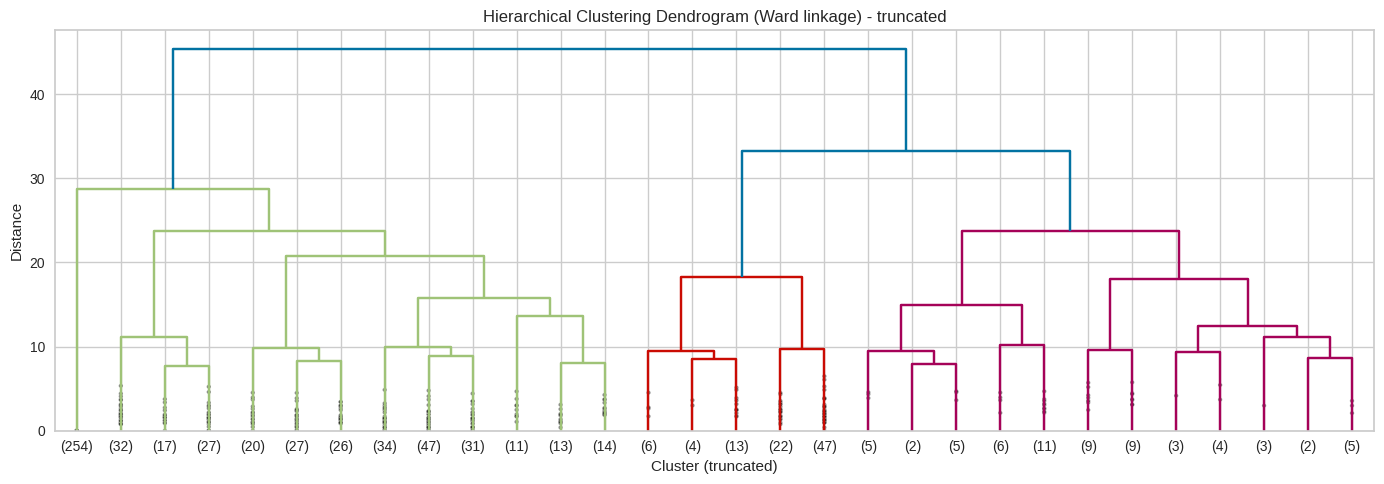

In [ ]:
from scipy.cluster.hierarchy import linkage, dendrogram

# Hierarchical linkage matrix (Ward)
Z = linkage(X_ready.values, method="ward")

plt.figure(figsize=(14, 5))
dendrogram(
    Z,
    truncate_mode="lastp",
    p=30,
    leaf_rotation=0,
    leaf_font_size=10,
    show_contracted=True
)
plt.title("Hierarchical Clustering Dendrogram (Ward linkage) - truncated")
plt.xlabel("Cluster (truncated)")
plt.ylabel("Distance")
plt.tight_layout()
plt.show()

# Selecting the number of clusters for ward agglomerative
W tune the number of clusters k for ward agglomerative using the same preprocessed feature matrix, **X_ready**, used for k-means. This keeps the comparison fair across clustering methods.

Unlike k-means, hierarchical clustering does not provide an inertia curve, so we rely on silhouette based diagnostics and additional practicality checks. We do not pick k based only on the highest silhouette, because a very small k can produce overly coarse groupings and very large k can create tiny clusters that are difficult to interpret. Instead, we look for a balanced choice that:
- achieves a reasonably high average silhouette
- keeps the share of negative silhouettes under control
- avoids extremely small clusters
- remains interpretable for compliance profiling

In [ ]:
from sklearn.cluster import AgglomerativeClustering

K_RANGE = range(2, 16)

rows = []
X = X_ready.values

for k in K_RANGE:
    agg = AgglomerativeClustering(n_clusters=k, linkage="ward")
    labels = agg.fit_predict(X)

    sil_avg = silhouette_score(X, labels, metric="euclidean")

    sil_vals = silhouette_samples(X, labels, metric="euclidean")
    neg_pct = (sil_vals < 0).mean() * 100

    counts = pd.Series(labels).value_counts()
    min_cluster = counts.min()

    rows.append({
        "k": k,
        "silhouette_avg": sil_avg,
        "neg_silhouette_%": neg_pct,
        "min_cluster_size": int(min_cluster)
    })

agg_results = pd.DataFrame(rows).sort_values("k").reset_index(drop=True)
agg_results

k  silhouette_avg  neg_silhouette_%  min_cluster_size
0    2        0.397238         13.963329               156
1    3        0.340201         10.719323                64
2    4        0.294870         49.224260                64
3    5        0.324635         42.172073                64
4    6        0.331151         40.902680                29
5    7        0.356989         30.747532                29
6    8        0.364924         28.208745                23
7    9        0.369243         26.939351                17
8   10        0.386967         22.566996                17
9   11        0.389601         22.002821                12
10  12        0.394613         20.874471                11
11  13        0.396563         20.310296                 7
12  14        0.395591         20.592384                 7
13  15        0.397603         20.169252                 3

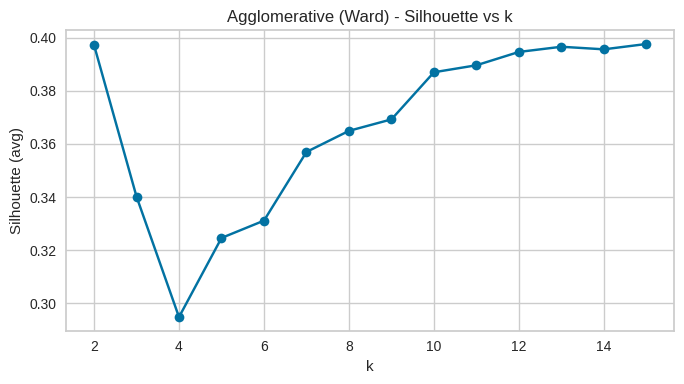

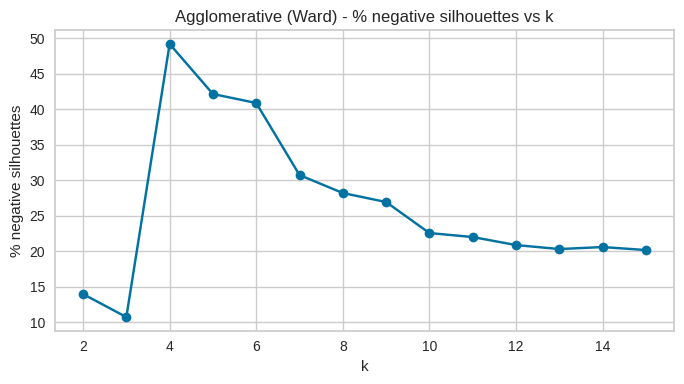

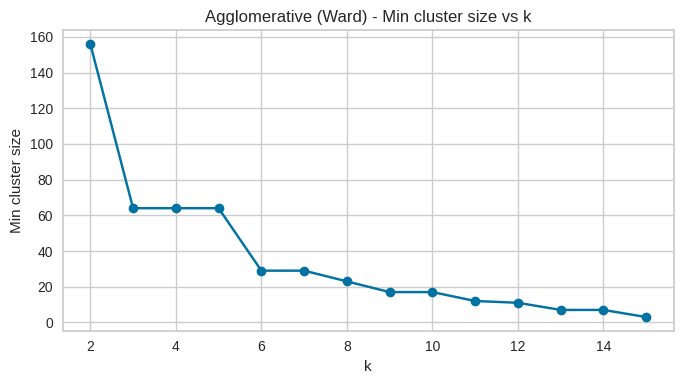

In [ ]:
plt.figure(figsize=(7,4))
plt.plot(agg_results["k"], agg_results["silhouette_avg"], marker="o")
plt.xlabel("k")
plt.ylabel("Silhouette (avg)")
plt.title("Agglomerative (Ward) - Silhouette vs k")
plt.tight_layout()
plt.show()

plt.figure(figsize=(7,4))
plt.plot(agg_results["k"], agg_results["neg_silhouette_%"], marker="o")
plt.xlabel("k")
plt.ylabel("% negative silhouettes")
plt.title("Agglomerative (Ward) - % negative silhouettes vs k")
plt.tight_layout()
plt.show()

plt.figure(figsize=(7,4))
plt.plot(agg_results["k"], agg_results["min_cluster_size"], marker="o")
plt.xlabel("k")
plt.ylabel("Min cluster size")
plt.title("Agglomerative (Ward) - Min cluster size vs k")
plt.tight_layout()
plt.show()

# Interpretation
The average silhouette score is highest at **k = 2**, but this typically corresponds to an overly coarse grouping, separating one large baseline group from a smaller extreme group. Since we already discussed this limitation in the k-means section, we treat k = 2 mainly as a diagnostic rather than a practical choice for multi-profile compliance monitoring.

Looking beyond k = 2, ward agglomerative shows a more usable trade-off in the **k = 7 to k = 12** range as, the silhouette improves compared to smaller k values, the percentage of negative silhouettes generally decreases, and the clusters remain large enough to be interpretable.
- **k = 7:** is a more stable and highly interpretable option, because the minimum cluster size remains reasonably large, 29
- **k = 10 to k = 12:** provides slightly stronger separation quality, but it also produces smaller clusters, which can reduce stability and interpretability

Based on this we treat **k = 7** as the main candidate, and we validate the final choice using cluster profiling and external validation, as done for k-means.

# Choosing k, comparing k = 7 and k = 10

We compare **k = 7** and **k = 10** because both are reasonable candidates based on the silhouette diagnostics, but they reflect different trade-offs.
- **k = 7:** favors interpretability and more stable cluster sizes
- **k = 10:** improves separation metrics, but may create smaller clusters that are harder to explain and use in practice
To decide between them, we fit aard agglomerative clustering with both values of k on the same preprocessed matrix **X_ready**, then profile the clusters using:
- **numerical averages**: risk exposure, operational performance, violations, reporting gaps, reporting lag, training
- **categorical composition**: department category, division, team size, department type

This lets us check whether the increase level of detail at **k = 10** produces meaningful new patterns or mostly splits existing profiles into smaller subgroups.

In [ ]:
def fit_agglom_and_attach(df_base, X, k, linkage="ward", metric="euclidean", label_col="cluster_agglo"):
    model = AgglomerativeClustering(n_clusters=k, linkage=linkage, metric=metric)
    labels = model.fit_predict(X)

    df_out = df_base.copy()
    df_out[label_col] = labels
    return df_out


df_agglo7  = fit_agglom_and_attach(df_fe, X_ready.values, k=7,  linkage="ward", metric="euclidean", label_col="cluster_agglo")
df_agglo10 = fit_agglom_and_attach(df_fe, X_ready.values, k=10, linkage="ward", metric="euclidean", label_col="cluster_agglo")

In [ ]:
def numerical_profiling(df, label_col, num_cols):
    profile = df.groupby(label_col)[num_cols].mean().round(3)
    sizes = df[label_col].value_counts().sort_index()
    profile.insert(0, "cluster_size", sizes.values)
    return profile

# for example:
cluster_profile_num_7  = numerical_profiling(df_agglo7,  "cluster_agglo", num_for_clustering)
cluster_profile_num_10 = numerical_profiling(df_agglo10, "cluster_agglo", num_for_clustering)

print("=== Numerical profile (Agglo k=7) ===")
display(cluster_profile_num_7)

print("=== Numerical profile (Agglo k=10) ===")
display(cluster_profile_num_10)

=== Numerical profile (Agglo k=7) ===


cluster_size  risk_exposure_operational  \
cluster_agglo                                            
0                        92                      2.359   
1                        35                      2.600   
2                       150                      1.187   
3                       254                      1.000   
4                        76                      1.250   
5                        29                      2.483   
6                        73                      1.123   

               risk_exposure_financial  operational_health_index  \
cluster_agglo                                                      
0                                3.826                     4.337   
1                                2.886                     2.686   
2                                1.547                     4.200   
3                                2.000                     4.000   
4                                2.303                     1.763   
5                                3.000                     3.310   
6                                1.521                     3.534   

               violations_past_3years  reporting_gaps_annual  \
cluster_agglo                                                  
0                               0.087                  4.641   
1                               1.571                 17.543   
2                               0.053                  4.573   
3                               0.000                  2.000   
4                               0.105                  2.553   
5                               3.379                  4.241   
6                               0.000                  2.041   

               reporting_lag_days  training_hours_quarterly  
cluster_agglo                                                
0                           1.685                    35.272  
1                           3.257                    67.800  
2                           1.407                    35.613  
3                           1.000                    40.000  
4                           1.250                    35.645  
5                           1.966                    38.345  
6                           1.425                    64.658

=== Numerical profile (Agglo k=10) ===


cluster_size  risk_exposure_operational  \
cluster_agglo                                            
0                        29                      2.483   
1                        76                      1.250   
2                        38                      1.447   
3                        18                      2.333   
4                       112                      1.098   
5                        17                      2.882   
6                        73                      1.123   
7                       254                      1.000   
8                        23                      4.174   
9                        69                      1.754   

               risk_exposure_financial  operational_health_index  \
cluster_agglo                                                      
0                                3.000                     3.310   
1                                2.303                     1.763   
2                                1.579                     3.684   
3                                2.889                     2.889   
4                                1.536                     4.375   
5                                2.882                     2.471   
6                                1.521                     3.534   
7                                2.000                     4.000   
8                                4.304                     3.783   
9                                3.667                     4.522   

               violations_past_3years  reporting_gaps_annual  \
cluster_agglo                                                  
0                               3.379                  4.241   
1                               0.105                  2.553   
2                               0.158                 10.842   
3                               1.056                  9.333   
4                               0.018                  2.446   
5                               2.118                 26.235   
6                               0.000                  2.041   
7                               0.000                  2.000   
8                               0.174                  8.435   
9                               0.058                  3.377   

               reporting_lag_days  training_hours_quarterly  
cluster_agglo                                                
0                           1.966                    38.345  
1                           1.250                    35.645  
2                           2.079                    34.263  
3                           4.111                    76.167  
4                           1.179                    36.071  
5                           2.353                    58.941  
6                           1.425                    64.658  
7                           1.000                    40.000  
8                           2.130                    41.478  
9                           1.536                    33.203

In [ ]:
def categorical_profiling(df, label_col, cat_cols):
    for col in cat_cols:
        print(f"\n=== {col} (% per cluster) ===")
        tab = pd.crosstab(df[label_col], df[col], normalize="index") * 100
        display(tab.round(2))

print("=== Categorical profile (Agglo k=7) ===")
categorical_profiling(df_agglo7, "cluster_agglo", cat_for_clustering)

print("\n=== Categorical profile (Agglo k=10) ===")
categorical_profiling(df_agglo10, "cluster_agglo", cat_for_clustering)

=== Categorical profile (Agglo k=7) ===

=== dept_category (% per cluster) ===


dept_category  Financial_Reporting  Operational_Compliance  Risk_Management
cluster_agglo                                                              
0                            95.65                    2.17             2.17
1                            42.86                   14.29            42.86
2                            98.67                    0.00             1.33
3                             0.00                  100.00             0.00
4                           100.00                    0.00             0.00
5                            65.52                   17.24            17.24
6                           100.00                    0.00             0.00


=== division (% per cluster) ===


division       Corporate_HQ  Regional_Operations
cluster_agglo                                   
0                     96.74                 3.26
1                     60.00                40.00
2                     98.00                 2.00
3                    100.00                 0.00
4                    100.00                 0.00
5                     75.86                24.14
6                    100.00                 0.00


=== team_size (% per cluster) ===


team_size       Large  Medium  Small
cluster_agglo                       
0               63.04    3.26  33.70
1               42.86   22.86  34.29
2               83.33    0.67  16.00
3              100.00    0.00   0.00
4               63.16    0.00  36.84
5               48.28   24.14  27.59
6               79.45    0.00  20.55


=== dept_type (% per cluster) ===


dept_type      Compliance  Finance  Legal  Operations  Support  Technology
cluster_agglo                                                             
0                    0.00     2.17   4.35       48.91    36.96        7.61
1                    8.57    17.14   2.86       14.29    37.14       20.00
2                    1.33     2.00   2.67       36.00    58.00        0.00
3                    0.00     0.00   0.00        0.00   100.00        0.00
4                    2.63     0.00   1.32       30.26    61.84        3.95
5                   10.34     6.90  13.79       31.03    34.48        3.45
6                    1.37     1.37   0.00       19.18    78.08        0.00


=== Categorical profile (Agglo k=10) ===

=== dept_category (% per cluster) ===


dept_category  Financial_Reporting  Operational_Compliance  Risk_Management
cluster_agglo                                                              
0                            65.52                   17.24            17.24
1                           100.00                    0.00             0.00
2                            94.74                    0.00             5.26
3                            38.89                   22.22            38.89
4                           100.00                    0.00             0.00
5                            47.06                    5.88            47.06
6                           100.00                    0.00             0.00
7                             0.00                  100.00             0.00
8                            91.30                    4.35             4.35
9                            97.10                    1.45             1.45


=== division (% per cluster) ===


division       Corporate_HQ  Regional_Operations
cluster_agglo                                   
0                     75.86                24.14
1                    100.00                 0.00
2                     92.11                 7.89
3                     55.56                44.44
4                    100.00                 0.00
5                     64.71                35.29
6                    100.00                 0.00
7                    100.00                 0.00
8                     86.96                13.04
9                    100.00                 0.00


=== team_size (% per cluster) ===


team_size       Large  Medium  Small
cluster_agglo                       
0               48.28   24.14  27.59
1               63.16    0.00  36.84
2               76.32    2.63  21.05
3               50.00   27.78  22.22
4               85.71    0.00  14.29
5               35.29   17.65  47.06
6               79.45    0.00  20.55
7              100.00    0.00   0.00
8               56.52    8.70  34.78
9               65.22    1.45  33.33


=== dept_type (% per cluster) ===


dept_type      Compliance  Finance  Legal  Operations  Support  Technology
cluster_agglo                                                             
0                   10.34     6.90  13.79       31.03    34.48        3.45
1                    2.63     0.00   1.32       30.26    61.84        3.95
2                    0.00     5.26   2.63       23.68    68.42        0.00
3                    5.56    16.67   5.56       16.67    22.22       33.33
4                    1.79     0.89   2.68       40.18    54.46        0.00
5                   11.76    17.65   0.00       11.76    52.94        5.88
6                    1.37     1.37   0.00       19.18    78.08        0.00
7                    0.00     0.00   0.00        0.00   100.00        0.00
8                    0.00     0.00   0.00       60.87    30.43        8.70
9                    0.00     2.90   5.80       44.93    39.13        7.25

# Interpretation
The comparison between the two possible k values confirms the expeected trade off:
- **k = 7:** it produces a small set of clearly distinguishable groups with adequate cluster sizes, minimum cluster size = 29. The profiles are easy to summarize into a few 'risk profiles', including a large baseline group, several mid risk patterns, and a small set of higher attention profiles driven by incidents or process and reporting weakness.
- **k = 10:** improves cluster separation, silhouette around 0.387 whilst k = 7 is 0.357, and reduces the share of negative silhouettes of about 22.6%, while k = 7 is 30.7%. However, this comes with smaller clusters, minimum cluster size = 17, and more fragmentation, meaning some profiles are split into very small groups. That increases complexity and makes the overall interpretation harder to explain and use consistently.

We select k = 7 as the final choice because it offers the best balance between quality and usability, clusters remain large enough to be reliable and interpretable, and the resulting profiles can be turned into clear monitoring and intervention priorities.

# Final agglomerative model

 After selecting **k = 7** as the final ward agglomerative solution, we refit the model once on the full dataset and store the final cluster labels in **df_agglo_final**, so that next interpretations and comparisons can be based on this final solution.

 We also inspect the cluster size distribution, counts and percentages, to ensure the grouping is operationally usable and not dominated by a single cluster.

In [ ]:
df_agglo_final = df_agglo7

In [ ]:
# Agglomerative (Ward, k=7) — FINAL
df_agglo_final = df_agglo7.copy()
LABEL_COL = "cluster_agglo"

cluster_counts = df_agglo_final[LABEL_COL].value_counts().sort_index()

cluster_perc = (df_agglo_final[LABEL_COL].value_counts(normalize=True) * 100).sort_index()

print("Agglomerative (Ward, k=7) — Cluster size distribution")

cluster_size_df = (
    pd.DataFrame({
        "count": cluster_counts,
        "percent": cluster_perc.round(2)
    })
)
display(cluster_size_df)


Agglomerative (Ward, k=7) — Cluster size distribution


count  percent
cluster_agglo                
0                 92    12.98
1                 35     4.94
2                150    21.16
3                254    35.83
4                 76    10.72
5                 29     4.09
6                 73    10.30

# Cluster size distribution
The k = 7 solutions produces a balanced distribution, the largest cluster is **Cluster 3** with 254 departments, 35.83%, while the smallest is **Cluster 5** with 29 departments, 4.09%. The remaining clusters range from about 4.94% to 21.16%, which supports interpretability without extreme imbalance.



In [ ]:
display(cluster_profile_num_7)
print("=== Categorical profile (Agglo k=7) ===")
categorical_profiling(df_agglo7, "cluster_agglo", cat_for_clustering)


cluster_size  risk_exposure_operational  \
cluster_agglo                                            
0                        92                      2.359   
1                        35                      2.600   
2                       150                      1.187   
3                       254                      1.000   
4                        76                      1.250   
5                        29                      2.483   
6                        73                      1.123   

               risk_exposure_financial  operational_health_index  \
cluster_agglo                                                      
0                                3.826                     4.337   
1                                2.886                     2.686   
2                                1.547                     4.200   
3                                2.000                     4.000   
4                                2.303                     1.763   
5                                3.000                     3.310   
6                                1.521                     3.534   

               violations_past_3years  reporting_gaps_annual  \
cluster_agglo                                                  
0                               0.087                  4.641   
1                               1.571                 17.543   
2                               0.053                  4.573   
3                               0.000                  2.000   
4                               0.105                  2.553   
5                               3.379                  4.241   
6                               0.000                  2.041   

               reporting_lag_days  training_hours_quarterly  
cluster_agglo                                                
0                           1.685                    35.272  
1                           3.257                    67.800  
2                           1.407                    35.613  
3                           1.000                    40.000  
4                           1.250                    35.645  
5                           1.966                    38.345  
6                           1.425                    64.658

=== Categorical profile (Agglo k=7) ===

=== dept_category (% per cluster) ===


dept_category  Financial_Reporting  Operational_Compliance  Risk_Management
cluster_agglo                                                              
0                            95.65                    2.17             2.17
1                            42.86                   14.29            42.86
2                            98.67                    0.00             1.33
3                             0.00                  100.00             0.00
4                           100.00                    0.00             0.00
5                            65.52                   17.24            17.24
6                           100.00                    0.00             0.00


=== division (% per cluster) ===


division       Corporate_HQ  Regional_Operations
cluster_agglo                                   
0                     96.74                 3.26
1                     60.00                40.00
2                     98.00                 2.00
3                    100.00                 0.00
4                    100.00                 0.00
5                     75.86                24.14
6                    100.00                 0.00


=== team_size (% per cluster) ===


team_size       Large  Medium  Small
cluster_agglo                       
0               63.04    3.26  33.70
1               42.86   22.86  34.29
2               83.33    0.67  16.00
3              100.00    0.00   0.00
4               63.16    0.00  36.84
5               48.28   24.14  27.59
6               79.45    0.00  20.55


=== dept_type (% per cluster) ===


dept_type      Compliance  Finance  Legal  Operations  Support  Technology
cluster_agglo                                                             
0                    0.00     2.17   4.35       48.91    36.96        7.61
1                    8.57    17.14   2.86       14.29    37.14       20.00
2                    1.33     2.00   2.67       36.00    58.00        0.00
3                    0.00     0.00   0.00        0.00   100.00        0.00
4                    2.63     0.00   1.32       30.26    61.84        3.95
5                   10.34     6.90  13.79       31.03    34.48        3.45
6                    1.37     1.37   0.00       19.18    78.08        0.00

# Cluster profiling

## Numerical profiling
The numerical profiles show clear differences across the main risk signals:
- **Cluster 3 (n = 254, 35.83%):** the baseline, zero violations, low reporting gaps and lag, and moderate exposure and operational performace  
- **Cluster 2 (n = 150, 21.16%):** also relatively low risk, low exposure, strong operational performace, and low violations, but slightly higher reporting gaps than the baseline
- **Cluster 6 (n = 73, 10.30%):** stands out for high training hours with zero violations, consistent with a prevention oriented profile
- **Cluster 0 (n = 92, 12.98%):** shows higher operational and financial exposure while maintaining good operational performance and low violations, suggesting 'high exposure but controlled'
- **Cluster 4 (n = 76, 10.72%):** has the weakest operational performance, pointing to a fragility pattern where risk may stem from capacity or process weakness rather than repeated incidents
- Two smaller clusters capture the strongest warning patterns:
  - **Cluster 5 (n = 29, 4.09%):** is incident heavy, highest violations, with elevated exposure
  - **Cluster 1 (n = 35, 4.94%):** shows a reporting and process breakdown pattern, very high reporting gaps and lag, alongside elevated violations


## Categorical profiling
The categorical profiles reinforce that the clusters map to meaningful organizational contexts:
- Baseline **Cluster 3** s extremely homogeneous, **Operational_Compliance, Corporate_HQ, Large teams, Support**, indicating a well defined baseline group
- Several other clusters are dominated by **Financial_Reporting**, which is important because it suggests the model is not only recreating department categories, but it is splitting the **Financial_Reporting** population into different risk patterns
- The highest risk clusters, **Clusters 1 and 5**, tend to be more structurally mixed and include more **Regional_Operations** and **Medium teams**, which is consistent with higher complexity and more challenging control environments

# Final interpretation
Ward agglomerative with **k = 7**, producees a set of clear and interpretable clusters, large baseline segment, several interpretable mid risk patterns, and two small but high priority groups that concentrate incident and reporting control issues. This makes the solution practical for prioritization in a Compliance Radar.

# PCA plot for Agglomerative clusters
We use PCA with 2 components to visualize the ward k = 7 clusters on a simple 2D map. This does not change the clustering as it is only a way to see whether some groups look clearly different when we map the high dimensional data into two directions.

We run PCA on the same feature matrix used for clustering, **X_ready**, so the plot reflects the real clustering inputs and avoids mixing in other variables.

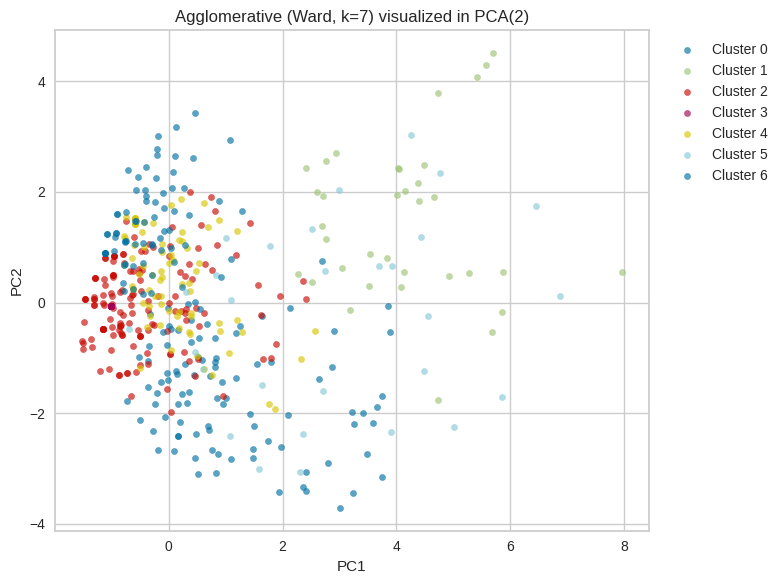

In [ ]:
# PCA on the same matrix used for clustering
pca2 = PCA(n_components=2, random_state=42)
X_pca2 = pca2.fit_transform(X_ready.values)

X_pca_df = pd.DataFrame(X_pca2, columns=["PC1", "PC2"], index=X_ready.index)


labels = df_agglo_final.loc[X_ready.index, LABEL_COL].to_numpy()
unique_labels = np.sort(np.unique(labels))

plt.figure(figsize=(8, 6))
for lab in unique_labels:
    mask = labels == lab
    plt.scatter(
        X_pca_df.loc[mask, "PC1"],
        X_pca_df.loc[mask, "PC2"],
        s=20, alpha=0.65,
        label=f"Cluster {lab}"
    )

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Agglomerative (Ward, k=7) visualized in PCA(2)")
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()

# Interpretation
After the plot, we mainly look for two things:
- if a cluster is far from the main cloud, it may represent an unusual profile with extreme values in some features
- if clusters overlap, that is normal, because PCA in 2D cannot show all information from the original feature space

In this plot, one cluster is clearly separated on PC1 on the far right, which suggests Agglomerative clustering found a distinct extreme profile. Most other clusters overlap in the left and central area, which is consistent with our profiling, because several cluster profiles are similar and differ only in smaller operational and reporting patterns.

PCA in 2D is only a projection, so overlap does not mean the clustering is bad, it only means the separation is not fully visible in two dimensions

# External validation
Even though we did not use **compliance_score_final** to build the clusters, we can use it after clustering as an external check. If the clusters are meaningful for compliance risk, they should show different compliance outcomes on average.

We summarize **compliance_score_final** by cluster using count, mean, median, and standard deviation. We sort by median to quickly identify which clusters are weaker or stronger in overall compliance.

In [ ]:
COMPLIANCE_COL = "compliance_score_final"
val = (
    df_agglo_final.groupby("cluster_agglo")['compliance_score_final']
    .agg(count="count", mean="mean", median="median", std="std")
    .sort_values("median")
)
display(val)

count       mean  median        std
cluster_agglo                                     
5                 29  60.441379    55.0  23.705010
0                 92  59.560870    60.0  11.980487
3                254  65.000000    65.0   0.000000
2                150  62.841333    65.0  11.696074
6                 73  68.082192    65.0  11.384387
4                 76  65.092105    65.0  11.797421
1                 35  72.774286    72.7  12.946459

# Interpretation
The ward clusters show differences in compliance outcomes. **Cluster 5** has the lowest median at 55.0 and the highest variability, so it looks like the main low compliance priority group and it may include mixed cases that need closer review. **Cluster 1** has the highest median around 72.7, suggesting a strong performing segment.

#

Most other clusters sit around a central baseline, with medians close to 65. This suggests these groups are not mainly separated by the overall compliance score, but by the mechanisms we saw in profiling such as exposure, reporting patterns, operational performance, and training. **Cluster 0** is slightly lower with a median of 60.0, so it can be treated as a moderate watch group depending on its profile signals.

#

This check supports using agglomerative clustering for our profiles because it identifies a clear low compliance segment, a clear strong segment, and a middle area where interpretation should rely more on the cluster profiles than on the single compliance score.

# Risk buckets
After we interpret the agglomerative clusters with profiling, we assign simple labels and a risk bucket to each cluster. This does not change the clustering results. It is only a way to make the segmentation easier to communicate and compare across methods later.

#

We repeat this same mapping step for each clustering method, so we can compare whether different algorithms identify similar risk patterns.

# Risk bucket rules
We start with a simple baseline rule using **compliance_score_final**, where higher means better compliance. We sort clusters by median compliance and label:
- high for the lowest median cluster
- low for the highest median cluster
- medium for the clusters in the middle

Then we apply a small adjustment based on 'red flags'. This is the same idea used for K Means, so the buckets stay comparable.

We use **violations_past_3years** and **reporting_lag_days** because they represent concrete operational issues that can matter even when the overall compliance score looks fine.

In [ ]:
N_HIGH = 1
N_LOW  = 1

val["risk_bucket_base"] = "Medium"
val.iloc[:N_HIGH, val.columns.get_loc("risk_bucket_base")] = "High"
val.iloc[-N_LOW:, val.columns.get_loc("risk_bucket_base")] = "Low"

RF1 = "violations_past_3years"
RF2 = "reporting_lag_days"

val["risk_bucket"] = val["risk_bucket_base"]

if RF1 in df_agglo_final.columns and RF2 in df_agglo_final.columns:
    rf1_thr = df_agglo_final[RF1].quantile(0.80)
    rf2_thr = df_agglo_final[RF2].quantile(0.80)

    rf_medians = df_agglo_final.groupby(LABEL_COL)[[RF1, RF2]].median()
    val[f"{RF1}_median"] = val.index.map(rf_medians[RF1])
    val[f"{RF2}_median"] = val.index.map(rf_medians[RF2])

    val.loc[
        (val["risk_bucket"] == "Low") &
        ((val[f"{RF1}_median"] >= rf1_thr) | (val[f"{RF2}_median"] >= rf2_thr)),
        "risk_bucket"
    ] = "Low-Medium"

    val.loc[
        (val["risk_bucket"] == "Medium") &
        ((val[f"{RF1}_median"] >= rf1_thr) & (val[f"{RF2}_median"] >= rf2_thr)),
        "risk_bucket"
    ] = "High"

display(val[["count", "median", "risk_bucket_base", "risk_bucket"]].sort_values("median"))

count  median risk_bucket_base risk_bucket
cluster_agglo                                            
5                 29    55.0             High        High
0                 92    60.0           Medium      Medium
3                254    65.0           Medium      Medium
2                150    65.0           Medium      Medium
6                 73    65.0           Medium      Medium
4                 76    65.0           Medium      Medium
1                 35    72.7              Low  Low-Medium

# Interpretation
From the compliance outcomes, **Cluster 5** has the lowest median compliance at 55.0, so it becomes the clear High priority group. **Cluster 1** has the highest median compliance around 72.7, so it is Low at baseline, but it becomes Low Medium if at least one red flag is extreme.

Most other clusters stay Medium because their medians are close to the baseline band around 60 to 65 and they do not show strong red flag evidence at the same time. This gives a simple and practical structure with one clear High group, one Low or Low Medium monitoring group, and a central Medium area where we rely more on the full cluster profiles.

# Comparison with k-means
The agglomerative risk levels are broadly consistent with k-means. In both methods, the lowest compliance cluster is labeled High and most departments fall in a Medium baseline band near a median of about 65. The main difference is which cluster becomes the monitoring group among the best performers, meaning the two algorithms group the top performing departments slightly differently.

#

This means that k-means builds clusters around centroids, while ward agglomerative merges groups to minimize within cluster variance. Due to the fact that they optimize different objectives, small differences in the best performing segment are expected even when the overall risk structure is similar.

In [ ]:
df_agglo_hr = add_high_risk_flag(df_agglo_final, dept_id_col="dept_id")

agglo_risk = (
    df_agglo_hr.groupby("cluster_agglo")["is_high_risk_db"]
    .agg(
        n="size",
        high_risk_n="sum",
        high_risk_pct=lambda s: 100 * s.mean()
    )
    .sort_values("high_risk_pct", ascending=False)
)

display(agglo_risk.round(2))

n  high_risk_n  high_risk_pct
cluster_agglo                                 
5               29           28          96.55
1               35           25          71.43
0               92           60          65.22
4               76           29          38.16
2              150           54          36.00
6               73           13          17.81
3              254            8           3.15

# External validation
To strengthen the interpretation, we also check each cluster against the database **list high_risk_departments**. We compute how many departments in each cluster are flagged as high risk in the database and the percentage within the cluster.

# Interpretation
This check strongly confirms **Cluster 5** as the most critical group, it has very low compliance outcomes and an extremely high share of high risk departments, 28 out of 29.

#

Some clusters show intermediate concentrations, such as **Cluster 4 and Cluster 2**, while **Cluster 3** is very low at 8 out of 254.

#

A key result is **Cluster 1**, even though it has the highest median compliance, it still contains a large share of database high risk departments, 25 out of 35. This suggests the database high risk label may reflect department criticality or exposure, not only low compliance performance. Due to this, **Cluster 1** can be interpreted as high stakes but well controlled, which is exactly why we keep it as a monitoring group rather than calling it High purely based on the database list.

#

Combining compliance outcomes and database risk concentration makes the cluster profiles easier to explain and more useful for decision making.

# **DBSCAN**
We now test DBSCAN, a density based clustering method. Unlike k-means and agglomerative, DBSCAN does not force every department into a cluster and it does not require choosing a fixed number of clusters. Instead, it finds dense groups in the data and can label isolated departments as noise with label minus one.

#

In our context, DBSCAN is useful for two reasons. First, it can detect compact high density groups without assuming they are round or equal sized. Second, the noise label helps highlight departments that do not fit any typical profile and may need manual review.

# A fair comparison
To keep the comparison fair, we keep the workflow consistent across methods.
- Same input matrix, **X_ready** with the same preprocessing and features
- Same output format with cluster labels added to a dataframe
- Same post clustering checks such as cluster sizes, profiling, and a PCA plot only as a visual check

# What changes
DBSCAN behaves differently, so the evaluation focus also changes.
- We do not choose k, DBSCAN decides how many clusters exist
- We must choose **eps** and **min_samples**, which define what counts as a dense region
- We must always report the amount of noise, because too much noise means DBSCAN is not giving a usable segmentation

# Choosing eps with a k distance plot
DBSCAN depends heavily on **eps**, the neighborhood radius. A good eps value should match the typical distances inside dense regions of our dataset. Instead of guessing eps, we use a k distance plot, which is a standard data driven way to set a realistic eps range.

# Why this step is a good decision
Even after scaling, our dataset mixes numerical features and one hot encoded categories, so the distance distribution is not obvious. With DBSCAN, small changes in eps can completely change the result, from almost everything being noise to one giant cluster. The k distance plot helps us avoid guess based eps, by showing where distances start increasing sharply. That bend is a natural cutoff between dense neighborhoods and more isolated points.

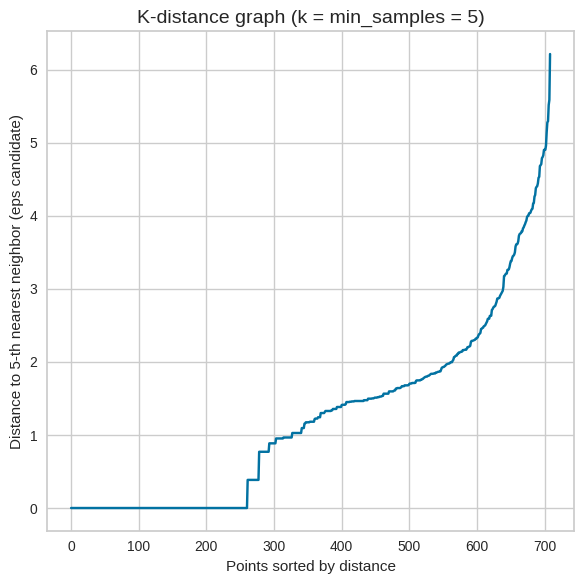

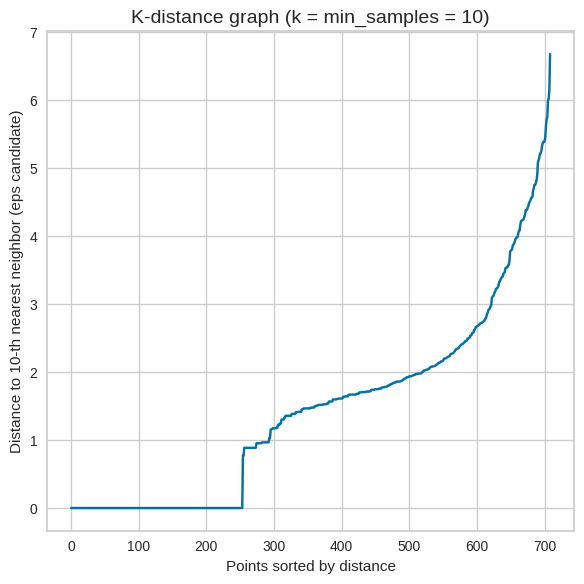

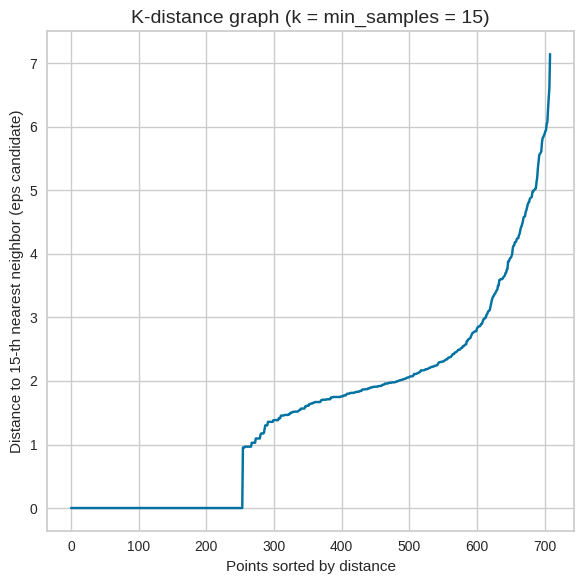

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

def k_distance_plot(X, k, figsize=(6,6)):
    nn = NearestNeighbors(n_neighbors=k, metric="euclidean")
    nn.fit(X)
    distances, _ = nn.kneighbors(X)

    k_dist = np.sort(distances[:, k-1])

    plt.figure(figsize=figsize)
    plt.plot(k_dist)
    plt.title(f'K-distance graph (k = min_samples = {k})', fontsize=14)
    plt.xlabel('Points sorted by distance')
    plt.ylabel(f'Distance to {k}-th nearest neighbor (eps candidate)')
    plt.tight_layout()
    plt.show()

    return k_dist

kdist_5  = k_distance_plot(X, k=5)
kdist_10 = k_distance_plot(X, k=10)
kdist_15 = k_distance_plot(X, k=15)


# Interpretation
In a k distance plot, each point is sorted by its distance to its k-th nearest neighbor, where **k = min_samples**. We look for the knee, the point where the curve changes from slow increase to fast increase.
- 'belowe the knee' points are in dense neighborhoods and are more likely to be core or border points
- 'above the knee' points are increasingly isolated and more likely to become noise

#

We plotted curves for **min_samples = 5, min_samples = 10, and min_samples = 15** to see how strictness changes. Smaller **min_samples** is more lenient and usually gives more clusters and less noise, but clusters can be small or unstable. Larger **min_samples** is stricter and can increase noise, but clusters tend to be more solid if they exist.

# Decision
From the plots, the knee region appears around roughly 1.8 to 2.4 depending on **min_samples**. We choose **min_samples = 10** as our main setting because it is a reasonable balance between being too lenient and too strict. We also test **min_samples = 15** as a stricter robustness check.

#

The goal here is not to find the perfect model from the plot, but rather to define a small, justified search range for eps that is based on the data and not on trial and error.

In [ ]:
min_samples_candidates = [10, 15]

eps_candidates = [1.8, 2.0, 2.2, 2.4]

dbscan_grid = pd.DataFrame(
    [(ms, eps) for ms in min_samples_candidates for eps in eps_candidates],
    columns=["min_samples", "eps"]
)

print("Candidate DBSCAN hyperparameters to test (Step 2 will evaluate each):")
display(dbscan_grid)

Candidate DBSCAN hyperparameters to test (Step 2 will evaluate each):


min_samples  eps
0           10  1.8
1           10  2.0
2           10  2.2
3           10  2.4
4           15  1.8
5           15  2.0
6           15  2.2
7           15  2.4

# Interpretation
This table defines a small and justified set of DBSCAN settings around the knee region. Lower eps should increase noise and create smaller clusters, while higher eps may merge clusters into fewer larger groups. We will pick the final setting based on number of clusters, percent noise, and whether the profiles are easy to interpret.


# Why the grid is small
We keep the grid limited to avoid over searching and to keep the process transparent. Generally:
- **Lower eps** should create smaller clusters and more noise
- **Higher eps** should merge clusters into fewer larger groups and reduce noise




# Fir DBSCAN on parameter grid
We now run DBSCAN for every pair of **min_samples** and eps in our candidate grid and log a small set of checks that tell us if the result is usable.

# Why we do this
DBSCAN is sensitive to its parameters, so we do not want to pick one setting by guessing. These checks help us avoid three common bad outcomes:
- almost everything becomes noise because eps is too small or **min_samples** is too strict
- everything merges into one big cluster because eps is too large
- many tiny clusters that are not stable or interpretable for risk profiles

#

What we log:
- **n_clusters_excl_noise**, number of clusters excluding noise
- **noise percent**, how many points are labeled as noise
- **min cluster size** and **median cluster size** excluding noise, to avoid tiny clusters
- silhouette on non noise points, only when at least two clusters exist


In [ ]:
X = X_ready.values

rows = []
for _, r in dbscan_grid.iterrows():
    ms = int(r["min_samples"])
    eps = float(r["eps"])

    model = DBSCAN(eps=eps, min_samples=ms, metric="euclidean")
    labels = model.fit_predict(X)

    noise_mask = labels == -1
    noise_pct = noise_mask.mean() * 100

    clusters = sorted(set(labels) - {-1})
    n_clusters = len(clusters)

    if n_clusters > 0:
        sizes = pd.Series(labels[~noise_mask]).value_counts()
        min_size = int(sizes.min())
        med_size = float(sizes.median())
    else:
        min_size = 0
        med_size = 0.0

    sil = np.nan
    if n_clusters >= 2:
        X_non = X[~noise_mask]
        y_non = labels[~noise_mask]
        if len(X_non) > n_clusters:
            sil = silhouette_score(X_non, y_non, metric="euclidean")

    rows.append({
        "min_samples": ms,
        "eps": eps,
        "n_clusters_excl_noise": n_clusters,
        "noise_%": noise_pct,
        "min_cluster_size_excl_noise": min_size,
        "median_cluster_size_excl_noise": med_size,
        "silhouette_non_noise": sil
    })

dbscan_eval = pd.DataFrame(rows)

dbscan_eval_sorted = dbscan_eval.sort_values(
    by=["silhouette_non_noise", "noise_%", "min_cluster_size_excl_noise"],
    ascending=[False, True, False]
).reset_index(drop=True)

print("DBSCAN grid results (sorted by silhouette ↓, noise ↑, min cluster size ↓):")
display(dbscan_eval_sorted)

DBSCAN grid results (sorted by silhouette ↓, noise ↑, min cluster size ↓):


min_samples  eps  n_clusters_excl_noise    noise_%  \
0           10  2.4                      1  13.540197   
1           15  2.4                      1  13.681241   
2           10  2.2                      1  14.245416   
3           15  2.2                      1  15.091678   
4           10  2.0                      1  17.066291   
5           15  2.0                      1  18.617772   
6           10  1.8                      1  21.720733   
7           15  1.8                      1  24.682652   

   min_cluster_size_excl_noise  median_cluster_size_excl_noise  \
0                          613                           613.0   
1                          612                           612.0   
2                          608                           608.0   
3                          602                           602.0   
4                          588                           588.0   
5                          577                           577.0   
6                          555                           555.0   
7                          534                           534.0   

   silhouette_non_noise  
0                   NaN  
1                   NaN  
2                   NaN  
3                   NaN  
4                   NaN  
5                   NaN  
6                   NaN  
7                   NaN

# Interpretation
In the first parameter range, DBSCAN produces only one cluster plus noise for all tested settings. Since there is only one cluster, the silhouette score is not defined.

#

This tells us that with eps between 1.8 and 2.4 and **min_samples** of 10 or 15, DBSCAN is not finding multiple dense groups in our data. Increasing eps mainly reduces the amount of noise by absorbing more points into the single large cluster.               

#

We want to test whether DBSCAN can create more than one meaningful group, we refine the search by lowering eps and including a smaller **min_samples** value.

In [ ]:
X = X_ready.values

min_samples_candidates = [5, 10, 15]
eps_candidates = [0.8, 1.0, 1.2, 1.4, 1.6]

rows = []
for ms in min_samples_candidates:
    for eps in eps_candidates:
        model = DBSCAN(eps=eps, min_samples=ms, metric="euclidean")
        labels = model.fit_predict(X)

        noise_mask = labels == -1
        noise_pct = noise_mask.mean() * 100

        clusters = sorted(set(labels) - {-1})
        n_clusters = len(clusters)

        if n_clusters > 0:
            sizes = pd.Series(labels[~noise_mask]).value_counts()
            min_size = int(sizes.min())
            med_size = float(sizes.median())
        else:
            min_size = 0
            med_size = 0.0

        sil = np.nan
        if n_clusters >= 2:
            X_non = X[~noise_mask]
            y_non = labels[~noise_mask]
            if len(X_non) > n_clusters:
                sil = silhouette_score(X_non, y_non, metric="euclidean")

        rows.append({
            "min_samples": ms,
            "eps": eps,
            "n_clusters_excl_noise": n_clusters,
            "noise_%": noise_pct,
            "min_cluster_size_excl_noise": min_size,
            "median_cluster_size_excl_noise": med_size,
            "silhouette_non_noise": sil
        })

dbscan_eval_refined = pd.DataFrame(rows)

dbscan_eval_refined_sorted = dbscan_eval_refined.sort_values(
    by=["n_clusters_excl_noise", "noise_%", "min_cluster_size_excl_noise", "silhouette_non_noise"],
    ascending=[False, True, False, False]
).reset_index(drop=True)

print("DBSCAN refined grid results (prefer more clusters, lower noise, no tiny clusters):")
display(dbscan_eval_refined_sorted)

DBSCAN refined grid results (prefer more clusters, lower noise, no tiny clusters):


min_samples  eps  n_clusters_excl_noise    noise_%  \
0             5  1.2                      9  43.864598   
1             5  1.4                      7  35.401975   
2             5  1.0                      7  50.916784   
3             5  0.8                      7  57.968970   
4            10  1.4                      3  45.416079   
5            10  1.2                      3  53.596615   
6            10  1.0                      3  56.417489   
7            15  1.4                      2  50.493653   
8            15  1.2                      2  57.122708   
9            15  1.0                      2  59.661495   
10           10  0.8                      2  62.764457   
11            5  1.6                      1  24.823695   
12           10  1.6                      1  31.029619   
13           15  1.6                      1  38.222849   
14           15  0.8                      1  64.174894   

    min_cluster_size_excl_noise  median_cluster_size_excl_noise  \
0                             5                            10.0   
1                             3                            17.0   
2                             5                            10.0   
3                             5                             8.0   
4                            27                           106.0   
5                            18                            57.0   
6                            14                            41.0   
7                            97                           175.5   
8                            50                           152.0   
9                            32                           143.0   
10                           10                           132.0   
11                          533                           533.0   
12                          489                           489.0   
13                          438                           438.0   
14                          254                           254.0   

    silhouette_non_noise  
0               0.700423  
1               0.537562  
2               0.793090  
3               0.937028  
4               0.671431  
5               0.810489  
6               0.867128  
7               0.725436  
8               0.863637  
9               0.921576  
10              0.991422  
11                   NaN  
12                   NaN  
13                   NaN  
14                   NaN

# Interpretation
The search shows a clear trade off:
- when **min_samples** is low, DBSCAN can create more clusters, but it also creates many tiny clusters and a high noise percentage. Those solutions are not stable or interpretable enough for risk profiles.
- when **min_samples** is higher or eps is larger, noise decreases, but the solution becomes too broad, often collapsing to one cluster or only a couple of clusters.

#

We select **min_samples** equals 10 and eps equals 1.4 as a practical compromise. It produces multiple clusters while avoiding very tiny groups and keeping cluster sizes reasonably large. Even though the noise percentage remains high, this setting is the most usable option in our tested range if we want DBSCAN to produce interpretable segments.

# Fit the final DBSCAN model
We now fit DBSCAN once using the chosen hyperparameters on the full **X_ready** matrix and store the labels in a final dataframe. This freezes one DBSCAN solution so all the next steps use the same results.

#

DBSCAN can assign label minus one to noise or outliers. This is expected and we always report it explicitly, because it affects how useful the segmentation is.



In [ ]:
EPS_FINAL = 1.4
MIN_SAMPLES_FINAL = 10

dbscan_final = DBSCAN(eps=EPS_FINAL, min_samples=MIN_SAMPLES_FINAL, metric="euclidean")
dbscan_labels = dbscan_final.fit_predict(X_ready.values)

df_dbscan_final = df_fe.copy()
df_dbscan_final["cluster_dbscan"] = dbscan_labels

print(f"DBSCAN fitted with eps={EPS_FINAL}, min_samples={MIN_SAMPLES_FINAL}")
print("Unique labels (including noise=-1):", np.sort(df_dbscan_final["cluster_dbscan"].unique()))

DBSCAN fitted with eps=1.4, min_samples=10
Unique labels (including noise=-1): [-1  0  1  2]


# Interpretation
With **eps = 1.4** and **min_samples = 10**, DBSCAN finds three clusters and also a noise group. This confirms that, at this density level, the data contains a few dense structures, while many departments do not belong to any dense region.

# Cluster size distribution
We report the count and percentage for every DBSCAN label, including noise, and we compute the overall noise percentage.

#

We do this because DBSCAN does not cluster everyone. To compare fairly with k-means and agglomerative, we need to show how much of the dataset is clustered versus left as noise, and whether the clusters are large enough to interpret.

In [ ]:
label_col = "cluster_dbscan"

counts_all = df_dbscan_final[label_col].value_counts().sort_index()
perc_all = (df_dbscan_final[label_col].value_counts(normalize=True) * 100).sort_index().round(2)

noise_pct = (df_dbscan_final[label_col] == -1).mean() * 100

print(f"\nNoise percentage (-1): {noise_pct:.2f}%")

cluster_size_dbscan = pd.DataFrame({"count": counts_all, "percent": perc_all})
display(cluster_size_dbscan)


Noise percentage (-1): 45.42%


count  percent
cluster_dbscan                
-1                322    45.42
 0                 27     3.81
 1                254    35.83
 2                106    14.95

# Interpretation
Noise is 45.42%, meaning almost half of the departments are not in a dense enough region under this eps and min_samples. This is not an error, but it is a key result, DBSCAN is not producing a full segmentation of all departments in this feature space.
#
For the departments that are clustered, DBSCAN identifies:
- **Cluster 1** as the main dense core group with 254 departments, about 35.83%
- **Cluster 2** as a second group with 106 departments, about 14.95%
- **Cluster 0** as a smaller but still interpretable group with 27 departments, about 3.81%

#

Compared to k-means and agglomerative, which assign every department to a cluster, DBSCAN behaves more like dense groups plus outliers. This can still be useful if the noise group captures unusual or high attention profiles, but it is less suited for building a complete set of balanced risk profiles because a large share of departments remains unclustered

# Numerical profiling
We profile DBSCAN clusters by computing the mean of the same numerical features used in the other clustering methods. We also compute the profile of the noise points separately.

#

We reuse the same feature list **num_for_clustering** to keep the comparison fair. Noise is profiled on its own because DBSCAN uses label minus one to collect points that do not belong to any dense group, and these can be the most unusual departments.

In [ ]:
num_cols = num_for_clustering

df_non_noise = df_dbscan_final[df_dbscan_final[label_col] != -1].copy()
profile_num = df_non_noise.groupby(label_col)[num_cols].mean().round(3)

sizes_non_noise = df_non_noise[label_col].value_counts().sort_index()
profile_num.insert(0, "cluster_size", sizes_non_noise.values)

print("=== Numerical profile (DBSCAN clusters, excluding noise) ===")
display(profile_num)

df_noise = df_dbscan_final[df_dbscan_final[label_col] == -1].copy()
if len(df_noise) > 0:
    noise_profile = df_noise[num_cols].mean().to_frame("noise_mean").round(3)
    print("\n=== Numerical profile (Noise / outliers, label=-1) ===")
    display(noise_profile)
else:
    print("\nNo noise points found (label=-1).")

=== Numerical profile (DBSCAN clusters, excluding noise) ===


cluster_size  risk_exposure_operational  \
cluster_dbscan                                            
0                         27                      1.111   
1                        254                      1.000   
2                        106                      1.038   

                risk_exposure_financial  operational_health_index  \
cluster_dbscan                                                      
0                                 1.630                     4.593   
1                                 2.000                     4.000   
2                                 1.623                     3.868   

                violations_past_3years  reporting_gaps_annual  \
cluster_dbscan                                                  
0                                0.000                  2.667   
1                                0.000                  2.000   
2                                0.028                  2.566   

                reporting_lag_days  training_hours_quarterly  
cluster_dbscan                                                
0                            1.074                    34.074  
1                            1.000                    40.000  
2                            1.132                    44.528


=== Numerical profile (Noise / outliers, label=-1) ===


noise_mean
risk_exposure_operational       1.848
risk_exposure_financial         2.615
operational_health_index        3.345
violations_past_3years          0.540
reporting_gaps_annual           5.742
reporting_lag_days              1.823
training_hours_quarterly       43.047

# Interpretation
The three DBSCAN clusters excluding noise look like low incident and relatively stable groups.

- **Cluster 1** is the main baseline group. It has zero violations and relatively low reporting gaps and lag

- **Cluster 2** is similar to the baseline but slightly different in operational performance and training, so it looks like a mild variant rather than a completely different profile

- **Cluster 0** is small but still meaningful. It has very strong operational performance and clean behavior indicators, so it looks like an especially stable subgroup

The most important result is the noise profile. Compared to the clustered groups, noise has higher risk exposure, higher violations, larger reporting gaps, and higher reporting lag. This suggests that with our chosen eps and min_samples, DBSCAN is not splitting the dataset into many different risk profiles. Instead, it separates a clean dense core from a more heterogeneous set of departments that do not form stable dense groups and may require closer monitoring.

# Categorical profiling
We now profile DBSCAN clusters using the categorical variables. For each categorical feature, we compute the percentage breakdown inside each cluster. We also compute the same breakdown for the noise group separately.

#

We reuse the same categorical feature list **cat_for_clustering** as in k-means and agglomerative. Profiling noise separately matters because DBSCAN outliers can be concentrated in specific organizational contexts.

In [ ]:
cat_cols = cat_for_clustering

print("=== Categorical profile (DBSCAN clusters, excluding noise) ===")
for col in cat_cols:
    print(f"\n--- {col} (% per cluster) ---")
    tab = pd.crosstab(df_non_noise[label_col], df_non_noise[col], normalize="index") * 100
    display(tab.round(2))

print("\n=== Categorical profile (Noise / outliers, label=-1) ===")
if len(df_noise) > 0:
    for col in cat_cols:
        print(f"\n--- {col} (% within noise) ---")
        tab_noise = (df_noise[col].value_counts(normalize=True) * 100).round(2)
        display(tab_noise.to_frame("percent"))
else:
    print("No noise points to profile.")

=== Categorical profile (DBSCAN clusters, excluding noise) ===

--- dept_category (% per cluster) ---


dept_category   Financial_Reporting  Operational_Compliance
cluster_dbscan                                             
0                             100.0                     0.0
1                               0.0                   100.0
2                             100.0                     0.0


--- division (% per cluster) ---


division        Corporate_HQ
cluster_dbscan              
0                      100.0
1                      100.0
2                      100.0


--- team_size (% per cluster) ---


team_size       Large
cluster_dbscan       
0               100.0
1               100.0
2               100.0


--- dept_type (% per cluster) ---


dept_type       Operations  Support
cluster_dbscan                     
0                    100.0      0.0
1                      0.0    100.0
2                      0.0    100.0


=== Categorical profile (Noise / outliers, label=-1) ===

--- dept_category (% within noise) ---


percent
dept_category                  
Financial_Reporting       88.82
Risk_Management            7.45
Operational_Compliance     3.73


--- division (% within noise) ---


percent
division                    
Corporate_HQ           91.61
Regional_Operations     8.39


--- team_size (% within noise) ---


percent
team_size         
Large        57.45
Small        36.65
Medium        5.90


--- dept_type (% within noise) ---


percent
dept_type          
Support       44.10
Operations    38.20
Technology     5.59
Finance        4.35
Legal          4.35
Compliance     3.42

# Interpretation
The DBSCAN clusters are very structurally pure, meaning they look more like clear organizational blocks than mixed profiles:
- **Cluster 1** is fully Operational_Compliance and fully Support
- **Clusters 0 and 2** are fully Financial_Reporting, and they differ by dept_type:
  - **Cluster 0** is Operations
  - **Cluster 2** is Support

#

In addition, for the clustered points, **division** is always **Corporate_HQ** and **team_size** is always **Large**. This suggests that at this parameter setting, DBSCAN is mainly clustering a very homogeneous core and is not separating departments along those two dimensions.

#

The noise group is more diverse. It includes categories like **Risk_Management and Regional_Operations**, has mixed team sizes including Small and Medium, and shows more variety in **dept_type**. This supports the idea that DBSCAN is only confident about a few very dense and homogeneous regions, while departments with more complex structures are treated as noise.

# Combined interpretation
Putting numerical and categorical profiling together, DBSCAN behaves less like a full segmentation method and more like a dense core plus outliers detector. The clusters it finds are stable and low risk, while much of the risk differentiation appears in the noise group, which is more heterogeneous and shows higher exposure and reporting problems.


K-means and agglomerative remain more useful for a full set of risk profiles because they segment all departments and produce clearer multi cluster structures. DBSCAN is still useful as a complementary view, because it provides an explicit investigate group made of outliers that may deserve closer monitoring.

# PCA plot
We use PCA with 2 components to visualize the DBSCAN result in a simple 2D map. The main goal here is to see how the clusters and the noise points are distributed after dimensionality reduction. This is only a visual check and does not affect the DBSCAN model.

#

We run PCA on the same **X_ready matrix** used for DBSCAN, so the plot is consistent with the clustering input. We also keep noise as its own label, because noise is a key part of how DBSCAN works.

Explained variance PC1/PC2 (%): [29.17 15.52] | Total (%): 44.69


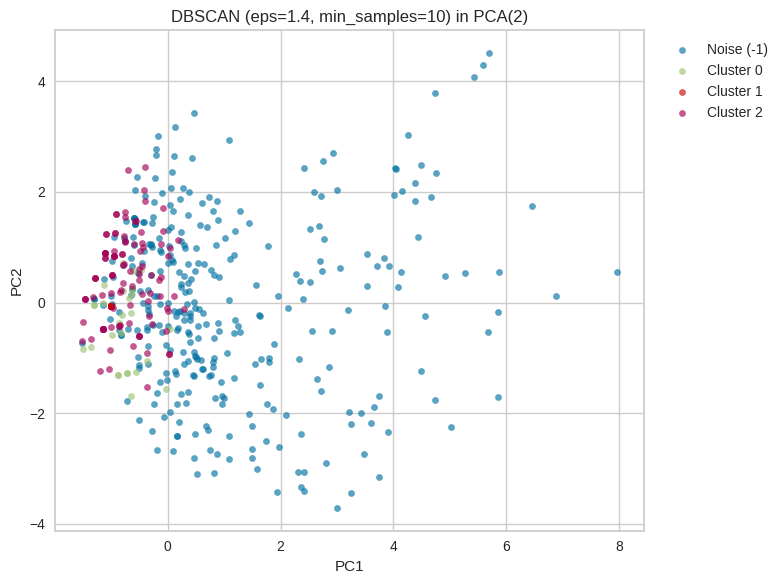

In [ ]:
pca2 = PCA(n_components=2, random_state=42)
X_pca = pca2.fit_transform(X_ready.values)

print(
    "Explained variance PC1/PC2 (%):",
    (pca2.explained_variance_ratio_ * 100).round(2),
    "| Total (%):",
    round(pca2.explained_variance_ratio_.sum() * 100, 2)
)

X_pca_df = pd.DataFrame(X_pca, columns=["PC1", "PC2"], index=X_ready.index)

labels = df_dbscan_final.loc[X_ready.index, label_col].to_numpy()
unique_labels = np.sort(np.unique(labels))

plt.figure(figsize=(8,6))
for lab in unique_labels:
    mask = labels == lab
    name = "Noise (-1)" if lab == -1 else f"Cluster {lab}"
    plt.scatter(
        X_pca_df.loc[mask, "PC1"],
        X_pca_df.loc[mask, "PC2"],
        s=20, alpha=0.65,
        label=name
    )

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title(f"DBSCAN (eps={EPS_FINAL}, min_samples={MIN_SAMPLES_FINAL}) in PCA(2)")
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()

# Interpretation
In this plot, the noise points are spread widely across the PCA space. This matches our earlier result where a large share of departments was labeled as noise. DBSCAN is basically saying these points do not belong to any dense core region, so they do not form compact groups in the projection either.

#

The three DBSCAN clusters appear as small, compact pockets, mostly on the left side of the plot. This is consistent with our profiling results, where clusters 0, 1, and 2 were very homogeneous. Dense and homogeneous groups usually appear as tight blobs in a PCA plot.

#

Link to profiling:
- the clustered groups are clean and structurally uniform, so they stay compact
- the noise group is more heterogeneous and shows higher risk drivers on average, so it appears more scattered

#

This visualization supports the conclusion that DBSCAN is working mainly as dense cores plus outliers. It does not create many different risk profiles like k-means or agglomerative, but it can still be useful if we treat noise as an investigate group for departments that do not fit the stable core patterns.

# External validation and risk levels
For k-means and agglomerative, every department is assigned to a cluster, so external validation is straightforward. With DBSCAN, some departments are labeled as noise with label minus one. This changes how we validate and how we assign risk levels.

What changes with DBSCAN, we:
- compute validation results for the non noise clusters and we also report noise separately
- assign noise to a dedicated category called Investigate instead of Low Medium High
- always report the noise percentage because it affects how usable DBSCAN is compared to full segmentation methods

In [ ]:
LABEL_COL = "cluster_dbscan"
COMPLIANCE_COL = "compliance_score_final"

df_nn = df_dbscan_final[df_dbscan_final[LABEL_COL] != -1].copy()
df_noise = df_dbscan_final[df_dbscan_final[LABEL_COL] == -1].copy()

noise_pct = 100 * (len(df_noise) / len(df_dbscan_final))
print(f"DBSCAN noise points: {len(df_noise)} / {len(df_dbscan_final)} ({noise_pct:.1f}%)")

val_dbscan = (
    df_nn.groupby(LABEL_COL)[COMPLIANCE_COL]
    .agg(count="count", mean="mean", median="median", std="std")
    .sort_values("median")
)
display(val_dbscan)

noise_stats = df_noise[COMPLIANCE_COL].agg(count="count", mean="mean", median="median", std="std")
print("Noise (-1) compliance_score_final stats:", noise_stats.to_dict())

N_HIGH = 1
N_LOW  = 1

val_dbscan["risk_bucket_base"] = "Medium"
if len(val_dbscan) >= (N_HIGH + N_LOW):
    val_dbscan.iloc[:N_HIGH, val_dbscan.columns.get_loc("risk_bucket_base")] = "High"
    val_dbscan.iloc[-N_LOW:, val_dbscan.columns.get_loc("risk_bucket_base")] = "Low"
else:
    val_dbscan["risk_bucket_base"] = "Medium"

RF1 = "violations_past_3years"
RF2 = "reporting_lag_days"

val_dbscan["risk_bucket"] = val_dbscan["risk_bucket_base"]

if RF1 in df_nn.columns and RF2 in df_nn.columns and len(val_dbscan) > 0:
    rf1_thr = df_nn[RF1].quantile(0.80)
    rf2_thr = df_nn[RF2].quantile(0.80)

    rf_medians = df_nn.groupby(LABEL_COL)[[RF1, RF2]].median()
    val_dbscan[f"{RF1}_median"] = val_dbscan.index.map(rf_medians[RF1])
    val_dbscan[f"{RF2}_median"] = val_dbscan.index.map(rf_medians[RF2])

    val_dbscan.loc[
        (val_dbscan["risk_bucket"] == "Low") &
        ((val_dbscan[f"{RF1}_median"] >= rf1_thr) | (val_dbscan[f"{RF2}_median"] >= rf2_thr)),
        "risk_bucket"
    ] = "Low-Medium"

    val_dbscan.loc[
        (val_dbscan["risk_bucket"] == "Medium") &
        ((val_dbscan[f"{RF1}_median"] >= rf1_thr) & (val_dbscan[f"{RF2}_median"] >= rf2_thr)),
        "risk_bucket"
    ] = "High"

display(val_dbscan[["count","median","risk_bucket_base","risk_bucket"]].sort_values("median"))

df_dbscan_final["risk_bucket"] = "Investigate"
df_dbscan_final.loc[df_dbscan_final[LABEL_COL] != -1, "risk_bucket"] = (
    df_dbscan_final.loc[df_dbscan_final[LABEL_COL] != -1, LABEL_COL].map(val_dbscan["risk_bucket"])
)

display(df_dbscan_final[[LABEL_COL, "risk_bucket"]].value_counts().reset_index(name="n"))

DBSCAN noise points: 322 / 709 (45.4%)


count       mean  median        std
cluster_dbscan                                     
0                  27  64.629630    65.0  11.173968
1                 254  65.000000    65.0   0.000000
2                 106  66.084906    65.0  11.401853

Noise (-1) compliance_score_final stats: {'count': 322.0, 'mean': 63.269254658385094, 'median': 65.0, 'std': 14.063758423706226}


count  median risk_bucket_base risk_bucket
cluster_dbscan                                            
0                  27    65.0             High        High
1                 254    65.0           Medium        High
2                 106    65.0              Low  Low-Medium

cluster_dbscan  risk_bucket    n
0              -1  Investigate  322
1               1         High  254
2               2   Low-Medium  106
3               0         High   27

# Interpretation of compliance based validation
DBSCAN has high noise coverage, about 45.4%. For the remaining clusters, **compliance_score_final** does not clearly separate them, because the median is 65.0 for all three clusters. This means that, unlike k-means and agglomerative, DBSCAN is not creating clear outcome based low and high segments using this compliance outcome.

For that reason, the risk level mapping is less informative for DBSCAN clusters. The main operational meaning comes from treating noise as Investigate, because DBSCAN is telling us those points do not belong to any stable dense group.

# Validation using the database high risk list
To add a stronger external check, we compare DBSCAN clusters with the database high risk list. We report results in two ways:
- including noise, to show where all departments end up
- excluding noise, to evaluate only the clusters DBSCAN considers meaningful segments

In [ ]:
df_dbscan_hr = add_high_risk_flag(df_dbscan_final, dept_id_col="dept_id")

dbscan_risk_incl_noise = (
    df_dbscan_hr.groupby("cluster_dbscan")["is_high_risk_db"]
    .agg(
        n="size",
        high_risk_n="sum",
        high_risk_pct=lambda s: 100 * s.mean()
    )
    .sort_values("high_risk_pct", ascending=False)
)

print("DBSCAN: including noise cluster (-1)")
display(dbscan_risk_incl_noise.round(2))

DBSCAN: including noise cluster (-1)


n  high_risk_n  high_risk_pct
cluster_dbscan                                 
-1              322          173          53.73
 2              106           29          27.36
 0               27            7          25.93
 1              254            8           3.15

In [ ]:
df_dbscan_no_noise = df_dbscan_hr[df_dbscan_hr["cluster_dbscan"] != -1].copy()

dbscan_risk_excl_noise = (
    df_dbscan_no_noise.groupby("cluster_dbscan")["is_high_risk_db"]
    .agg(
        n="size",
        high_risk_n="sum",
        high_risk_pct=lambda s: 100 * s.mean()
    )
    .sort_values("high_risk_pct", ascending=False)
)

print("DBSCAN: excluding noise (-1)")
display(dbscan_risk_excl_noise.round(2))

DBSCAN: excluding noise (-1)


n  high_risk_n  high_risk_pct
cluster_dbscan                                 
2               106           29          27.36
0                27            7          25.93
1               254            8           3.15

# Interpretation
The database check shows a clear pattern. The noise group has the highest concentration of high risk departments, 173 out of 322, about 53.73%. In contrast, the DBSCAN clusters have lower high risk rates. Cluster 1 is especially low at about 3.15 percent, while clusters 0 and 2 are around 26% to 27%.

#

DBSCAN is mainly capturing higher risk departments as outliers rather than grouping them into clear clusters. This makes DBSCAN less suitable as the main method for building a small set of complete risk profiles, because it leaves almost half the dataset in the Investigate group. However, it can still be useful as a complementary tool, because it highlights a large set of departments that may deserve deeper review.

# **Final Comparison of Clustering Methods**
We compare k-means, ward agglomerative, and DBSCAN using the same input data **X_ready**. This keeps the comparison fair because all methods see the same features, encoding, and scaling.

#

For our Compliance Radar goal, the best method is not the one with the highest internal score, but the one that creates segments that are usable in practice, meaning full coverage, reasonable number of groups, and clear profiles that can be explained.

# What we compare
We combine three tyoes of evidence.

## Internal metrics
These measure how compact and separated clusters are in the feature space. They are helpful, but they do not guarantee that clusters are meaningful for compliance risk.

## Practical usability
We check the number of groups, cluster size balance, and for DBSCAN the noise percentage, because high noise reduces coverage.

## External validation
We also check **compliance_score_final**, which was not used to create clusters. This tells us whether clusters differ on an independent compliance outcome, which is more relevant for a risk oriented interpretation.

In [ ]:
from sklearn.metrics import (
    silhouette_score, silhouette_samples,
    davies_bouldin_score, calinski_harabasz_score
)

def summarize_clustering(X, labels, model_name, params="", noise_label=-1):
    labels = np.asarray(labels)

    has_noise = np.any(labels == noise_label)
    noise_pct = float(np.mean(labels == noise_label) * 100) if has_noise else 0.0

    if has_noise:
        mask = labels != noise_label
        X_eval = X[mask]
        lab_eval = labels[mask]
    else:
        X_eval = X
        lab_eval = labels

    unique_clusters = np.unique(lab_eval)
    n_clusters = len(unique_clusters)

    if n_clusters > 0:
        sizes = pd.Series(lab_eval).value_counts()
        min_size = int(sizes.min())
        med_size = float(sizes.median())
    else:
        min_size = np.nan
        med_size = np.nan

    sil = np.nan
    neg_sil_pct = np.nan
    dbi = np.nan
    chi = np.nan

    if n_clusters >= 2 and len(lab_eval) >= 3:
        sil = float(silhouette_score(X_eval, lab_eval))
        sil_samp = silhouette_samples(X_eval, lab_eval)
        neg_sil_pct = float(np.mean(sil_samp < 0) * 100)
        dbi = float(davies_bouldin_score(X_eval, lab_eval))
        chi = float(calinski_harabasz_score(X_eval, lab_eval))

    return {
        "model": model_name,
        "params": params,
        "n_clusters_excl_noise": n_clusters,
        "noise_%": noise_pct,
        "min_cluster_size_excl_noise": min_size,
        "median_cluster_size_excl_noise": med_size,
        "silhouette_eval": sil,
        "neg_silhouette_%": neg_sil_pct,
        "davies_bouldin_eval": dbi,
        "calinski_harabasz_eval": chi
    }

X = X_ready.values

rows = []
rows.append(summarize_clustering(
    X, df_kmeans["cluster_kmeans"].values,
    model_name="KMeans", params="k=7"
))

rows.append(summarize_clustering(
    X, df_agglo_final["cluster_agglo"].values,
    model_name="Agglomerative", params="ward, k=7"
))

rows.append(summarize_clustering(
    X, df_dbscan_final["cluster_dbscan"].values,
    model_name="DBSCAN", params="eps=1.4, min_samples=10"
))

comparison_df = pd.DataFrame(rows).set_index("model")
comparison_df

params  n_clusters_excl_noise    noise_%  \
model                                                                      
KMeans                             k=7                      7   0.000000   
Agglomerative                ward, k=7                      7   0.000000   
DBSCAN         eps=1.4, min_samples=10                      3  45.416079   

               min_cluster_size_excl_noise  median_cluster_size_excl_noise  \
model                                                                        
KMeans                                  27                            82.0   
Agglomerative                           29                            76.0   
DBSCAN                                  27                           106.0   

               silhouette_eval  neg_silhouette_%  davies_bouldin_eval  \
model                                                                   
KMeans                0.382239         24.118477             1.622456   
Agglomerative         0.356989         30.747532             1.753867   
DBSCAN                0.671431         13.695090             1.462946   

               calinski_harabasz_eval  
model                                  
KMeans                     121.586028  
Agglomerative              102.729799  
DBSCAN                     147.312966

# Interpretation

## Coverage and number of groups
K-means and ward agglomerative both produce 7 clusters with zero noise, so every department is assigned to a group. This is ideal for a Compliance Radar because it gives a complete segmentation. DBSCAN finds only 3 clusters and labels about 45% as noise, so it is less suitable as a standalone segmentation method.

## Cluster size balance
K-means and agglomerative have similar minimum and median cluster sizes, which supports interpretability because clusters are not extremely tiny. DBSCAN has fewer clusters and many points are excluded as noise, so its size statistics are not directly comparable.

## Internal quality
DBSCAN looks strong on internal metrics for the non noise points, which means the clusters it keeps are compact and separated. However, these metrics do not reflect the cost of lower coverage and lower granularity. K-means and agglomorative have moderate internal scores, but they provide a more useful structure for building multiple profiles.

## External validation and risk level usability
K-means and agglomerative produced clearer outcome based extremes and allowed a coherent risk level mapping with full coverage. DBSCAN showed weaker separation on compliance_score_final across its clusters, and its main operational value came from the Investigate noise group rather than from multiple distinct risk profiles.

#

# Conclusion
For the Compliance Radar objective, k-means with k = 7 is the most suitable primary clustering method, with agglomerative as a strong robustness check. DBSCAN is best used as a complementary tool, mainly to flag outliers in the Investigate group and to identify a small number of very dense core clusters.

## **Algorithms Analysis**

## 1. K-Means Clustering  
*(Risk segmentation by average profiles)*

### What the algorithm does (managerial view)
K-Means partitions departments into groups by minimizing within-group differences around a central **“average” profile**. Each department is assigned to exactly one cluster.

### What it reveals managerially
- Identifies clear and stable risk segments across the organization.  
- Produces clusters of comparable size, making them easy to communicate and operationalize.  
- Highlights typical compliance profiles (e.g. low-risk baseline, high-risk concentration).

### Strengths from a managerial standpoint
- **Highly interpretable:** clusters can be summarized using averages and dashboards.  
- **Actionable:** every department is assigned to a group, enabling full coverage.  
- Well-suited for resource allocation and reporting.

### Limitations to acknowledge
- Forces all departments into a cluster, even if some behave atypically.  
- Less sensitive to extreme or anomalous behaviors.

### Managerial takeaway
K-Means is ideal for establishing a **first-level compliance segmentation** that management can easily understand, monitor, and embed into governance processes.



## 2. Agglomerative (Hierarchical) Clustering  
*(Structure-aware organizational grouping)*

### What the algorithm does (managerial view)
Agglomerative clustering builds clusters progressively, revealing how departments merge based on similarity, forming a **hierarchical structure**.

### What it reveals managerially
- Shows natural groupings and sub-groupings within the organization.  
- Highlights gradual transitions between low, medium, and high-risk profiles.  
- Helps understand relative similarity between departments, not just final labels.

### Strengths from a managerial standpoint
- Provides richer structural insight than flat clustering.  
- Supports strategic decisions, such as defining escalation thresholds.  
- Helps justify why certain departments are closer to high-risk profiles than others.

### Limitations to acknowledge
- Less intuitive for non-technical stakeholders.  
- Final number of clusters requires managerial judgment, not automatic selection.

### Managerial takeaway
Agglomerative clustering is particularly valuable for **diagnosis and explanation**, helping management understand how risk profiles differ and where boundaries between groups naturally lie.



## 3. DBSCAN  
*(Anomaly and outlier detection)*

### What the algorithm does (managerial view)
DBSCAN identifies clusters based on density, isolating departments that do not belong to any dense group as **outliers**.

### What it reveals managerially
- Detects exceptional departments with unusual combinations of risk factors.  
- Identifies units that do not conform to standard organizational patterns.  
- Surfaces potentially hidden or emerging risks.

### Strengths from a managerial standpoint
- Does not force classification of all departments.  
- Excellent for early-warning detection.  
- Complements segmentation-focused approaches.

### Limitations to acknowledge
- Sensitive to parameter choices.  
- Produces fewer, less stable clusters in heterogeneous organizational data.  
- Not suitable as a stand-alone governance segmentation.

### Managerial takeaway
DBSCAN is best viewed as a **risk radar**, not a primary segmentation tool. It is useful for flagging departments that warrant individual review, rather than for broad policy design.

##**Clustering Analysis, from a managerial point of view**

Now we analyze each single cluster obtain using K-means, the definative model choose to  uncover patterns that may indicate compliance challenges or ethical inconsistencies across departments.

Departments were segmented into **seven clusters (Cluster 0–6)** based on structural, behavioral, and pressure-related variables.  
Cluster labels are numeric and algorithmic; therefore, managerial interpretation focuses on what each cluster represents in **organizational terms**, not on the labels themselves.

The clustering uses only **actionable drivers**:
- Incidents  
- Audits  
- Reporting  
- Process gaps  
- Operational load  
- Financial pressure  

The **final compliance score** is used *ex post* to validate relevance, not to form the clusters.



# Cluster 2: Baseline and Low-Risk Departments

Cluster 2 represents the **largest and most stable group** in the organization. Departments in this cluster exhibit:
- Low incident counts  
- Solid audit scores  
- Limited process gaps  
- Moderate pressure levels  

Their final compliance scores are **consistently high**.

**Managerial interpretation:**  
This cluster defines the **organizational baseline**. These departments are not risk-free, but their governance mechanisms function as intended. They require routine monitoring rather than targeted intervention and can be used as **internal benchmarks**.



# Cluster 3: Training-Intensive, Compliance-Mature Departments

Cluster 3 shows similarly low incident levels but stands out for:
- High reporting frequency  
- Strong audit outcomes  
- Relatively high engagement indicators  

**Managerial interpretation:**  
These departments reflect a **strong compliance culture**, where transparency and awareness play a central role. Higher reporting does not translate into higher risk, confirming that reporting is a **protective mechanism**, not a failure signal.



# Cluster 6: Low-Risk with Minor Process Gaps

Departments in Cluster 6 maintain low incident levels and acceptable compliance scores but display:
- Slightly elevated process gap scores  
- Mild structural inefficiencies  

**Managerial interpretation:**  
This cluster is largely healthy but shows **early signs of structural drift**. Preventive, low-cost process improvements could avoid future deterioration. It represents a **monitor-and-fix** category.



# Cluster 0: High Exposure but Controlled

Cluster 0 is characterized by:
- Elevated operational load and/or financial pressure  
- Moderate incident counts  
- Reasonable audit scores  

Despite high exposure, compliance outcomes remain acceptable.

**Managerial interpretation:**  
Risk here is **contextual rather than structural**. These departments perform well under stress but are vulnerable to overload. Management should focus on **capacity planning and pressure management**, not punitive controls.



# Cluster 4: Operationally Fragile Departments

Cluster 4 departments display:
- Moderate to high process gaps  
- Weaker audit outcomes  
- Only partially elevated incident counts  

**Managerial interpretation:**  
This cluster signals **latent compliance risk**. Problems are embedded in processes and controls but have not yet fully materialized. It represents the **highest preventive leverage** for management action.



# Cluster 1: Process & Reporting Breakdown

Cluster 1 shows:
- Very high process gap scores  
- Low reporting frequency  
- Weak audit performance  

Incident counts are not always extreme, suggesting **hidden risk**.

**Managerial interpretation:**  
This cluster is particularly dangerous because risk is **structurally concealed**. Low transparency combined with weak processes means issues may surface late and abruptly. These departments require **structural redesign and reporting reinforcement**, not just monitoring.



# Cluster 5: High-Risk and Incident-Heavy Departments

Cluster 5 represents the **most critical risk segment**. It is characterized by:
- High incident counts  
- Weak audits  
- Strong process gaps  
- High operational and financial pressure  

These departments also show the **lowest final compliance scores**.

**Managerial interpretation:**  
This cluster reflects **systemic governance failure** rather than isolated issues. Immediate intervention, escalation, and possibly **external oversight** are warranted.



# Managerial Takeaway from Segmentation

The explicit mapping of clusters (0–6) reveals that **compliance risk is categorical, not continuous**. Departments fall into distinct governance regimes, each requiring a different managerial response.

This segmentation enables the organization to:
- Prioritize interventions rationally  
- Allocate compliance resources efficiently  
- Shift from reactive incident management to **risk-based governance**

#**Prediction**

In this section, we formulate a supervised learning task to **predict which departments are at high compliance risk**.  
The objective is to build a model that, given departmental indicators (numeric and categorical; e.g., reporting gaps, violations, training, governance, operational metrics), can flag departments that are likely to belong to the **high-risk group**.

To ensure a robust and fair evaluation, we will:
- define a binary target label (*high risk* vs *not high risk*) derived from compliance_score_final,
- perform a **stratified train, validation, test split**, keeping the test set untouched until the final evaluation,
- apply preprocessing **fitted only on the training data** to avoid data leakage (median imputation + scaling for numeric features, most-frequent imputation + one-hot encoding for categorical features),
- compare at least **three different classifiers**, with particular attention to the high-risk class (we prioritize **recall** to minimize false negatives).


# Target definition

In [ ]:
df_pred = df_dept.copy()
df_pred = df_pred.dropna(subset=["compliance_score_final"]).copy()

q = 0.25
threshold = df_pred["compliance_score_final"].quantile(q)

df_pred["y_high_risk"] = (df_pred["compliance_score_final"] <= threshold).astype(int)

print(f"Threshold (quantile {q:.2f}) = {threshold:.4f}")
print("Class distribution y_high_risk:")
print(df_pred["y_high_risk"].value_counts())
print("Percentages:")
print(df_pred["y_high_risk"].value_counts(normalize=True).round(3))


Threshold (quantile 0.25) = 55.0000
Class distribution y_high_risk:
y_high_risk
0    285
1    148
Name: count, dtype: int64
Percentages:
y_high_risk
0    0.658
1    0.342
Name: proportion, dtype: float64


We derive the binary target **y_high_risk** from **compliance_score_final** by labeling a department as high risk if its score is **at or below the 25th percentile.**

In our data, the 25th percentile threshold is 55. Because many departments have exactly 55, using the rule 'score ≤ threshold' includes all tied values at the cutoff. As a result, the positive class is 34.2%, rather than exactly 25%.




In [ ]:
drop_cols = ["compliance_score_final", "y_high_risk", "dept_id", "dept_name"]

X = df_pred[num_features + cat_features].copy()
X = X.drop(columns=[c for c in drop_cols if c in X.columns], errors="ignore")

y = df_pred["y_high_risk"].copy()

print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (433, 34)
y shape: (433,)


To prevent target leakage, compliance_score_final (and identifier fields such as dept_id / dept_name) is **never used as an input feature**.  
We build the feature matrix X using both the selected numeric predictors (num_features) and categorical predictors (cat_features), and set y as the binary label y_high_risk.

We obtain a feature matrix X with 433 departments and 34 input features (before one-hot encoding), and a target vector y of the same length.


# Train, Validation, and Test split

In [ ]:
from sklearn.model_selection import train_test_split
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.25, random_state=42, stratify=y_trainval
)

print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")
print("\nTrain class distribution:")
print(y_train.value_counts(normalize=True).round(3))
print("\nVal class distribution:")
print(y_val.value_counts(normalize=True).round(3))
print("\nTest class distribution:")
print(y_test.value_counts(normalize=True).round(3))


Train: (259, 34), Val: (87, 34), Test: (87, 34)

Train class distribution:
y_high_risk
0    0.66
1    0.34
Name: proportion, dtype: float64

Val class distribution:
y_high_risk
0    0.655
1    0.345
Name: proportion, dtype: float64

Test class distribution:
y_high_risk
0    0.655
1    0.345
Name: proportion, dtype: float64


We split the dataset into **training, validation, and test** sets using stratified sampling so that the proportion of high risk departments is preserved across splits. We first hold out 20% of the data as an untouched test set, then split the remaining 80% into train and validation.

This produces **Train = 259, Validation = 87, and Test = 87 departments**. The high risk rate remains stable at about 34% in each split, so model comparisons are not driven by changes in class balance.




In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import inspect

num_features_model = [c for c in num_features if c in X.columns]
cat_features_model = [c for c in cat_features if c in X.columns]

ohe_kwargs = {"handle_unknown": "ignore"}
if "sparse_output" in inspect.signature(OneHotEncoder).parameters:
    ohe_kwargs["sparse_output"] = False
else:
    ohe_kwargs["sparse"] = False

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(**ohe_kwargs))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_features_model),
        ("cat", categorical_transformer, cat_features_model)
    ],
    remainder="drop"
)

print("Preprocessing pipeline ready (imputation + scaling + one-hot).")


Preprocessing pipeline ready (imputation + scaling + one-hot).


# Interpretation
The split gives 259 training, 87 validation, and 87 test departments. The high risk rate stays around 34% in all splits, so performance differences are not caused by class imbalance changes between sets.

# Preprocessing (missing values, scaling, and encoding)

Before training the classifiers, we apply preprocessing through a pipeline to ensure that the same transformations are applied consistently to train, validation, and test.
- **Numeric features:** missing values are imputed using the median, then standardized with StandardScaler

- **Categorical features:** missing values are imputed with the most frequent category, then converted using one-hot encoding

Preprocessing is **fit only on the training folds within a piepeline** and then applied to validation and test to avoid data leakage

# Baseline models

=== Logistic Regression (num+cat) (VAL) ===
              precision    recall  f1-score   support

           0      0.943     0.877     0.909        57
           1      0.794     0.900     0.844        30

    accuracy                          0.885        87
   macro avg      0.869     0.889     0.876        87
weighted avg      0.892     0.885     0.887        87



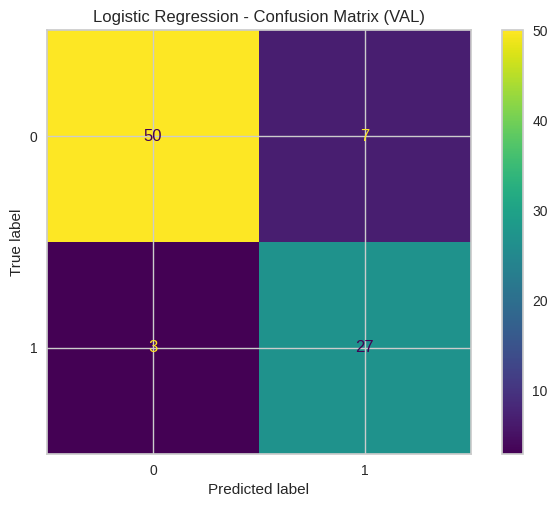


=== SVM (RBF) (num+cat) (VAL) ===
              precision    recall  f1-score   support

           0      0.864     0.895     0.879        57
           1      0.786     0.733     0.759        30

    accuracy                          0.839        87
   macro avg      0.825     0.814     0.819        87
weighted avg      0.837     0.839     0.838        87



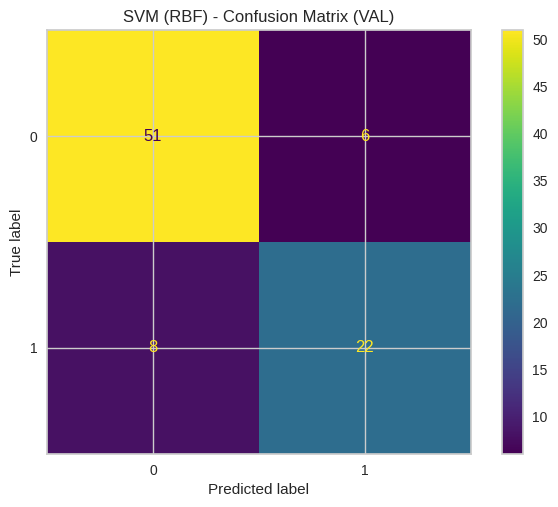


=== Random Forest (num+cat) (VAL) ===
              precision    recall  f1-score   support

           0      0.904     0.825     0.862        57
           1      0.714     0.833     0.769        30

    accuracy                          0.828        87
   macro avg      0.809     0.829     0.816        87
weighted avg      0.838     0.828     0.830        87



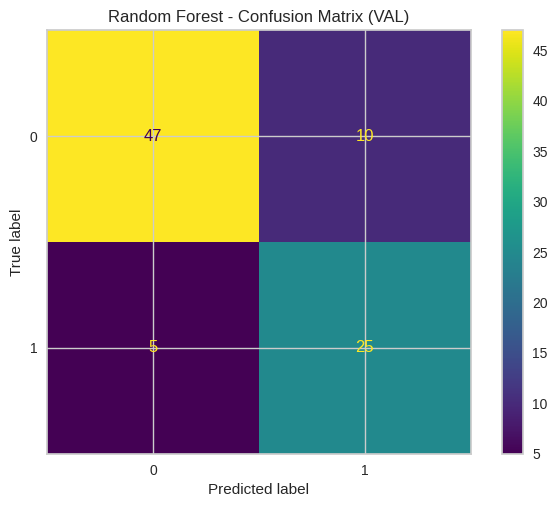

In [ ]:
#baseline on 3 models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Logistic Regression
lr_pipe = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", LogisticRegression(max_iter=2000, random_state=42))
])
lr_pipe.fit(X_train, y_train)
pred_lr_val = lr_pipe.predict(X_val)
print("=== Logistic Regression (num+cat) (VAL) ===")
print(classification_report(y_val, pred_lr_val, digits=3))
ConfusionMatrixDisplay(confusion_matrix(y_val, pred_lr_val)).plot()
plt.title("Logistic Regression - Confusion Matrix (VAL)")
plt.show()

# SVM
svm_pipe = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", SVC(kernel="rbf", random_state=42))
])
svm_pipe.fit(X_train, y_train)
pred_svm_val = svm_pipe.predict(X_val)
print("\n=== SVM (RBF) (num+cat) (VAL) ===")
print(classification_report(y_val, pred_svm_val, digits=3))
ConfusionMatrixDisplay(confusion_matrix(y_val, pred_svm_val)).plot()
plt.title("SVM (RBF) - Confusion Matrix (VAL)")
plt.show()

# Random Forest
rf_pipe = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", RandomForestClassifier(random_state=42))
])
rf_pipe.fit(X_train, y_train)
pred_rf_val = rf_pipe.predict(X_val)
print("\n=== Random Forest (num+cat) (VAL) ===")
print(classification_report(y_val, pred_rf_val, digits=3))
ConfusionMatrixDisplay(confusion_matrix(y_val, pred_rf_val)).plot()
plt.title("Random Forest - Confusion Matrix (VAL)")
plt.show()


We start with three baseline classifiers to get a first performance comparison:
- **logistic regression** as a simple and interpretable baseline
- **support vector machine** with an RBF kernel captures non linear decision boundaries
- **random forest** as a flexible tree based model

#

Since this is a screening problem, we pay special attention to recall for the high risk class, class 1. Higher recall means fewer truly high risk departments are missed.

Based on the **validation results**, **Logistic Regression** provides the highest recall for class 1 (i.e., the fewest false negatives) while maintaining a reasonable false-positive rate. For this reason, we select Logistic Regression as the final model for tuning and the final test evaluation.


# Logistic Regression tuning


Best parameters: {'model__C': 0.01, 'model__class_weight': 'balanced'}
Best CV recall: 0.9327

=== Logistic Regression tuned (VAL) ===
              precision    recall  f1-score   support

           0      0.933     0.737     0.824        57
           1      0.643     0.900     0.750        30

    accuracy                          0.793        87
   macro avg      0.788     0.818     0.787        87
weighted avg      0.833     0.793     0.798        87



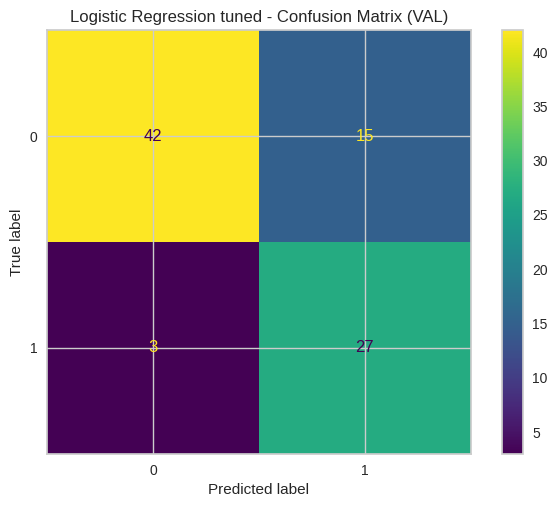

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid_lr = {
    "model__C": [0.01, 0.1, 1, 10, 100],
    "model__class_weight": [None, "balanced"]
}

grid_lr = GridSearchCV(
    estimator=lr_pipe,
    param_grid=param_grid_lr,
    scoring="recall",
    cv=5,
    n_jobs=-1
)

grid_lr.fit(X_train, y_train)

print("Best parameters:", grid_lr.best_params_)
print("Best CV recall:", round(grid_lr.best_score_, 4))

best_lr = grid_lr.best_estimator_
pred_val_tuned = best_lr.predict(X_val)

print("\n=== Logistic Regression tuned (VAL) ===")
print(classification_report(y_val, pred_val_tuned, digits=3))

cm_val = confusion_matrix(y_val, pred_val_tuned)
ConfusionMatrixDisplay(cm_val).plot()
plt.title("Logistic Regression tuned - Confusion Matrix (VAL)")
plt.show()


We tune Logistic Regression using **GridSearchCV**, with 5 fold cross validation on the training set. Since missing high-risk departments is the most costly error, we used recall for class 1 as the scoring metric.

The best configuration was **C = 0.01** with **class_weight = balanced**, with a strong cross-validated recall (0.9327).

On the validation set, the tuned model achieved recall(1) = 0.900 with the confusion matrix:
- TN = 42, FP = 15, FN = 3, TP = 27

This confirms a typical screening trade-off, very few false negatives, but more false positives.




# Baseline vs tuned Logistic Regression

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# baseline LR
pred_lr_val = lr_pipe.predict(X_val)

# tuned LR
pred_lr_tuned_val = best_lr.predict(X_val)

#Baseline LR on VALIDATION
cm_b = confusion_matrix(y_val, pred_lr_val)
tn_b, fp_b, fn_b, tp_b = cm_b.ravel()

print("=== Baseline Logistic Regression (num+cat) (VAL) ===")
print(f"TN={tn_b}, FP={fp_b}, FN={fn_b}, TP={tp_b}")
print(f"accuracy={accuracy_score(y_val, pred_lr_val):.3f} | "
      f"precision(1)={precision_score(y_val, pred_lr_val):.3f} | "
      f"recall(1)={recall_score(y_val, pred_lr_val):.3f} | "
      f"f1(1)={f1_score(y_val, pred_lr_val):.3f}")

# Tuned LR on VALIDATION
cm_t = confusion_matrix(y_val, pred_lr_tuned_val)
tn_t, fp_t, fn_t, tp_t = cm_t.ravel()

print("\n=== Tuned Logistic Regression (num+cat) (VAL) ===")
print(f"TN={tn_t}, FP={fp_t}, FN={fn_t}, TP={tp_t}")
print(f"accuracy={accuracy_score(y_val, pred_lr_tuned_val):.3f} | "
      f"precision(1)={precision_score(y_val, pred_lr_tuned_val):.3f} | "
      f"recall(1)={recall_score(y_val, pred_lr_tuned_val):.3f} | "
      f"f1(1)={f1_score(y_val, pred_lr_tuned_val):.3f}")


=== Baseline Logistic Regression (num+cat) (VAL) ===
TN=50, FP=7, FN=3, TP=27
accuracy=0.885 | precision(1)=0.794 | recall(1)=0.900 | f1(1)=0.844

=== Tuned Logistic Regression (num+cat) (VAL) ===
TN=42, FP=15, FN=3, TP=27
accuracy=0.793 | precision(1)=0.643 | recall(1)=0.900 | f1(1)=0.750


To check whether tuning actually improved performance in practice, we compare the baseline and tuned logistic regression on the same validation set.
- **baseline LR:** TN=50, FP=7, FN=3, TP=27 → recall(1)=0.900, F1(1)=0.844
- **tuner LR:** TN=42, FP=15, FN=3, TP=27 → recall(1)=0.900, F1(1)=0.750

Tuning does not improve high-risk recall, FN stays at 3, but it substantially increases false positives, 7 becomes 15, reducing precision and overall accuracy. For this reason, we retain the baseline logistic regression for the final evaluation on the untouched test set.

### Logistic Regression coefficients (feature interpretation)

Top 15 features by coefficient (Baseline Logistic Regression):


num__violations_past_3years             1.074310
cat__primary_function_Administrative    0.873219
cat__reporting_structure_Autonomous     0.657722
cat__secondary_function_Other           0.636532
cat__dept_type_Legal                    0.612775
cat__division_Corporate_HQ              0.563997
cat__secondary_function_Technology      0.442301
cat__team_size_None                     0.411662
cat__secondary_function_Operations      0.404730
cat__oversight_body_Board_Committee     0.369734
cat__creation_reason_None               0.323675
num__resource_availability_score        0.322301
num__executive_support                  0.318305
cat__location_type_Remote               0.317603
cat__dept_type_None                     0.287025
dtype: float64

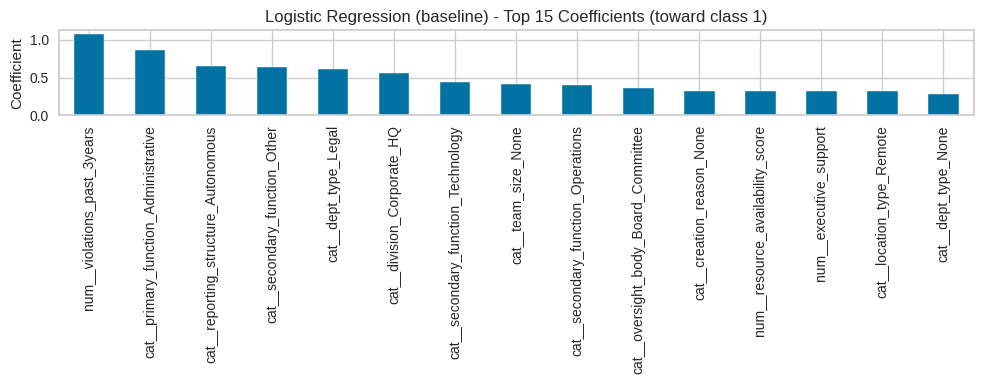

In [ ]:
# Baseline Logistic Regression
lr_model = lr_pipe.named_steps["model"]
pre = lr_pipe.named_steps["preprocess"]

feature_names = pre.get_feature_names_out()
coefs = lr_model.coef_.ravel()

feat_coef = pd.Series(coefs, index=feature_names).sort_values(ascending=False)

print("Top 15 features by coefficient (Baseline Logistic Regression):")
display(feat_coef.head(15))

plt.figure(figsize=(10,4))
feat_coef.head(15).plot(kind="bar")
plt.title("Logistic Regression (baseline) - Top 15 Coefficients (toward class 1)")
plt.ylabel("Coefficient")
plt.tight_layout()
plt.show()


To interpret the baseline Logistic Regression, we inspect the learned **coefficients**.  
In Logistic Regression, a **positive coefficient** increases the log-odds (and therefore the probability) of predicting class **1** (high-risk), while a negative coefficient would decrease it. The magnitude indicates the strength of the association **after preprocessing** (scaling for numeric variables + one-hot encoding for categorical variables).

The top positive drivers toward **high-risk** include:
- Organizational attributes such as secondary_function_Operations, secondary_function_Other, and reporting_structure_Autonomous,
- Governance/audit-related patterns such as oversight_body_External_Auditor.
- Operational signals like higher violations_past_3years and variables related to resources/support (resource_availability_score, executive_support).

Overall, the coefficients suggest that the model flags departments as high-risk based on a combination of **organizational structure/governance categories** and **recent violations / operational capacity indicators**.  
(These are associations learned from the data; they should not be interpreted as causal effects.)


# Final evaluation on the test set

=== FINAL Logistic Regression (TEST) ===
              precision    recall  f1-score   support

           0      0.902     0.965     0.932        57
           1      0.923     0.800     0.857        30

    accuracy                          0.908        87
   macro avg      0.912     0.882     0.895        87
weighted avg      0.909     0.908     0.906        87



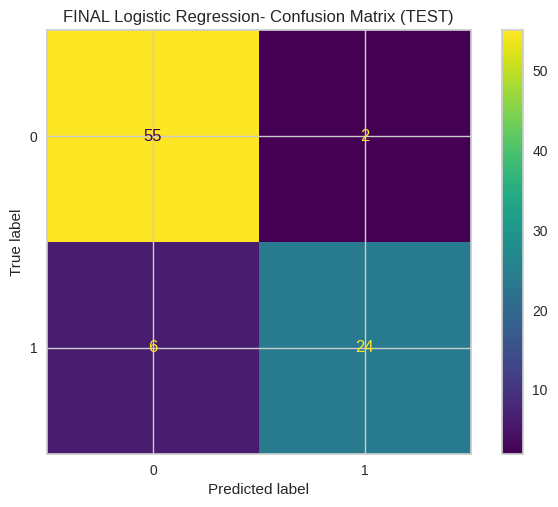


Confusion matrix (TEST): TN=55, FP=2, FN=6, TP=24

Summary metrics (class 1 = high-risk):
accuracy=0.908 | precision(1)=0.923 | recall(1)=0.800 | f1(1)=0.857


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

final_model = lr_pipe
final_model.fit(X_trainval, y_trainval)

pred_test = final_model.predict(X_test)

print("=== FINAL Logistic Regression (TEST) ===")
print(classification_report(y_test, pred_test, digits=3))

cm = confusion_matrix(y_test, pred_test)
ConfusionMatrixDisplay(cm).plot()
plt.title("FINAL Logistic Regression- Confusion Matrix (TEST)")
plt.show()

tn, fp, fn, tp = cm.ravel()
print(f"\nConfusion matrix (TEST): TN={tn}, FP={fp}, FN={fn}, TP={tp}")

print("\nSummary metrics (class 1 = high-risk):")
print(f"accuracy={accuracy_score(y_test, pred_test):.3f} | "
      f"precision(1)={precision_score(y_test, pred_test):.3f} | "
      f"recall(1)={recall_score(y_test, pred_test):.3f} | "
      f"f1(1)={f1_score(y_test, pred_test):.3f}")


Following a standard supervised workflow, we evaluate performance only once, on the untouched test set.

Since tuning did not improve high risk detection on the validation set and increased false positives, we use the baseline Logistic Regression as the final model, refit on the combined train and validation data.

On the test set, 87 departments: 57 class 0 and 30 class 1, the final model achieves:
- **accuracy = 0.908**
- **precision(1) = 0.923, recall(1) = 0.800, F1(1) = 0.857**

The confusion matrix is:
- **TN = 55, FP = 2, FN = 6, TP = 24**

This means the model flags high risk departments cautiously, very few false positives, but it still misses 6 out of 30 truly high risk cases at the default threshold.

# ROC curve

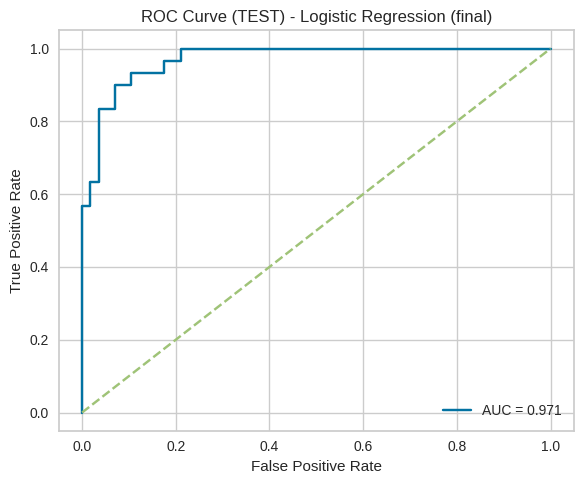

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

y_score = final_model.predict_proba(X_test)[:, 1]

fpr, tpr, _ = roc_curve(y_test, y_score)
auc = roc_auc_score(y_test, y_score)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0, 1], [0, 1], "--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (TEST) - Logistic Regression (final)")
plt.legend()
plt.tight_layout()
plt.show()


We plot the ROC curve for the final Logistic Regression using predicted probabilities on the held out test set. The curve lies well above the diagonal baseline and the resulting **AUC = 0.971**, indicating strong discriminative ability, across many decision thresholds, the model tends to assign higher risk scores to truly high risk departments than to low risk ones.

ROC-AUC is threshold independent, while the confusion matrix and precision/recall values correspond to the default classification threshold 0.5. In practice, the operating threshold can be adjusted depending on whether the compliance team prefers higher recall, fewer missed high risk cases, or fewer false positives.

# Feature interpretation

Top 15 features (final model) by coefficient:


num__violations_past_3years             1.074310
cat__primary_function_Administrative    0.873219
cat__reporting_structure_Autonomous     0.657722
cat__secondary_function_Other           0.636532
cat__dept_type_Legal                    0.612775
cat__division_Corporate_HQ              0.563997
cat__secondary_function_Technology      0.442301
cat__team_size_None                     0.411662
cat__secondary_function_Operations      0.404730
cat__oversight_body_Board_Committee     0.369734
cat__creation_reason_None               0.323675
num__resource_availability_score        0.322301
num__executive_support                  0.318305
cat__location_type_Remote               0.317603
cat__dept_type_None                     0.287025
dtype: float64

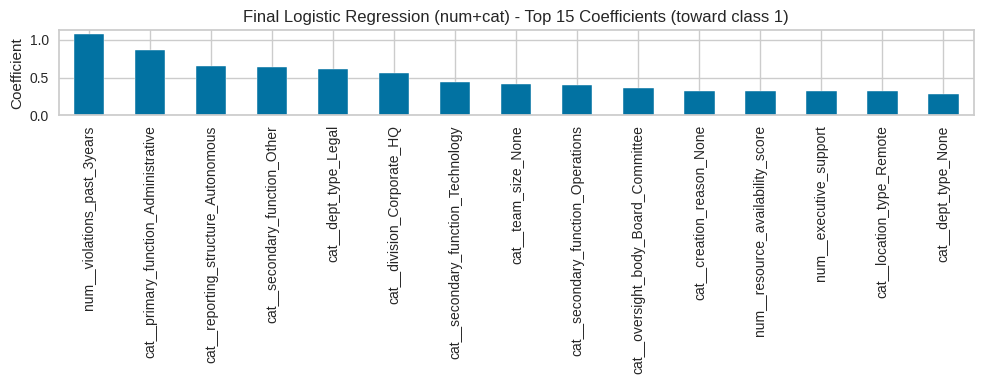

In [ ]:
lr_model_final = final_model.named_steps["model"]
pre_final = final_model.named_steps["preprocess"]

feature_names_final = pre_final.get_feature_names_out()
coefs_final = lr_model_final.coef_.ravel()

feat_coef_final = pd.Series(coefs_final, index=feature_names_final).sort_values(ascending=False)

print("Top 15 features (final model) by coefficient:")
display(feat_coef_final.head(15))

plt.figure(figsize=(10,4))
feat_coef_final.head(15).plot(kind="bar")
plt.title("Final Logistic Regression (num+cat) - Top 15 Coefficients (toward class 1)")
plt.ylabel("Coefficient")
plt.tight_layout()
plt.show()


To interpret the final Logistic Regression, we inspect its learned coefficients. A positive coefficient increases the predicted probability of class 1, high risk, while a negative coefficient decreases it. Because numeric variables are scaled and categorical variables are one-hot encoded, coefficients reflect associations after preprocessing, they are not causal effects.

In the final model, the strongest positive driver toward high risk is **violations_past_3years**, suggesting that departments with more recent violations are much more likely to be flagged. Other influential predictors are mainly organizational and governance descriptors, for instance department function/type, reporting structure, division/location, together with capacity/support signals such as **resource_availability_score** and **executive_support**. Overall, the model flags high risk departments based on a combination of recent compliance incidents and structural context.


## Conclusion (Prediction)

Overall, the supervised approach identifies high-risk departments using the available operational, governance, and risk indicators together with categorical descriptors.  
The final **Logistic Regression** model, evaluated only once on the held-out test set after refitting on train+validation, achieves **accuracy = 0.908** and, for the high-risk class, **precision(1)=0.923** and **recall(1)=0.800** (TN=55, FP=2, FN=6, TP=24). This indicates a conservative screening behaviour with very few false positives, while some high-risk departments are still missed.

In addition, the ROC curve yields a very high **AUC = 0.971**, showing strong overall discrimination: the model assigns higher risk scores to truly high-risk departments across thresholds. This suggests that the operating threshold could be adjusted depending on governance preferences (e.g., increasing recall at the cost of more false positives).

Finally, coefficient inspection highlights **recent violations** (violations_past_3years) as the strongest signal, together with organizational/governance indicators (department function/type, reporting structure, division/location) and operational capacity variables (resource_availability_score, executive_support).


## **Predictive Analysis**

### Purpose of the Predictive Analysis

The predictive component was introduced to assess whether the **structural and behavioral factors identified in the exploratory and clustering phases have forward-looking relevance**. Rather than aiming at automation, prediction is used to evaluate whether weak compliance outcomes are **systematically associated with observable organizational characteristics**.

The target variable is a binary indicator identifying departments in the **lower tail of the compliance_score_final distribution**, corresponding to materially weak compliance performance.



### Predictive Signal in the Data

Across all tested classification models (Logistic Regression, Support Vector Classifier, and Random Forest), performance is **consistently better than random assignment**, indicating that compliance underperformance follows recognizable patterns.

In particular, the selected Logistic Regression model (chosen based on validation recall for the high-risk class) suggests that:
- Departments with **high process gaps and weak audit scores** are more likely to be classified as high-risk.
- **Operational load and financial pressure** increase the likelihood of being flagged.
- Reporting frequency and employee engagement play a secondary but stabilizing role, consistent with earlier analyses.


Overall, the fact that different model families achieve non-trivial performance supports the presence of a stable predictive signal, rather than results being driven by a single modeling choice.


### Error Structure and Governance Implications

An important aspect of the predictive results concerns the **distribution of classification errors**.

From the confusion matrices and classification reports:
- **False negatives are relatively limited**, meaning that most severely underperforming departments are identified.
- **False positives remain present but controlled**, implying that some departments are flagged despite not falling into the lowest compliance tier.

This asymmetry indicates that the models prioritize **risk sensitivity**. In a compliance context, this trade-off is appropriate, as the cost of missing a true risk generally exceeds the cost of additional scrutiny.



### Relationship Between Prediction and Clustering

The predictive results are strongly aligned with the clustering outcomes:
- Departments flagged as high-risk are **concentrated in high-risk clusters**, particularly those characterized by weak audits, large process gaps, and elevated pressure.
- Departments belonging to low-risk clusters are rarely classified as high-risk.

This coherence shows that prediction does not contradict segmentation but rather **refines it by highlighting priority cases within known risk profiles**.



### What Prediction Adds

The predictive analysis contributes three main elements:

1. **Confirmation of key risk drivers**  
   Variables identified earlier as relevant also carry predictive value.

2. **Prioritization within risk profiles**  
   Not all departments in a high-risk cluster face the same urgency; prediction helps distinguish those requiring immediate attention.

3. **Early-warning capability**  
   The results indicate that compliance deterioration can be anticipated before outcomes fully materialize.



### Limits of the Predictive Component

The analysis also reveals clear limitations:
- Predictive performance remains **moderate**, indicating that not all determinants of compliance are captured.
- Classification errors persist, confirming that prediction cannot function as a stand-alone decision tool.

These limits reinforce the need to interpret predictive outputs as **supportive signals**, to be combined with managerial judgment.



### Overall Takeaway

The predictive component shows that weak compliance outcomes are **partially predictable** using observable organizational features. It strengthens the overall framework by reinforcing insights from descriptive and clustering analyses, enabling early prioritization, and supporting preventive governance without replacing human decision-making.

## **Compliance Improvement Roadmap**

The roadmap is structured into four sequential phases, moving from immediate risk visibility to long-term governance maturity. Each phase reflects a different managerial objective and builds on the insights generated in the previous stage, ensuring that compliance improvement is both **progressive and sustainable**.



### Phase 1: Risk Awareness & Prioritization (Short Term)

**Purpose**  
Establish a shared, data-driven understanding of where compliance risk is concentrated within the organization.

**Managerial focus**  
- Make compliance risk visible and comparable across departments.
- Replace intuition-based prioritization with evidence-based assessment.
- Create legitimacy and internal acceptance of the analytical framework.

At this stage, the emphasis is on **diagnosis and alignment**, not on intervention.



### Phase 2: Preventive Intervention & Process Strengthening (Medium Term)

**Purpose**  
Address structural weaknesses before they translate into realized compliance failures.

**Managerial focus**  
- Shift attention from incidents to their root causes.
- Strengthen processes and controls in structurally vulnerable departments.
- Reduce latent risk embedded in workflows and procedures.

This phase marks the transition from **reactive compliance** to **preventive governance**.



### Phase 3: Pressure & Culture Management (Medium to Long Term)

**Purpose**  
Mitigate the amplification of compliance risk caused by operational stress and cultural factors.

**Managerial focus**  
- Recognize pressure and incentives as compliance risk drivers.
- Reinforce transparency and speak-up mechanisms.
- Align organizational design with compliance objectives.

The goal is to create **conditions under which compliance is sustainable**, not enforced.



### Phase 4: Predictive Monitoring & Continuous Learning (Long Term)

**Purpose**  
Institutionalize a forward-looking, adaptive compliance system.

**Managerial focus**  
- Anticipate emerging risks before failures occur.
- Combine predictive signals with structural segmentation.
- Continuously update models and assumptions as the organization evolves.

This phase transforms compliance into a **living governance system** capable of learning over time.

## **Ethical Analysis: Risks, Trade-offs, and Design Constraints**

The Compliance Radar framework operates in a domain where analytical outputs can influence organizational power, scrutiny, and resource allocation. Ethical risk therefore does not stem from automation alone, but from the interaction between data, interpretation, and managerial action. This section explicitly examines where ethical failures could arise and how the project design constrains them.

### 1. Ethical Risk of Structural Misattribution

A central ethical risk in compliance analytics is **misattribution**: interpreting high-risk signals as evidence of poor managerial behavior rather than as the result of structural exposure. In this project, variables such as operational load and financial pressure are strongly associated with compliance outcomes, yet they often lie outside the direct control of individual departments.

To mitigate this risk, the analytical framework explicitly separates:
- **Exposure factors** (pressure, workload),
- **Control effectiveness** (process gaps, audit scores),
- **Observed outcomes** (incidents, compliance score).

Clusters are therefore interpreted as **risk environments**, not performance evaluations. This design choice directly addresses fairness concerns emphasized in EU Responsible AI guidance, by preventing analytical outputs from becoming implicit moral judgments.



### 2. Ethical Tension Between Transparency and Stigmatization

Clustering introduces an unavoidable ethical tension: while segmentation improves interpretability and targeting, it also risks **stigmatizing entire organizational units**. This risk is particularly acute for high-risk clusters that combine weak audits and high incident counts.

Rather than eliminating this tension, the project addresses it by:
- Using clustering at the **departmental level**, avoiding individual attribution,
- Avoiding static labels (e.g. *“non-compliant”*) in favor of **dynamic risk profiles**,
- Interpreting clusters as **temporary and revisable states**, not fixed identities.

This approach aligns with the EU AI Act’s emphasis on **proportionality** and safeguards against reputational harm.



### 3. Prediction, False Positives, and the Cost of Being Wrong

The predictive component introduces a distinct ethical trade-off: **false positives versus false negatives**. In a compliance context, falsely flagging a department can lead to unnecessary scrutiny and pressure, while missing a true risk can result in severe organizational harm.

The project makes an explicit ethical choice to:
- Prioritize **sensitivity to high-risk outcomes**,
- Accept a **controlled level of false positives**,
- Frame predictive flags as **triggers for review**, not conclusions.

This choice is ethically justified by the asymmetric cost of compliance failures, but it also reinforces the need for **human validation**, consistent with EU requirements on human oversight in high-impact AI systems.



### 4. Automation Bias and Governance Drift

A subtle but critical ethical risk is **governance drift**: over time, managers may begin to rely on analytical outputs as *de facto* decisions, even if the system was not designed for automation.

To counter this, the framework:
- Combines **prediction with clustering and descriptive analysis**, reducing reliance on a single signal,
- Encourages **periodic reassessment** of models and thresholds,
- Explicitly positions analytics as **supporting, not substituting, managerial judgment**.

This reflects the EU AI Act’s concern not only with system design, but with **organizational practices surrounding AI use**.



### EU AI Act Risk Classification

Under the EU AI Act’s risk-based framework, the Compliance Radar developed in this project does **not qualify as a high-risk AI system**. While it operates in an organizational governance context, it does not produce automated decisions affecting individuals’ legal rights, employment status, remuneration, or access to essential services. The system analyzes **aggregated, department-level data**, generates **non-binding risk signals**, and explicitly requires **human interpretation and oversight** before any managerial action is taken. Furthermore, predictive outputs are used solely for **prioritization and preventive review**, not for enforcement or disciplinary measures. As such, the framework is more appropriately classified as a **limited-risk decision-support system**, subject primarily to transparency and responsible-use obligations rather than the stringent *ex ante* conformity requirements reserved for high-risk AI systems under the EU AI Act.